In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix, pairwise_distances
from sklearn.manifold import TSNE
from itertools import chain
import time
import datetime
import pickle
import os

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

import warnings
warnings.simplefilter("ignore")

<IPython.core.display.Javascript object>

In [15]:
def graph_to_matrix(G,weighted=False,directed=False): # convert a graph object into a matrix
    matrix = np.zeros((len(G.nodes()),len(G.nodes())))
    for edge in G.edges(data=True):
        if weighted:
            matrix[edge[0],edge[1]] = edge[2]['weight']
        else:
            matrix[edge[0],edge[1]] = 1
        if not directed:
            matrix[edge[1],edge[0]] = matrix[edge[0],edge[1]] 
    return matrix
    
def matrix_to_graph(matrix): # convert an adjacency matrix into a graph object
    G = nx.Graph().to_directed()
    for i in range(matrix.shape[0]):
        G.add_node(i)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i,j] != 0:
                G.add_edge(i, j, weight=matrix[i,j])
    return G

def ErdosRenyiGraph(n,p):
    return nx.erdos_renyi_graph(n, p).to_directed(),False,False

def dRegularGraph(n,d):
    return nx.random_regular_graph(d, n).to_directed(),False,False

def randomAdjacencyMatrix(n,p,directed=False,weighted=False): #ErdosRenyi is unweighted & undirected
    # matrix is in dimension nxn (i.e. n is the number of nodes)
    # p is probability for having non-zero entries
    # values of non-zero entries are sampled in Unif[0,1) if graph is weighted
    matrix = (np.random.rand(n, n) < p).astype(int)
    np.fill_diagonal(matrix, 0)
    if weighted:
        matrix = matrix * np.random.rand(n, n)
    if not directed:
        for i in range(n):
            for j in range(n):
                matrix[j,i] = matrix[i,j]
    return matrix,directed,weighted

def geometricAdjacencyMatrix(n,d,r,metric='euclidean'):
    '''
    Valid values for metric are:
    From scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]. These metrics support sparse matrix inputs. [‘nan_euclidean’] but it does not yet support sparse matrices.
    From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] See the documentation for scipy.spatial.distance for details on these metrics. These metrics do not support sparse matrix inputs.
    '''
    points = np.random.uniform(0, 1, size=(n, d))
    distance_matrix = (pairwise_distances(points, metric=metric) < r).astype(int)
    np.fill_diagonal(distance_matrix, 0)
    return distance_matrix,False,False

def ChungLuGraph(n,max_degree):
    degrees = np.random.choice(range(1,max_degree+1), n, replace=True)
    G = nx.Graph()
    for node, degree in enumerate(degrees):
        G.add_node(node, degree=degree)
    for u in G.nodes():
        for v in G.nodes():
            if u < v and np.random.rand() < G.nodes[u]['degree'] * G.nodes[v]['degree'] / (2 * sum(degrees)):
                    G.add_edge(u, v)
    return G.to_directed(),False,False

def gridGraph(nrows,ncols): # not random
    G = nx.Graph()
    for i in range(nrows):
        for j in range(ncols):
            G.add_node(i*ncols+j)
    for i in range(nrows):
        for j in range(ncols):
            if i < nrows - 1:
                G.add_edge(i*ncols+j, (i+1)*ncols+j)
            if j < ncols - 1:
                G.add_edge(i*ncols+j+1, i*ncols+j)
    return G.to_directed(),False,False

In [16]:
def closestSeed_networkx(G,u,S,return_path=False):
    closest_point = None
    smallest_distance = float('inf')
    shortest_path = []
    for s in S:
        if nx.has_path(G, u, s):
            path = nx.shortest_path(G, source=u, target=s, weight="weight")
            distance = sum(G[path[i]][path[i + 1]]["weight"] for i in range(len(path) - 1))
            if distance < smallest_distance:
                closest_point, smallest_distance, shortest_path = s, distance, path  
    if not return_path:
        return closest_point, smallest_distance
    else:
        return closest_point, smallest_distance, shortest_path

#### Das Sarma & Bourgain ####

def closestSeedFromStartPoint(graph, start, target_set, return_path=False):
    # Works for weighted & unweighted, directed & undirected graphs 
    # Doesn't allow self-directed nodes

    closest_point, smallest_weight, shortest_path = None, float('inf'), []
    target_set = [x for x in target_set if x != start]
    if len(target_set) > 0:
        visited = set()  # To keep track of visited vertices (vertices in paths stored in queue)
        queue = deque([(start, 0, [])])  # Initialize the queue with the starting vertex, its path, and the total weight
        storage = deque() # To store nodes removed from queue

        while queue:
            vertex, weight, path = queue.popleft()  # Dequeue a vertex, its path, and the total weight
            storage.append((vertex, weight))
            if vertex not in target_set:
                for neighbor, edge_weight in enumerate(graph[vertex]):
                    if neighbor not in path and neighbor != vertex and edge_weight != 0:
                        new_weight = weight + edge_weight
                        if neighbor not in visited:
                            queue.append((neighbor, new_weight, path + [vertex]))
                            visited.add(neighbor)
                        else: # Replace the path from 'start' to 'neighbor' in queue or storage with a shorter one if found
                            weight_info = [(index,item[1]) for index,item in enumerate(list(queue)) if item[0] == neighbor]
                            if len(weight_info) != 0:
                                for index, w in weight_info:
                                    if new_weight < w:
                                        del queue[index]
                                        queue.append((neighbor, new_weight, path + [vertex]))
                            else:
                                weights = [item[1] for item in storage if item[0] == neighbor]
                                if len(weights) > 0 and new_weight < np.min(weights):
                                    queue.append((neighbor, new_weight, path + [vertex]))

            elif vertex in target_set:
                if closest_point == None:
                    closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                else:
                    if weight < smallest_weight:
                        closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                k = len(queue)
                for i in range(k):
                    if smallest_weight <= queue[k-1-i][1]:
                        queue.remove(queue[k-1-i]) # Remove all paths in queue which are longer than the current shortest from 'start' to a seed
    
    if return_path:
        return closest_point, smallest_weight, shortest_path
    else:
        return closest_point, smallest_weight

def closestSeedToEndPoint(graph, target, start_set, return_path=False): 
    # Works for weighted & unweighted, directed & undirected graphs 
    # Doesn't allow self-directed nodes

    closest_point, smallest_weight, shortest_path = None, float('inf'), []
    start_set = [x for x in start_set if x != target]
    if len(start_set) > 0:
        visited = set()  # To keep track of visited vertices (vertices in paths stored in queue)
        queue = deque()  # Initialize the queue with the starting vertex, its path, and the total weight
        for i in range(len(start_set)):
            queue.append((start_set[i], 0, []))
        storage = deque()

        while queue:
            vertex, weight, path = queue.popleft()  # Dequeue a vertex, its path, and the total weight
            storage.append((vertex, weight))
            if vertex != target:
                for neighbor, edge_weight in enumerate(graph[vertex]):
                    if neighbor not in path and neighbor not in start_set and neighbor != vertex and edge_weight != 0:
                        new_weight = weight + edge_weight
                        if neighbor not in visited:
                            queue.append((neighbor, new_weight, path + [vertex]))
                            visited.add(neighbor)
                        else: # Replace the path from a start node to 'neighbor' in queue with a shorter one if found
                            weight_info = [(index,item[1]) for index,item in enumerate(list(queue)) if item[0] == neighbor]
                            if len(weight_info) != 0:
                                for index, w in weight_info:
                                    if new_weight < w:
                                        del queue[index]
                                        queue.append((neighbor, new_weight, path + [vertex]))
                            else:
                                weights = [item[1] for item in storage if item[0] == neighbor]
                                if len(weights) > 0 and new_weight < np.min(weights):
                                    queue.append((neighbor, new_weight, path + [vertex]))
                                
            else:
                if closest_point == None:
                    closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                else:
                    if weight < smallest_weight:
                        closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                k = len(queue)
                for i in range(k):
                    if smallest_weight <= queue[k-1-i][1]:
                        queue.remove(queue[k-1-i]) # Remove all paths in queue which are longer than the current shortest from 'start' to a seed

    if return_path:
        return closest_point, smallest_weight, shortest_path
    else:
        return closest_point, smallest_weight

def offlineSample(G,u,node_to_sets=True):
    support = [n for n in range(G.shape[0]) if np.count_nonzero(G[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
    if len(support) == 0:
        return set()
    r = math.floor(np.log(len(support)))
    sample_sets = [np.random.choice(support,size=2**i,replace=False) for i in range(r+1)]
    if node_to_sets:
        closest_points = set([closestSeedFromStartPoint(G,u,S) for S in sample_sets])
    else:
        closest_points = set([closestSeedToEndPoint(G,u,S) for S in sample_sets])
    if (None,float('inf')) in closest_points:
        closest_points.remove((None,float('inf')))
    return closest_points,set(np.concatenate(sample_sets))

def offlineSketch(G,u,k,node_to_sets=True):
    closest_points,sample_sets = offlineSample(G,u,node_to_sets)
    for i in range(k):
        closest_points_new,sample_sets_new = offlineSample(G,u,node_to_sets)
        closest_points = closest_points.union(closest_points_new)
        sample_sets = sample_sets.union(sample_sets_new)
    return np.array(list(closest_points)),np.array(list(sample_sets))

def onlineShortestPath_Sarma(G,u,v,k,directed=False): ## upper bound
    if not directed:
        sketch_u,_ = offlineSketch(G,u,k)
        sketch_v,_ = offlineSketch(G,v,k)
    else:
        sketch_u,_ = offlineSketch(G,u,k)
    if sketch_u.shape[0] != 0 and sketch_v.shape[0] != 0:
        common_nodes = [w for w in sketch_u[:,0] if w in sketch_v[:,0]]
        while None in common_nodes:
            common_nodes.remove(None)
        min_dist = float('inf')
        for w in common_nodes:
            dist = sketch_u[sketch_u[:, 0] == w][0,1] + sketch_v[sketch_v[:, 0] == w][0,1]
            if dist < min_dist:
                min_dist = dist
        return min_dist
    else:
        return float('inf')

def onlineShortestPath_Bourgain(G,u,v,directed=False): ## lower bound
    support = [n for n in range(G.shape[0]) if np.count_nonzero(G[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
    r = math.floor(np.log(len(support)))
    sample_sets = [np.random.choice(support,size=2**i,replace=False) for i in range(r+1)]
    if directed:
        d_u_S = [closestSeedFromStartPoint(G,u,S)[1] for S in sample_sets]
        d_v_S = [closestSeedFromStartPoint(G,v,S)[1] for S in sample_sets]
        d_S_u = [closestSeedToEndPoint(G,u,S)[1] for S in sample_sets]
        d_S_v = [closestSeedToEndPoint(G,v,S)[1] for S in sample_sets]
        to_remove = [idx for idx,val in enumerate(list(zip(d_u_S,d_v_S))) if val[0] == float('inf') or val[1] == float('inf')]
        d_u_S = np.array([value for index, value in enumerate(d_u_S) if index not in to_remove])
        d_v_S = np.array([value for index, value in enumerate(d_v_S) if index not in to_remove])
        to_remove = [idx for idx,val in enumerate(list(zip(d_S_u,d_S_v))) if val[0] == float('inf') or val[1] == float('inf')]
        d_S_u = np.array([value for index, value in enumerate(d_S_u) if index not in to_remove])
        d_S_v = np.array([value for index, value in enumerate(d_S_v) if index not in to_remove])
        return max([0,np.max(d_S_v-d_S_u),np.max(d_u_S-d_v_S)])
    else:
        d_u_S = [closestSeedFromStartPoint(G,u,S)[1] for S in sample_sets]
        d_v_S = [closestSeedFromStartPoint(G,v,S)[1] for S in sample_sets]
        to_remove = [idx for idx,val in enumerate(list(zip(d_u_S,d_v_S))) if val[0] == float('inf') or val[1] == float('inf')]
        d_u_S = np.array([value for index, value in enumerate(d_u_S) if index not in to_remove])
        d_v_S = np.array([value for index, value in enumerate(d_v_S) if index not in to_remove])
        return np.max(np.abs(d_u_S-d_v_S))

def shortestDistance_allNodes_Sarma(G,u,k,directed=False):
    distances = np.zeros(G.shape[0])
    for v in range(G.shape[0]):
        if u != v:
            distances[v] = onlineShortestPath_Sarma(G,u,v,k,directed)
    return distances

def shortestDistance_allNodes_Bourgain(G,u,directed=False):
    distances = np.zeros(G.shape[0])
    for v in range(G.shape[0]):
        if u != v:
            distances[v] = onlineShortestPath_Bourgain(G,u,v,directed)
    return distances

def shortestDistance_allNodes_networkx(G,u):
    if isinstance(G, np.ndarray):
        G = matrix_to_graph(G)
    n_nodes = len(G.nodes())
    distances = np.zeros(n_nodes)
    for v in range(n_nodes):
        if u != v:
            if nx.has_path(G, u, v):
                distances[v] = nx.shortest_path_length(G, u, v)
            else:
                distances[v] = float('inf')       
    return distances

In [17]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, hidden_channels3, hidden_channels4, hidden_channels5, out_channels, sigmoid = False, reLU = False):
        super(MLP, self).__init__()
        #torch.manual_seed(12345)
        self.name = 'mlp'
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.first_hidden_channels = hidden_channels1
        self.n_hidden_layers = 5
        self.lin1 = Linear(in_channels, hidden_channels1)
        self.lin2 = Linear(hidden_channels1, hidden_channels2)
        self.lin3 = Linear(hidden_channels2, hidden_channels3)
        self.lin4 = Linear(hidden_channels3, hidden_channels4)
        self.lin5 = Linear(hidden_channels4, hidden_channels5)
        self.lin6 = Linear(hidden_channels5, out_channels)
        if sigmoid:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None
        if reLU:
            self.reLU = torch.nn.ReLU()
        else:
            self.reLU = None

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        if self.sigmoid != None:
            x = self.sigmoid(x)
        if self.reLU != None:
            x = self.reLU(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, hidden_channels3, hidden_channels4, hidden_channels5, out_channels, sigmoid = False, reLU = False):
        super(GCN, self).__init__()
        #torch.manual_seed(1234567)
        self.name = 'gcn'
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.first_hidden_channels = hidden_channels1
        self.n_hidden_layers = 5
        self.conv1 = GCNConv(in_channels, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.conv4 = GCNConv(hidden_channels3, hidden_channels4)
        self.conv5 = GCNConv(hidden_channels4, hidden_channels5)
        self.conv6 = GCNConv(hidden_channels5, out_channels)
        if sigmoid:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None
        if reLU:
            self.reLU = torch.nn.ReLU()
        else:
            self.reLU = None

    def forward(self, x, edge_index, weights=None):
        if weights == None:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv4(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv5(x, edge_index)
        else:
            x = self.conv1(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv4(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv5(x, edge_index, edge_weight=weights)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        if self.sigmoid != None:
            x = self.sigmoid(x)
        if self.reLU != None:
            x = self.reLU(x)
        return x

def build(in_channels,out_channels,model,criterion_type,optimizer_type,scheduler_type = None):
    
    if isinstance(model, str):
        hidden_channels1 = 256
        hidden_channels2 = 128
        hidden_channels3 = 64
        hidden_channels4 = 32
        hidden_channels5 = 8
        if model == 'mlp':
            if criterion_type in ['ce','bce','multimargin']:
                model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,sigmoid = True)
            elif criterion_type in ['mse','l2','l1']: 
                model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,reLU = True)
            else:
                model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels)
        elif model == 'gcn':
            if criterion_type in ['ce','bce','multimargin']:
                model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,sigmoid = True)
            elif criterion_type in ['mse','l2','l1']: 
                model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,reLU = True)
            else:
                model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels)
        else:
            raise ValueError(
                "Model type not yet defined."
            )
    
    if criterion_type == 'ce':
        criterion = [torch.nn.CrossEntropyLoss()]
    elif criterion_type == 'bce':
        criterion = [torch.nn.BCELoss()]
    elif criterion_type == 'bcelogits':
        criterion = [torch.nn.BCEWithLogitsLoss()]
    elif criterion_type in ['mse','l2']:
        criterion = [torch.nn.MSELoss()]
    elif criterion_type == 'l1':
        criterion = [torch.nn.L1Loss()]
    elif criterion_type == 'multimargin': # cuda crashed (similar to focal loss)
        criterion = [torch.nn.MultiMarginLoss()]
    elif criterion_type == 'mse-mse':
        criterion1 = torch.nn.MSELoss()
        criterion2 = torch.nn.MSELoss()
        criterion = [criterion1,criterion2]
    else:
        raise ValueError(
            "Criterion type not yet defined."
        )
    
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    elif optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
    elif optimizer_type == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.0001, alpha=0.99, eps=1e-8, momentum=0.9)
    elif optimizer_type == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.0001, lr_decay=0.0001)
    else:
        raise ValueError(
            "Optimizer type not yet defined."
        )
    
    if scheduler_type == None:
        scheduler = None
    else:
        if scheduler_type == 'step':
            scheduler = [torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)]
        elif scheduler_type == 'reduce_on_plateau':
            scheduler = [torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=False)]
        elif scheduler_type == 'exponential':
            scheduler = [torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)]
        elif scheduler_type == 'cosine':
            scheduler = [torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)]
        elif scheduler_type == 'cyclic':
            if optimizer_type in ['sgd','rmsprop']:
                scheduler = [torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, cycle_momentum=True)]
            else:
                scheduler = [torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, cycle_momentum=False)]
        elif scheduler_type == 'cyclic-cosine':
            cycle_epochs = 5
            if optimizer_type in ['sgd','rmsprop']:
                scheduler_cyclic = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=cycle_epochs, cycle_momentum=True)
            else:
                scheduler_cyclic = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=cycle_epochs, cycle_momentum=False)
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cycle_epochs * 2)
            scheduler = [scheduler_cyclic,scheduler_cosine]
        else:
            raise ValueError(
                "Scheduler type not yet defined."
            )
    
    return model,criterion,optimizer,scheduler

In [18]:
def test(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index = None,samples_weights = None):

    t_loss = 0
    total_samples = 0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                out = model(x)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)
        elif samples_weights == None:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                out = model(x,edge_index)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)
        else:
            for x,y,edge_index,weights in list(zip(samples_x,samples_y,samples_edge_index,samples_weights)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                    weights = weights.to('cuda:1')
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)

    t_loss = t_loss/total_samples
    t_loss = t_loss.cpu()
    if criterion_type in ['mse','l2','l1','mse-mse']:
        return t_loss, None, None, None
    else:
        y_true = np.array([y.cpu() for y in y_true])
        y_pred = np.array([y.cpu() for y in y_pred])
        #print(np.array(y_true).shape)
        #print(np.array(y_pred).shape)
        t_accuracy = sum(y_true == y_pred)/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        #print(cm.ravel())
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None,weights_train=None,weights_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
            out = model(x)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    elif weights_train == None:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
            out = model(x,edge_index)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index,weights in list(zip(x_train,y_train,edge_index_train,weights_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
                weights = weights.to('cuda:1')
            out = model(x,edge_index,weights)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy, train_sensitivity, train_specificity = test(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train,weights_train)
    v_loss, v_accuracy, v_sensitivity, v_specificity = test(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val,weights_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()
    return train_loss,train_accuracy,train_sensitivity,train_specificity,v_loss,v_accuracy,v_sensitivity,v_specificity

def visualizeTNSE(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="")
    plt.show()

def run(samples,model,criterion_type,optimizer_type,scheduler_type,num_epochs=100,early_stopping_patience=None,visualize = False,save_model = False):

    gpu_bool = torch.cuda.is_available()

    x_train = samples[0]
    x_val = samples[1]
    x_test = samples[2]
    y_train = samples[3]
    y_val = samples[4]
    y_test = samples[5]
    edge_index_train = samples[6]
    edge_index_val = samples[7]
    edge_index_test = samples[8]
    weights_train = samples[9]
    weights_val = samples[10]
    weights_test = samples[11]

    if criterion_type in ['ce','bce','multimargin']:
        out_channels = 2
    elif criterion_type == 'mse-mse':
        out_channels = y_train[0].shape[1]
    else:
        out_channels = 1

    if isinstance(model, str):
        model_type = model
        model,criterion,optimizer,scheduler = build(x_train[0].shape[1], out_channels, model_type,criterion_type,optimizer_type,scheduler_type)
    else:
        model_type = model.name
        _,criterion,optimizer,scheduler = build(x_train[0].shape[1], out_channels, model, criterion_type,optimizer_type,scheduler_type)
    print(model)

    if gpu_bool:
        model = model.to('cuda:1')
        
    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    train_loss = []
    train_acc = []
    train_sen = []
    train_spec = []
    val_loss = []
    val_acc = []
    val_sen = []
    val_spec = []

    if early_stopping_patience != None:
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement_count = 0

    for epoch in range(1, num_epochs+1):
        if model_type == 'mlp':
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
        else:
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val,weights_train,weights_val)
        train_loss.append(t_loss)
        train_acc.append(t_acc)
        train_sen.append(t_sen)
        train_spec.append(t_spec)
        val_loss.append(v_loss)
        val_acc.append(v_acc)
        val_sen.append(v_sen)
        val_spec.append(v_spec)
        #print(t_loss)
        #print(t_acc_or_error)
        if epoch % 10 == 0:
            if criterion_type in ['mse','l2','mse-mse']:
                print(f'Epoch: {epoch:03d}, Training Loss (MSE): {t_loss:.4f}, Validation Loss (MSE): {v_loss:.4f}')
            elif criterion_type == 'l1':
                print(f'Epoch: {epoch:03d}, Training Loss (MAE): {t_loss:.4f}, Validation Loss (MAE): {v_loss:.4f}')
            else:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

        if early_stopping_patience != None:
            if v_loss < best_val_loss:
                best_val_loss = v_loss
                best_epoch = epoch
                no_improvement_count = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                model.load_state_dict(torch.load('best_model.pth'))
                if gpu_bool:
                    model = model.to('cuda:1')
                break

    if model_type == 'mlp':
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test)
    else:
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test, weights_test)
    
    if early_stopping_patience == None:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')
    else:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

    x = range(1, len(train_loss)+1)
    plt.plot(x, train_loss, color = '#1f77b4', label = 'training loss', alpha = 0.6)
    plt.plot(x, val_loss, color = '#ff7f0e', label = 'validation loss', alpha = 0.6)
    if criterion_type in ['ce','bce','bcelogits','multimargin']:
        plt.plot(x, train_acc, color = '#2ca02c', label = 'training accuracy', alpha = 0.6)
        plt.plot(x, val_acc, color = '#d62728', label = 'validation accuracy', alpha = 0.6)
        plt.plot(x, train_sen, color = '#9467bd', label = 'training sensitivity', alpha = 0.6)
        plt.plot(x, val_sen, color = '#8c564b', label = 'validation sensitivity', alpha = 0.6)
        plt.plot(x, train_spec, color = '#e377c2', label = 'training specificity', alpha = 0.6)
        plt.plot(x, val_spec, color = '#7f7f7f', label = 'validation specificity', alpha = 0.6)
    plt.xlabel("epoch")
    plt.ylabel("")
    plt.title("training results")
    plt.legend(loc = 'right',bbox_to_anchor=(1.45, 0.5))
    plt.show()

    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    model = model.to('cpu')
    if save_model:
        torch.save(model.state_dict(), 'trained_model_'+str(model.in_channels)+'_'+str(model.first_hidden_channels)+'_'+str(model.out_channels)+'_'+str(model.n_hidden_layers)+'.pth')
    if criterion_type in ['mse','l2','l1','mse-mse']:
        if early_stopping_patience == None:
            return [model, train_loss[-1], val_loss[-1], test_loss]
        else:
            return [model, train_loss[best_epoch-1], val_loss[best_epoch-1], test_loss]
    else:
        if early_stopping_patience == None:
            return [model, train_acc[-1], train_sen[-1], train_spec[-1], val_acc[-1], val_sen[-1], val_spec[-1], test_acc, test_sen, test_spec]
        else:
            return [model, train_acc[best_epoch-1], train_sen[best_epoch-1], train_spec[best_epoch-1], val_acc[best_epoch-1], val_sen[best_epoch-1], val_spec[best_epoch-1], test_acc, test_sen, test_spec]

In [36]:
def predict(gpu_bool,model,criterion_type,samples_x,samples_edge_index=None,samples_weights=None):
    y_pred = []
    if gpu_bool:
        model = model.to('cuda:1')
    model.eval()
    with torch.no_grad():
        if model.name == 'mlp':
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                else:
                    x = samples_x[i]
                out = model(x)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        elif samples_weights == None:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                out = model(x,edge_index)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        else:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                    weights = samples_weights[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                    weights = samples_weights[i]
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
    model = model.to('cpu')
    return np.array(y_pred)

def predict_allBatches(model,criterion_type,samples):
    gpu_bool = torch.cuda.is_available()
    y_pred_train = predict(gpu_bool, model, criterion_type, samples[0], samples[6], samples[9])
    y_pred_val = predict(gpu_bool, model, criterion_type, samples[1], samples[7], samples[10])
    y_pred_test = predict(gpu_bool, model, criterion_type, samples[2], samples[8], samples[11])
    return y_pred_train,y_pred_val,y_pred_test

In [20]:
def evaluate_inner(title,y_actual,y_pred,true_distances,x_samples = None,classification=True): ## target is nx1

    if classification:

        graph_size = true_distances.shape[1]

        ## Calculate the proportion of points selected from the sample.
        ratio1 = np.mean(y_pred,axis=1)

        ## Check if any disconnected node is in actual sketch.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        M = np.max(true_distances) * 10
        true_distances[true_distances == -1] = M
        y_actual = torch.stack(y_actual).detach().numpy()
        dump_actual = y_actual*true_distances
        n_dump_actual_equal_M = np.sum((dump_actual == M).astype(int),axis=1)
        ratio2 = n_dump_actual_equal_M/np.sum(y_actual,axis=1) ## nan means empty sketch
        #ratio2[np.isnan(ratio2)] = -1

        ## Check if any disconnected node is chosen.
        dump = y_pred*true_distances
        n_true_distances_equal_M = np.sum((true_distances == M).astype(int),axis=1)
        n_dump_equal_M = np.sum((dump == M).astype(int),axis=1)
        n_selected = np.sum(y_pred,axis=1)
        n_selected[n_selected == 0] = 0.0001
        ratio3 = n_dump_equal_M/n_selected ## nan means no nodes have been selected, ratio1 = 0
        #ratio3[np.isnan(ratio3)] = -1

        if x_samples != None:

            ## Seed node and neighbors -> 1. Others -> 0
            seed_or_neighbors = np.zeros_like(true_distances)
            _,seeds = np.where(true_distances == 0) ## number of seeds = number of samples because we selected one seed from each sample
            seed_disconnected = np.zeros(seed_or_neighbors.shape[0])
            for i in range(len(seeds)):
                seed = seeds[i]
                seed_or_neighbors[i] = x_samples[i].detach().numpy()[seed] ## x_samples[i] has to be adjacency matrix
                seed_disconnected[i] = sum((seed_or_neighbors[i]>0).astype(int))>0
                seed_or_neighbors[i,seed] = 1
            seed_or_neighbors_selected = seed_or_neighbors*y_pred

            ## Is seed node not disconnected from the remaining?
            seed_disconnected = seed_disconnected.astype(int)

            ## Have seed node and its neighbors been chosen?
            ratio4 = np.sum(seed_or_neighbors_selected,axis=1)/np.sum(seed_or_neighbors,axis=1)

            ## How many of the chosen nodes are seed node and its neighbors?
            ratio5 = np.sum(seed_or_neighbors_selected,axis=1)/n_selected ## nan means no nodes have been selected, ratio1 = 0
            #ratio5[np.isnan(ratio5)] = -1

        ## Check if the chosen nodes are closer than random selection.
        sum_distance_selected = np.sum(dump,axis=1)
        term0 = np.mean(true_distances,axis=1)
        term0[term0 == 0] = 0.0001
        ratio6 = sum_distance_selected/n_selected/term0 ## nan means no nodes have been selected, ratio1 = 0
        #ratio6[np.isnan(ratio6)] = -1

        ## Same as ratio6 but excludes disconnected nodes with inf distance to the seed node.
        n_selected[n_selected == 0.0001] = 0
        term1 = n_selected-n_dump_equal_M
        term1[term1 == 0] = 0.0001
        term2 = np.sum(true_distances,axis=1)-n_true_distances_equal_M*M
        term2[term2 == 0] = 0.0001
        ratio7 = (sum_distance_selected-n_dump_equal_M*M)/term1/term2*(graph_size-n_true_distances_equal_M)
        #ratio7[np.isnan(ratio7)] = -1
        ## nan means no nodes have been selected (ratio1 = 0) or selected nodes are all disconnected from seed node (inf distance)

        plt.figure(figsize=(10, 5))
        plt.plot(range(len(ratio1)), ratio1, color = '#1f77b4', label = 'ratio 1: size of selected community to size of sample ratio',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio6, color = '#8c564b', label = 'ratio 2: mean distance of chosen nodes to seed node divided by mean distance of all nodes to seed node',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio7, color = '#e377c2', label = 'ratio 3: same as ratio 6 but excludes disconnected nodes',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio2, color = '#ff7f0e', label = 'ratio 4: proportion of disconnected nodes in actual sketch',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio3, color = '#2ca02c', label = 'ratio 5: proportion of disconnected nodes in the chosen community',alpha = 0.6)
        if x_samples != None:
            plt.plot(range(len(ratio1)), ratio4, color = '#d62728', label = 'ratio 6: proportion of seed node and its neighbors that are selected',alpha = 0.6)
            plt.plot(range(len(ratio1)), ratio5, color = '#9467bd', label = 'ratio 7: proportion of selected nodes that are seed node or its neighbors',alpha = 0.6)
            plt.scatter(range(len(ratio1)), seed_disconnected, color = 'k', marker='x', label = 'is seed node not disconnected from the remaining nodes in graph? 1 = True, 0 = False',alpha = 0.6)
        plt.xlabel("sample index")
        plt.ylabel("")
        plt.title(title)
        plt.legend(loc = 'lower center',bbox_to_anchor=(0.48, -0.6))
        plt.show()

        true_distances[true_distances == M] = np.inf
        if x_samples == None:
            return [np.mean(ratio1),np.mean(ratio6),np.mean(ratio7),np.mean(ratio2),np.mean(ratio3)]
        else:
            return [np.mean(ratio1),np.mean(ratio6),np.mean(ratio7),np.mean(ratio2),np.mean(ratio3),np.mean(ratio4),np.mean(ratio5)]
        
    else:

        ## Calculate prediction to true distance ratio.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        y_pred[y_pred == np.inf] = -1
        M = max(np.max(true_distances),np.max(y_pred))*10
        true_distances[true_distances == -1] = M
        true_distances[true_distances == 0] = 0.0001 ## to avoid ratio = x/0
        y_pred[y_pred == -1] = M
        ratio = (y_pred/true_distances).flatten()
        
        if len(np.unique(ratio)) == 1:
            print('Prediction to true distance ratio is '+str(ratio[0])+' for all samples in '+title+'.')
        else:
            plt.hist(ratio,density=False)
            plt.xlabel("prediction to true distance ratio")
            plt.ylabel("frequency")
            plt.title(title)
            plt.show()
            print('mean ratio = ',np.mean(ratio))

        true_distances[true_distances == M] = np.inf
        true_distances[true_distances == 0.0001] = 0
        y_pred[y_pred == M] = np.inf

        return [np.mean(ratio)]
    
def evaluate(model,criterion_type,samples,adjacency_matrix_available = False):
    if criterion_type in ['mse','l2','l1','mse-mse']:
        classification = False
    else:
        classification = True
    y_pred_train,y_pred_val,y_pred_test = predict_allBatches(model,criterion_type,samples)
    stats = []
    if adjacency_matrix_available:
        stats.append(evaluate_inner('training data',samples[3],y_pred_train,samples[12],samples[0],classification))
        stats.append(evaluate_inner('validation data',samples[4],y_pred_val,samples[13],samples[1],classification))
        stats.append(evaluate_inner('test data',samples[5],y_pred_test,samples[14],samples[2],classification))
    else:
        stats.append(evaluate_inner('training data',samples[3],y_pred_train,samples[12],classification=classification))
        stats.append(evaluate_inner('validation data',samples[4],y_pred_val,samples[13],classification=classification))
        stats.append(evaluate_inner('test data',samples[5],y_pred_test,samples[14],classification=classification))
    return np.array(stats)

In [21]:
def generateSamples_shortestPath_inner(n_samples,max_n_samples_per_graph,function,*args,**kwargs): ## max_n_samples_per_graph <= n
    samples_x = []
    samples_y = []
    samples_edge_index = []
    samples_weights = None
    object,directed,weighted = function(*args,**kwargs)
    if weighted:
        samples_weights = []
    if isinstance(object, np.ndarray):
        #matrix_type = object
        object = matrix_to_graph(object)
    #else:
        #matrix_type = graph_to_matrix(object)
    k = len(object.nodes())
    i = 0
    while i<n_samples:
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            selected_pairs = []
            while i<n_samples and j<max_n_samples_per_graph: 
                selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                nodes = list(np.random.choice(list(selected_component), size=2, replace=False))
                if nodes not in selected_pairs and [nodes[1],nodes[0]] not in selected_pairs: ## avoid the same nodes to be selected again
                    path = nx.shortest_path(object, nodes[0], nodes[1], weight="weight")
                    #print('Ground truth shortest path:',path)
                    #samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                    samples_x.append(torch.tensor(np.array([int(node in nodes) for node in range(k)]).reshape((k,1)).astype(np.float32), requires_grad=True))
                    samples_y.append(torch.tensor([int(node in path) for node in range(k)]).to(torch.float32))
                    samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                    if weighted:
                        print(nx.get_edge_attributes(object,'weight').values())
                        samples_weights.append(torch.tensor(list(nx.get_edge_attributes(object,'weight').values())).to(torch.int64))
                        print(samples_weights[-1])
                    i += 1
                j += 1
        else:
            object,directed,weighted = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                #matrix_type = object
                object = matrix_to_graph(object)
            #else:
                #matrix_type = graph_to_matrix(object)        
    return samples_x, samples_y, samples_edge_index,samples_weights

def generateSamples_shortestPath(n_train,n_val,n_test,max_n_samples_per_graph,function,*args,**kwargs):
    x_train, y_train, edge_index_train,weights_train = generateSamples_shortestPath_inner(n_train,max_n_samples_per_graph,function,*args,**kwargs)
    x_val, y_val, edge_index_val,weights_val = generateSamples_shortestPath_inner(n_val,max_n_samples_per_graph,function,*args,**kwargs)
    x_test, y_test, edge_index_test,weights_test = generateSamples_shortestPath_inner(n_test,max_n_samples_per_graph,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,weights_train,weights_val,weights_test]

In [22]:
def generateSamples_sketch_classification_inner(n_samples,max_n_samples_per_graph,k,function,*args,**kwargs):
    samples_x = []
    samples_y = []
    samples_edge_index = []
    samples_weights = None
    object,directed,weighted = function(*args,**kwargs)
    if weighted:
        samples_weights = []
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    n = len(object.nodes())
    true_distances = np.zeros((n_samples,n))
    i = 0
    n_err1 = 0
    while i<n_samples:
        if n_err1 > 100:
            raise ValueError(
                "Took too long to generate the full set of samples."
            )
        n_err1 += 1
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            while i<n_samples and j<max_n_samples_per_graph:
                n_err2 = 0
                while True:
                    try:
                        selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                        node = np.random.choice(list(selected_component))
                        sketch,sample_sets = offlineSketch(matrix_type,node,k)
                        if sketch.shape[0] != 0:
                            true_distances[i] = shortestDistance_allNodes_networkx(object,node)
                            #samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                            samples_x.append(torch.tensor(np.array([int(node in sample_sets) for node in range(n)]).reshape((n,1)).astype(np.float32), requires_grad=True))
                            sketch = np.append(sketch[:,0],node)
                            samples_y.append(torch.tensor([int(node in sketch) for node in range(n)]).to(torch.int64))
                            samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                            if weighted:
                                samples_weights.append(torch.tensor(np.array(list(nx.get_edge_attributes(object,'weight').values()))).to(torch.float32))
                            n_err1 = 0
                            i += 1
                        j += 1
                        break
                    except:
                        n_err2 += 1
                        if n_err2 == 100:
                            j = max_n_samples_per_graph
                            break
                            # if i == 0:
                            #     raise ValueError(
                            #         "Did not succesfully generate any sample."
                            #     )
                            # else:
                            #     raise ValueError(
                            #         "Took too long to generate the full set of samples."
                            #     )
                        continue
        else:
            object,directed,weighted = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index, samples_weights, true_distances

def generateSamples_sketch_classification(n_train,n_val,n_test,max_n_samples_per_graph,k,function,*args,**kwargs):
    x_train, y_train, edge_index_train, weights_train, true_distances_train = generateSamples_sketch_classification_inner(n_train,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_val, y_val, edge_index_val, weights_val, true_distances_val = generateSamples_sketch_classification_inner(n_val,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_test, y_test, edge_index_test, weights_test, true_distances_test = generateSamples_sketch_classification_inner(n_test,max_n_samples_per_graph,k,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,weights_train,weights_val,weights_test,true_distances_train,true_distances_val,true_distances_test]

In [23]:
def generateSamples_sketch_regression_inner(n_samples,max_n_samples_per_graph,k,function,*args,**kwargs):
    samples_x = []
    samples_y = []
    samples_edge_index = []
    samples_weights = None
    object,directed,weighted = function(*args,**kwargs)
    if weighted:
        samples_weights = []
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    n = len(object.nodes())
    true_distances = np.zeros((n_samples,n))
    i = 0
    n_err1 = 0
    while i<n_samples:
        if n_err1 > 100:
            raise ValueError(
                "Took too long to generate the full set of samples."
            )
        n_err1 += 1
        #print(i)
        components = list(nx.strongly_connected_components(object))
        connected_components = [c for c in components if len(c) > 1] ## only consider components with >= 2 nodes
        components_len = np.array([len(c) for c in connected_components])
        components_weights = components_len/np.sum(components_len)
        if len(connected_components) > 0:
            j = 0
            while i<n_samples and j<max_n_samples_per_graph:
                n_err2 = 0
                while True:
                    try:
                        #print(2)
                        selected_component = np.random.choice(connected_components, p=components_weights) ## select components with probability ~ its size
                        node = np.random.choice(list(selected_component))
                        sketch,sample_sets = offlineSketch(matrix_type,node,k)
                        if sketch.shape[0] != 0:
                            #print(3)
                            true_distances[i] = shortestDistance_allNodes_networkx(object,node)
                            #samples_x.append(torch.tensor(matrix_type.astype(np.float32), requires_grad=True))
                            samples_x.append(torch.tensor(np.array([int(node in sample_sets) for node in range(n)]).reshape((n,1)).astype(np.float32), requires_grad=True))
                            y = np.zeros(n)
                            for t in range(sketch.shape[0]):
                                y[int(sketch[t,0])] = sketch[t,1]
                            samples_y.append(torch.tensor(y).to(torch.float32))
                            samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                            if weighted:
                                samples_weights.append(torch.tensor(list(nx.get_edge_attributes(object,'weight').values())).to(torch.float32))
                            n_err1 = 0
                            i += 1
                            #print(i)
                        j += 1
                        break
                    except:
                        n_err2 += 1
                        if n_err2 == 100:
                            j = max_n_samples_per_graph
                            break
                            # if i == 0:
                            #     raise ValueError(
                            #         "Did not succesfully generate any sample."
                            #     )
                            # else:
                            #     raise ValueError(
                            #         "Took too long to generate the full set of samples."
                            #     )
                        continue  
        else:
            object,directed,weighted = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index, samples_weights, true_distances

def generateSamples_sketch_regression(n_train,n_val,n_test,max_n_samples_per_graph,k,function,*args,**kwargs):
    x_train, y_train, edge_index_train, weights_train, true_distances_train= generateSamples_sketch_regression_inner(n_train,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_val, y_val, edge_index_val, weights_val, true_distances_val = generateSamples_sketch_regression_inner(n_val,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_test, y_test, edge_index_test, weights_test, true_distances_test = generateSamples_sketch_regression_inner(n_test,max_n_samples_per_graph,k,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,weights_train,weights_val,weights_test,true_distances_train,true_distances_val,true_distances_test]

## Revised

In [24]:
def generateSamples_closestPoints_inner(n_samples,max_n_samples_per_graph,k,function,*args,**kwargs):
    samples_x = []
    samples_y = []
    samples_edge_index = []
    samples_weights = None
    not_disconnected_nodes = []
    object,directed,weighted = function(*args,**kwargs)
    if weighted:
        samples_weights = []
    if isinstance(object, np.ndarray):
        #matrix_type = object
        object = matrix_to_graph(object)
    #else:
        #matrix_type = graph_to_matrix(object)
    n = len(object.nodes())
    i = 0
    while i<n_samples:
        #print(i)
        components = list(nx.strongly_connected_components(object))
        to_remove = [c.pop() for c in components if len(c) == 1]
        if len(to_remove) < len(object.nodes()):
            object.remove_nodes_from(to_remove)
            remaining = object.nodes()
            object = nx.relabel_nodes(object, {node: index for index, node in enumerate(object.nodes())})
            if weighted:
                weights = list(nx.get_edge_attributes(object,'weight').values())
            n_new = len(object.nodes())
            r = 0
            #print(1)
            r_new = r
            while 2**r_new > n_new:
                r_new -= 1
                #print(r_new)
            j = 0
            #print('a')
            while i<n_samples and j<max_n_samples_per_graph:
                x_final = np.zeros((n_new,0))
                y_final = np.zeros((n_new,0))
                for h in range(k):
                    sample_sets = [np.random.choice(object.nodes(),size=seed_set_size,replace=False) for t in range(r_new+1)]
                    x = np.zeros((n_new,r+1))
                    y = np.zeros((n_new,(r+1)*2))
                    for t in range(r_new+1):
                        x[:,t] = np.array([int(node in sample_sets[t]) for node in range(n_new)])
                    for u in range(n_new):
                        distances = shortestDistance_allNodes_networkx(object,u)
                        if weighted:
                            M = n*max(weights)
                            distances = np.where(distances == float('inf'), M, distances)
                        else:
                            M = n
                            distances = np.where(distances == float('inf'), M, distances)
                        for t in range(r_new+1):
                            selected_distances = distances[sample_sets[t]]
                            y[u,t*2+1] = np.min(selected_distances)
                            if y[u,t*2+1] == M:
                                y[u,t*2] = -1
                            else:
                                y[u,t*2] = sample_sets[t][np.argmin(selected_distances)]
                    for t in range(r_new+1,r+1):
                        x[:,t] = x[:,t-1]
                        y[:t*2] = y[:t*2-2]
                        y[:t*2+1] = y[:t*2-1]
                    x_final = np.concatenate((x_final, x), axis=1)
                    y_final = np.concatenate((y_final, y), axis=1)
                samples_x.append(torch.tensor(x_final.astype(np.float32), requires_grad=True))
                samples_y.append(torch.tensor(y_final).to(torch.float32))
                samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                if weighted:
                    samples_weights.append(torch.tensor(weights).to(torch.float32))
                not_disconnected_nodes.append(remaining)
                i += 1
                j += 1
        else:
            object,directed,weighted = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                #matrix_type = object
                object = matrix_to_graph(object)
            #else:
                #matrix_type = graph_to_matrix(object)
    return samples_x, samples_y, samples_edge_index, samples_weights,not_disconnected_nodes

def generateSamples_closestPoints(n_train,n_val,n_test,max_n_samples_per_graph,k,function,*args,**kwargs):
    x_train, y_train, edge_index_train, weights_train,not_disconnected_train = generateSamples_closestPoints_inner(n_train,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_val, y_val, edge_index_val, weights_val,not_disconnected_val = generateSamples_closestPoints_inner(n_val,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_test, y_test, edge_index_test, weights_test,not_disconnected_test = generateSamples_closestPoints_inner(n_test,max_n_samples_per_graph,k,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,weights_train,weights_val,weights_test,not_disconnected_train,not_disconnected_val,not_disconnected_test]

In [25]:
model = 'gcn'
criterion_type = 'bce'
in_channels = 1
out_channels = 2
hidden_channels1 = 256
hidden_channels2 = 128
hidden_channels3 = 64
hidden_channels4 = 32
hidden_channels5 = 8
if model == 'mlp':
    if criterion_type in ['ce','bce','multimargin']:
        model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,sigmoid = True)
    elif criterion_type in ['mse','l2','l1']: 
        model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,reLU = True)
    else:
        model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels)
elif model == 'gcn':
    if criterion_type in ['ce','bce','multimargin']:
        model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,sigmoid = True)
    elif criterion_type in ['mse','l2','l1']: 
        model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,reLU = True)
    else:
        model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels)
else:
    raise ValueError(
        "Model type not yet defined."
    )
model.load_state_dict(torch.load('trained_model_1_256_2_5.pth'))


<All keys matched successfully>

In [26]:
def evaluate_inner(title,y_actual,y_pred,true_distances,x_samples = None,classification=True): ## target is nx1

    if classification:

        graph_size = true_distances.shape[1]

        ## Calculate the proportion of points selected from the sample.
        ratio1 = np.mean(y_pred,axis=1)

        ## Check if any disconnected node is in actual sketch.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        M = np.max(true_distances) * 10
        true_distances[true_distances == -1] = M
        y_actual = torch.stack(y_actual).detach().numpy()
        dump_actual = y_actual*true_distances
        n_dump_actual_equal_M = np.sum((dump_actual == M).astype(int),axis=1)
        ratio2 = n_dump_actual_equal_M/np.sum(y_actual,axis=1) ## nan means empty sketch
        #ratio2[np.isnan(ratio2)] = -1

        ## Check if any disconnected node is chosen.
        dump = y_pred*true_distances
        n_true_distances_equal_M = np.sum((true_distances == M).astype(int),axis=1)
        n_dump_equal_M = np.sum((dump == M).astype(int),axis=1)
        n_selected = np.sum(y_pred,axis=1)
        n_selected[n_selected == 0] = 0.0001
        ratio3 = n_dump_equal_M/n_selected ## nan means no nodes have been selected, ratio1 = 0
        #ratio3[np.isnan(ratio3)] = -1

        if x_samples != None:

            ## Seed node and neighbors -> 1. Others -> 0
            seed_or_neighbors = np.zeros_like(true_distances)
            _,seeds = np.where(true_distances == 0) ## number of seeds = number of samples because we selected one seed from each sample
            seed_disconnected = np.zeros(seed_or_neighbors.shape[0])
            for i in range(len(seeds)):
                seed = seeds[i]
                seed_or_neighbors[i] = x_samples[i].detach().numpy()[seed] ## x_samples[i] has to be adjacency matrix
                seed_disconnected[i] = sum((seed_or_neighbors[i]>0).astype(int))>0
                seed_or_neighbors[i,seed] = 1
            seed_or_neighbors_selected = seed_or_neighbors*y_pred

            ## Is seed node not disconnected from the remaining?
            seed_disconnected = seed_disconnected.astype(int)

            ## Have seed node and its neighbors been chosen?
            ratio4 = np.sum(seed_or_neighbors_selected,axis=1)/np.sum(seed_or_neighbors,axis=1)

            ## How many of the chosen nodes are seed node and its neighbors?
            ratio5 = np.sum(seed_or_neighbors_selected,axis=1)/n_selected ## nan means no nodes have been selected, ratio1 = 0
            #ratio5[np.isnan(ratio5)] = -1

        ## Check if the chosen nodes are closer than random selection.
        sum_distance_selected = np.sum(dump,axis=1)
        term0 = np.mean(true_distances,axis=1)
        term0[term0 == 0] = 0.0001
        ratio6 = sum_distance_selected/n_selected/term0 ## nan means no nodes have been selected, ratio1 = 0
        #ratio6[np.isnan(ratio6)] = -1

        ## Same as ratio6 but excludes disconnected nodes with inf distance to the seed node.
        n_selected[n_selected == 0.0001] = 0
        term1 = n_selected-n_dump_equal_M
        term1[term1 == 0] = 0.0001
        term2 = np.sum(true_distances,axis=1)-n_true_distances_equal_M*M
        term2[term2 == 0] = 0.0001
        ratio7 = (sum_distance_selected-n_dump_equal_M*M)/term1/term2*(graph_size-n_true_distances_equal_M)
        #ratio7[np.isnan(ratio7)] = -1
        ## nan means no nodes have been selected (ratio1 = 0) or selected nodes are all disconnected from seed node (inf distance)

        plt.figure(figsize=(10, 5))
        plt.plot(range(len(ratio1)), ratio1, color = '#1f77b4', label = 'ratio 1: size of selected community to size of sample ratio',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio6, color = '#8c564b', label = 'ratio 2: mean distance of chosen nodes to seed node divided by mean distance of all nodes to seed node',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio7, color = '#e377c2', label = 'ratio 3: same as ratio 6 but excludes disconnected nodes',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio2, color = '#ff7f0e', label = 'ratio 4: proportion of disconnected nodes in actual sketch',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio3, color = '#2ca02c', label = 'ratio 5: proportion of disconnected nodes in the chosen community',alpha = 0.6)
        if x_samples != None:
            plt.plot(range(len(ratio1)), ratio4, color = '#d62728', label = 'ratio 6: proportion of seed node and its neighbors that are selected',alpha = 0.6)
            plt.plot(range(len(ratio1)), ratio5, color = '#9467bd', label = 'ratio 7: proportion of selected nodes that are seed node or its neighbors',alpha = 0.6)
            plt.scatter(range(len(ratio1)), seed_disconnected, color = 'k', marker='x', label = 'is seed node not disconnected from the remaining nodes in graph? 1 = True, 0 = False',alpha = 0.6)
        plt.xlabel("sample index")
        plt.ylabel("")
        plt.title(title)
        plt.legend(loc = 'lower center',bbox_to_anchor=(0.48, -0.6))
        plt.show()

        true_distances[true_distances == M] = np.inf
        if x_samples == None:
            return [np.mean(ratio1),np.mean(ratio6),np.mean(ratio7),np.mean(ratio2),np.mean(ratio3)]
        else:
            return [np.mean(ratio1),np.mean(ratio6),np.mean(ratio7),np.mean(ratio2),np.mean(ratio3),np.mean(ratio4),np.mean(ratio5)]
        
    else:

        ## Calculate prediction to true distance.
        #y_actual[y_actual == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        #y_pred[y_pred == np.inf] = -1
        #M = max(np.max(y_actual),np.max(y_pred))*10
        #y_actual[y_actual == -1] = M
        y_actual = np.array(y_actual)
        #y_actual[y_actual == 0] = 0.0001 ## to avoid ratio = x/0
        #y_pred[y_pred == -1] = M
        #print(y_pred.shape)
        #print(y_actual.shape)
        diff_all = y_actual - y_pred

        for s in [0,1]:
            if s == 0:
                plot_title = 'closest node index regression: '
            else:
                plot_title = 'shortest distance regression: '
            diff = diff_all[:, :, s::2]
            diff = diff.reshape((diff.shape[0]*diff.shape[1],diff.shape[2]))

            if len(np.unique(diff)) == 1:
                print('y_actual - y_actual is '+str(diff[0])+' for all nodes in all seed sets in '+title+'.')
            else:
                for r in range(diff.shape[1]):
                    values, base = np.histogram(diff[:,r], bins=100)
                    cumulative = np.cumsum(values)
                    plt.plot(base[:-1], cumulative, label='r = '+str(r))
                    #plt.scatter([r]*ratio.shape[0],ratio[:,r])
                plt.xlabel("y_actual - y_pred")
                plt.ylabel("cummulative frequency")
                plt.title(plot_title + title)
                plt.legend()

                if plot_title == 'shortest distance regression: ':
                    filenames = os.listdir(dir)
                    if '0.png' not in filenames:
                        plt.savefig(dir+'/0.png')
                    else:
                        filenames = sorted([int(f[:-4]) for f in filenames])
                        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')                
                
                plt.show()

                m0 = np.mean(diff,axis=0)
                m1 = np.mean(diff,axis=1)
                print('mean difference per seed set = ',m0)
                print('mean difference per seed node = ',m1)

        #y_actual[y_actual == M] = np.inf
        #y_actual[y_actual == 0.0001] = 0
        #y_pred[y_pred == M] = np.inf

        #return [m0,m1]
    
def evaluate(model,criterion_type,samples,adjacency_matrix_available = False):
    if criterion_type in ['mse','l2','l1','mse-mse']:
        classification = False
    else:
        classification = True
    y_pred_train,y_pred_val,y_pred_test = predict_allBatches(model,criterion_type,samples)
    if adjacency_matrix_available:
        evaluate_inner('training data',samples[3],y_pred_train,samples[12],samples[0],classification)
        evaluate_inner('validation data',samples[4],y_pred_val,samples[13],samples[1],classification)
        evaluate_inner('test data',samples[5],y_pred_test,samples[14],samples[2],classification)
    else:
        evaluate_inner('training data',samples[3],y_pred_train,samples[12],classification=classification)
        evaluate_inner('validation data',samples[4],y_pred_val,samples[13],classification=classification)
        evaluate_inner('test data',samples[5],y_pred_test,samples[14],classification=classification)
    #return np.array(stats)

In [27]:
scale = 0

def test(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index = None,samples_weights = None):

    t_loss = 0
    total_samples = 0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                out = model(x)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += scale*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)
        elif samples_weights == None:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                out = model(x,edge_index)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += scale*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)
        else:
            for x,y,edge_index,weights in list(zip(samples_x,samples_y,samples_edge_index,samples_weights)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                    weights = weights.to('cuda:1')
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += scale*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)

    t_loss = t_loss/total_samples
    t_loss = t_loss.cpu()
    if criterion_type in ['mse','l2','l1','mse-mse']:
        return t_loss, None, None, None
    else:
        y_true = np.array([y.cpu() for y in y_true])
        y_pred = np.array([y.cpu() for y in y_pred])
        #print(np.array(y_true).shape)
        #print(np.array(y_pred).shape)
        t_accuracy = sum(y_true == y_pred)/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        #print(cm.ravel())
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None,weights_train=None,weights_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
            out = model(x)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = scale*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    elif weights_train == None:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
            out = model(x,edge_index)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = scale*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index,weights in list(zip(x_train,y_train,edge_index_train,weights_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
                weights = weights.to('cuda:1')
            out = model(x,edge_index,weights)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = scale*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy, train_sensitivity, train_specificity = test(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train,weights_train)
    v_loss, v_accuracy, v_sensitivity, v_specificity = test(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val,weights_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()
    return train_loss,train_accuracy,train_sensitivity,train_specificity,v_loss,v_accuracy,v_sensitivity,v_specificity

def visualizeTNSE(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="")
    plt.show()

def run(samples,model,criterion_type,optimizer_type,scheduler_type,num_epochs=100,early_stopping_patience=None,visualize = False,save_model = False):

    gpu_bool = torch.cuda.is_available()

    x_train = samples[0]
    x_val = samples[1]
    x_test = samples[2]
    y_train = samples[3]
    y_val = samples[4]
    y_test = samples[5]
    edge_index_train = samples[6]
    edge_index_val = samples[7]
    edge_index_test = samples[8]
    weights_train = samples[9]
    weights_val = samples[10]
    weights_test = samples[11]

    if criterion_type in ['ce','bce','multimargin']:
        out_channels = 2
    elif criterion_type == 'mse-mse':
        out_channels = y_train[0].shape[1]
    else:
        out_channels = 1

    if isinstance(model, str):
        model_type = model
        model,criterion,optimizer,scheduler = build(x_train[0].shape[1], out_channels, model_type,criterion_type,optimizer_type,scheduler_type)
    else:
        model_type = model.name
        _,criterion,optimizer,scheduler = build(x_train[0].shape[1], out_channels, model, criterion_type,optimizer_type,scheduler_type)
    print(model)

    if gpu_bool:
        model = model.to('cuda:1')
        
    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    train_loss = []
    train_acc = []
    train_sen = []
    train_spec = []
    val_loss = []
    val_acc = []
    val_sen = []
    val_spec = []

    if early_stopping_patience != None:
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement_count = 0

    for epoch in range(1, num_epochs+1):
        if model_type == 'mlp':
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
        else:
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val,weights_train,weights_val)
        train_loss.append(t_loss)
        train_acc.append(t_acc)
        train_sen.append(t_sen)
        train_spec.append(t_spec)
        val_loss.append(v_loss)
        val_acc.append(v_acc)
        val_sen.append(v_sen)
        val_spec.append(v_spec)
        #print(t_loss)
        #print(t_acc_or_error)
        if epoch % 10 == 0:
            if criterion_type in ['mse','l2','mse-mse']:
                print(f'Epoch: {epoch:03d}, Training Loss (MSE): {t_loss:.4f}, Validation Loss (MSE): {v_loss:.4f}')
            elif criterion_type == 'l1':
                print(f'Epoch: {epoch:03d}, Training Loss (MAE): {t_loss:.4f}, Validation Loss (MAE): {v_loss:.4f}')
            else:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

        if early_stopping_patience != None:
            if v_loss < best_val_loss:
                best_val_loss = v_loss
                best_epoch = epoch
                no_improvement_count = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                model.load_state_dict(torch.load('best_model.pth'))
                if gpu_bool:
                    model = model.to('cuda:1')
                break

    if model_type == 'mlp':
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test)
    else:
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test, weights_test)
    
    if early_stopping_patience == None:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')
    else:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

    x = range(1, len(train_loss)+1)
    plt.plot(x, train_loss, color = '#1f77b4', label = 'training loss', alpha = 0.6)
    plt.plot(x, val_loss, color = '#ff7f0e', label = 'validation loss', alpha = 0.6)
    if criterion_type in ['ce','bce','bcelogits','multimargin']:
        plt.plot(x, train_acc, color = '#2ca02c', label = 'training accuracy', alpha = 0.6)
        plt.plot(x, val_acc, color = '#d62728', label = 'validation accuracy', alpha = 0.6)
        plt.plot(x, train_sen, color = '#9467bd', label = 'training sensitivity', alpha = 0.6)
        plt.plot(x, val_sen, color = '#8c564b', label = 'validation sensitivity', alpha = 0.6)
        plt.plot(x, train_spec, color = '#e377c2', label = 'training specificity', alpha = 0.6)
        plt.plot(x, val_spec, color = '#7f7f7f', label = 'validation specificity', alpha = 0.6)
    plt.xlabel("epoch")
    plt.ylabel("")
    plt.title("training results")
    plt.legend(loc = 'right',bbox_to_anchor=(1.45, 0.5))
    plt.show()

    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    model = model.to('cpu')
    if save_model:
        torch.save(model.state_dict(), 'trained_model_'+str(model.in_channels)+'_'+str(model.first_hidden_channels)+'_'+str(model.out_channels)+'_'+str(model.n_hidden_layers)+'.pth')

    evaluate(model,criterion_type,samples,adjacency_matrix_available = False)

    if criterion_type in ['mse','l2','l1','mse-mse']:
        if early_stopping_patience == None:
            return [model, train_loss[-1], val_loss[-1], test_loss]
        else:
            return [model, train_loss[best_epoch-1], val_loss[best_epoch-1], test_loss]
    else:
        if early_stopping_patience == None:
            return [model, train_acc[-1], train_sen[-1], train_spec[-1], val_acc[-1], val_sen[-1], val_spec[-1], test_acc, test_sen, test_spec]
        else:
            return [model, train_acc[best_epoch-1], train_sen[best_epoch-1], train_spec[best_epoch-1], val_acc[best_epoch-1], val_sen[best_epoch-1], val_spec[best_epoch-1], test_acc, test_sen, test_spec]

In [28]:
seed_set_size = 1
k = 1
dir = '1 seed set'

In [16]:
#samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,5000,0.15)

In [17]:
#with open('er5000_015.pkl', 'wb') as file:
    #pickle.dump(samples, file)

In [18]:
#with open('er5000_015.pkl', 'rb') as file:
    #samples = pickle.load(file)

In [19]:
scale = 1000
#results = run(samples,'gcn','mse-mse','adam',None,50)

In [20]:
scale = 100
#results = run(samples,'gcn','mse-mse','adam',None,50)

In [21]:
scale = 10
#results = run(samples,'gcn','mse-mse','adam',None,50)

In [22]:
scale = 1
#results = run(samples,'gcn','mse-mse','adam',None,50)

In [23]:
scale = 1/10
#results = run(samples,'gcn','mse-mse','adam',None,50)

In [24]:
scale = 1/100
#results = run(samples,'gcn','mse-mse','adam',None,50)

In [25]:
scale = 0
#results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 26889.0488, Validation Loss (MSE): 29098.6719
Epoch: 020, Training Loss (MSE): 23271.0957, Validation Loss (MSE): 26846.7168
Epoch: 030, Training Loss (MSE): 23354.1094, Validation Loss (MSE): 27817.4961
Epoch: 040, Training Loss (MSE): 22399.6719, Validation Loss (MSE): 26690.9941
Epoch: 050, Training Loss (MSE): 22646.4648, Validation Loss (MSE): 28897.7422
Test Loss (MSE): 33532.414062


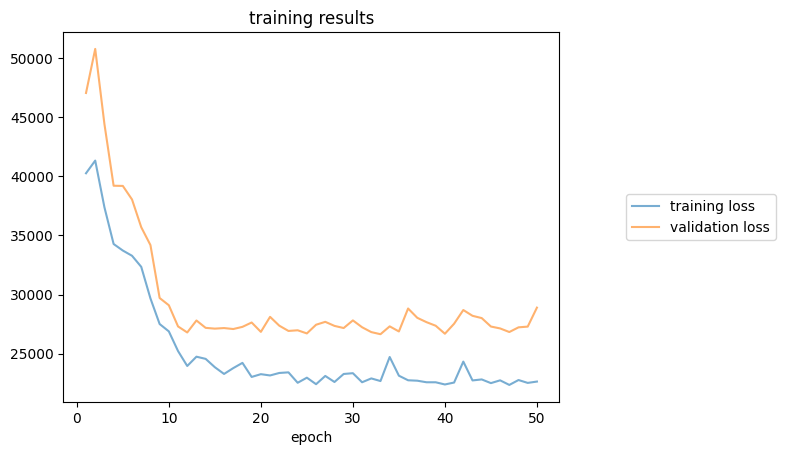

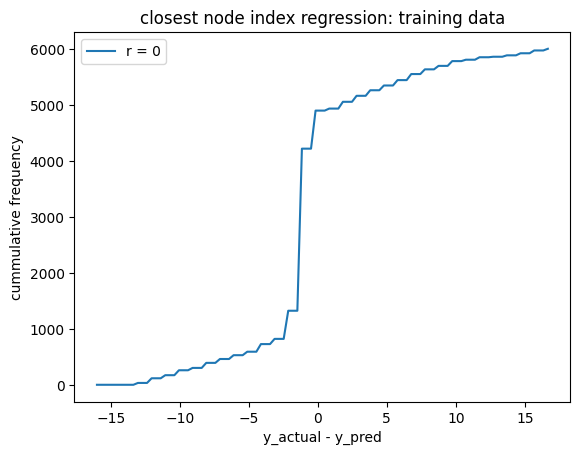

mean difference per seed set =  [-0.34016666]
mean difference per seed node =  [ -8. -10. -10. ...  -1.  -4.  -1.]


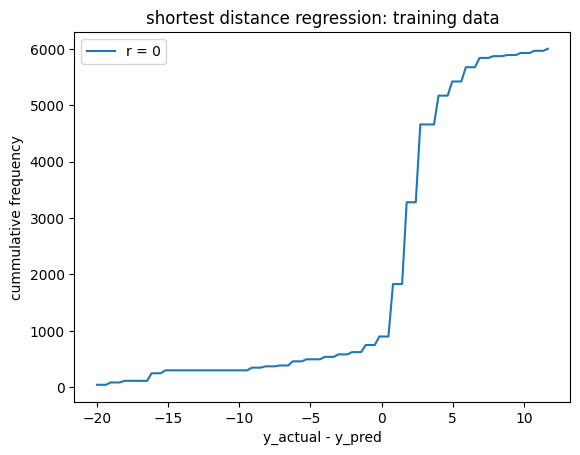

mean difference per seed set =  [1.4486667]
mean difference per seed node =  [1. 4. 1. ... 2. 8. 1.]


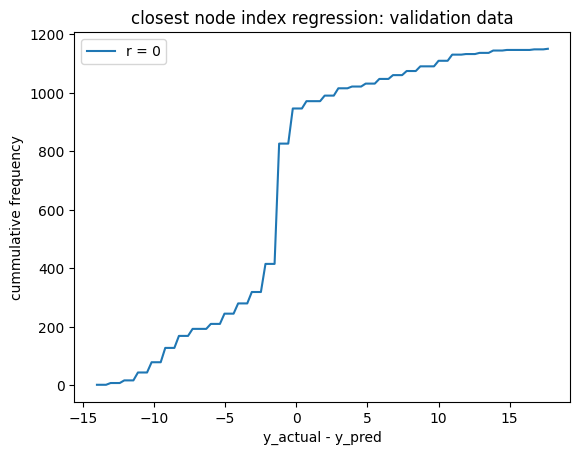

mean difference per seed set =  [-1.366087]
mean difference per seed node =  [-1. -1. -1. ... -1. -1. -2.]


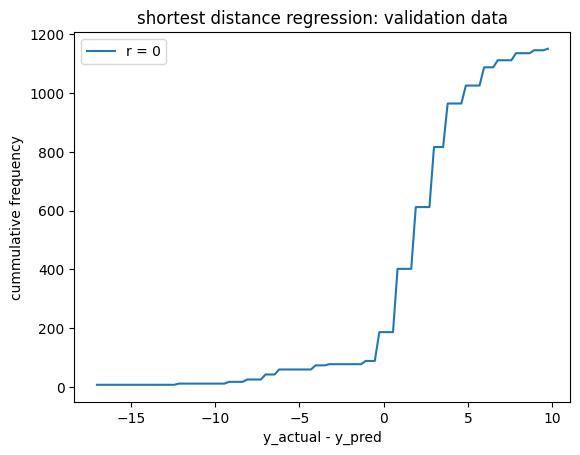

mean difference per seed set =  [2.0991304]
mean difference per seed node =  [1. 3. 2. ... 3. 3. 4.]


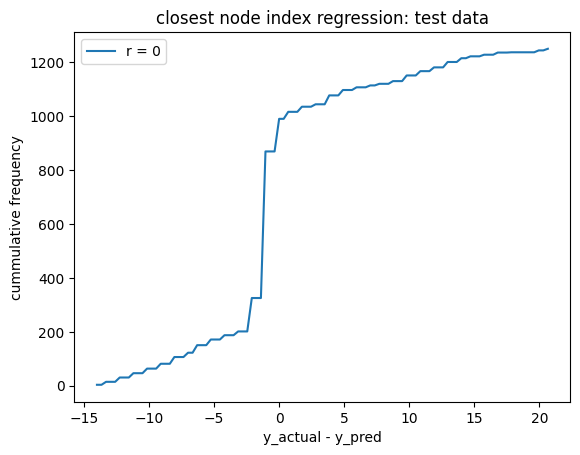

mean difference per seed set =  [-0.1336]
mean difference per seed node =  [ -1. -13.  -1. ...  -7.  -1.  -9.]


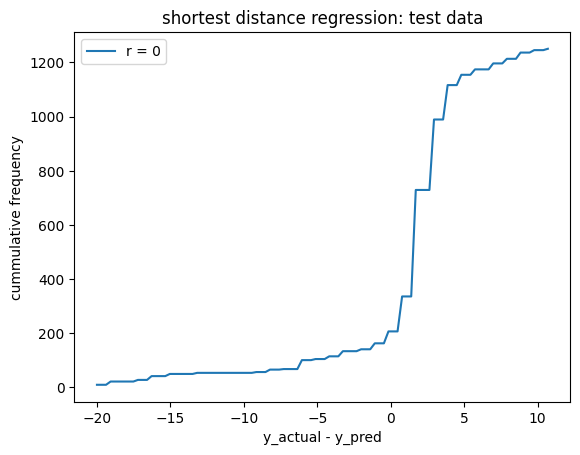

mean difference per seed set =  [1.412]
mean difference per seed node =  [  3.   7.   3. ...  -6. -19.  -3.]


In [26]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.05)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)


Epoch: 010, Training Loss (MSE): 70451.5547, Validation Loss (MSE): 88160.3203
Epoch: 020, Training Loss (MSE): 69440.8438, Validation Loss (MSE): 87037.6484
Epoch: 030, Training Loss (MSE): 68746.0391, Validation Loss (MSE): 86246.7188
Epoch: 040, Training Loss (MSE): 67798.9531, Validation Loss (MSE): 84769.9688
Epoch: 050, Training Loss (MSE): 67518.1016, Validation Loss (MSE): 84545.9609
Test Loss (MSE): 97447.101562


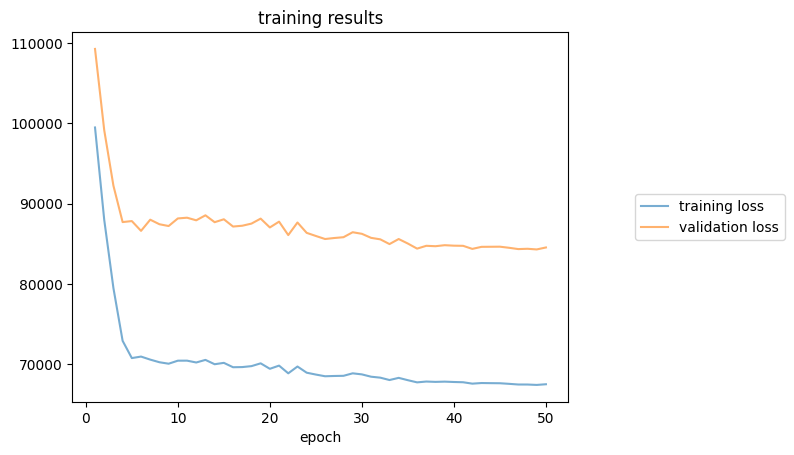

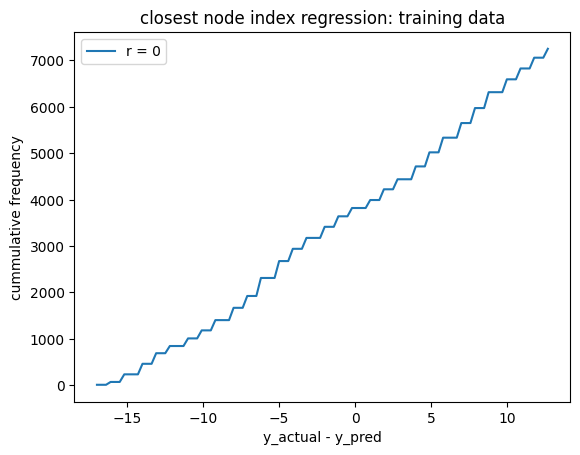

mean difference per seed set =  [-0.46772414]
mean difference per seed node =  [-10.  -9.  -9. ...   4.   3.   4.]


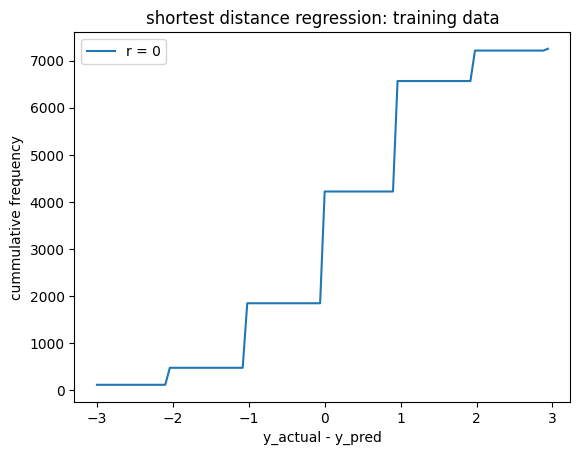

mean difference per seed set =  [0.18289655]
mean difference per seed node =  [-1. -1.  0. ...  1.  0.  0.]


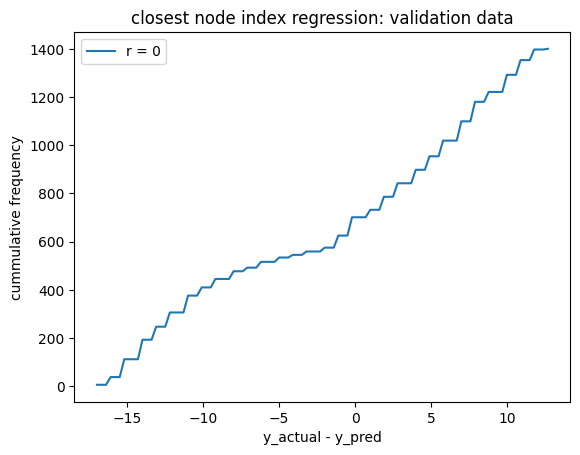

mean difference per seed set =  [-1.2357143]
mean difference per seed node =  [ 12.  11.  13. ... -13. -14. -13.]


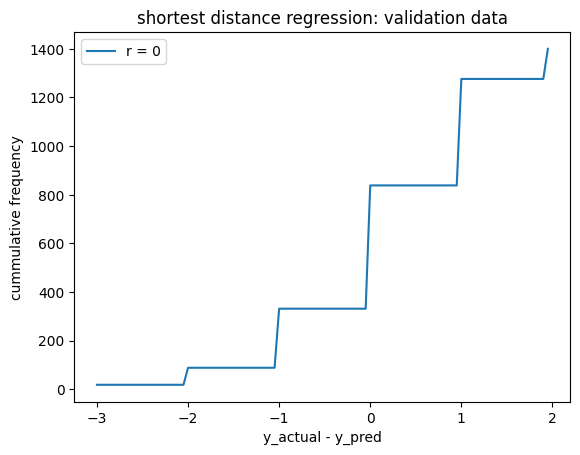

mean difference per seed set =  [0.17785715]
mean difference per seed node =  [0. 2. 0. ... 1. 0. 1.]


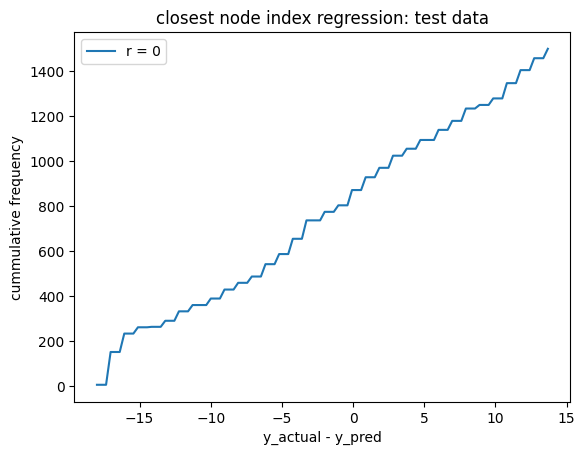

mean difference per seed set =  [-1.9826666]
mean difference per seed node =  [-6. -5. -5. ...  5.  4.  5.]


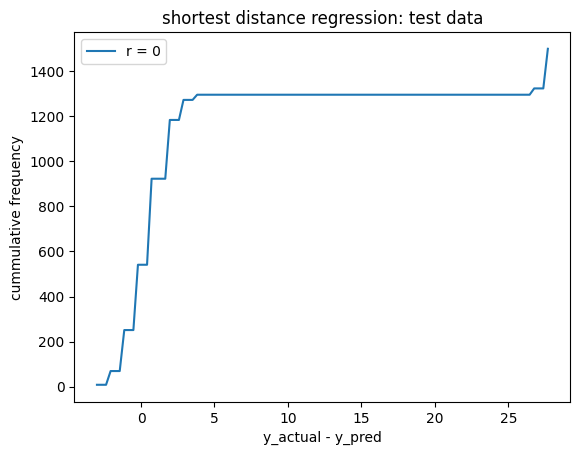

mean difference per seed set =  [4.412667]
mean difference per seed node =  [1. 1. 1. ... 0. 2. 1.]


In [27]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.1)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)


Epoch: 010, Training Loss (MSE): 77071.6328, Validation Loss (MSE): 70953.6250
Epoch: 020, Training Loss (MSE): 76231.6953, Validation Loss (MSE): 70576.0312
Epoch: 030, Training Loss (MSE): 75677.9531, Validation Loss (MSE): 70145.2344
Epoch: 040, Training Loss (MSE): 75360.0859, Validation Loss (MSE): 69654.5938
Epoch: 050, Training Loss (MSE): 75135.3281, Validation Loss (MSE): 69564.2969
Test Loss (MSE): 80818.351562


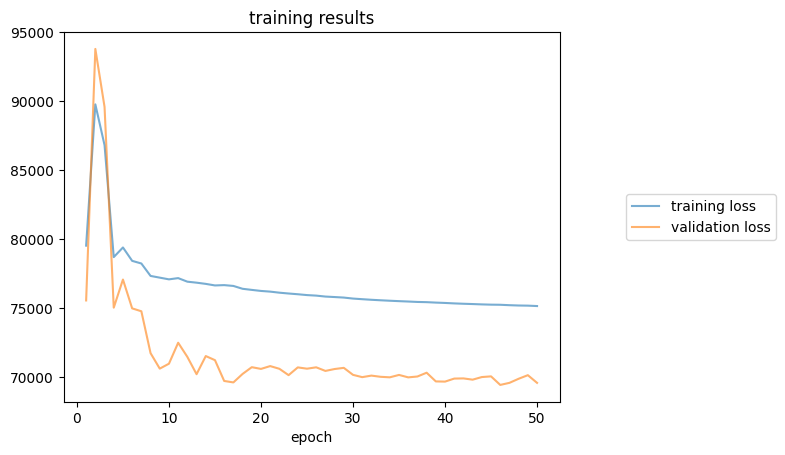

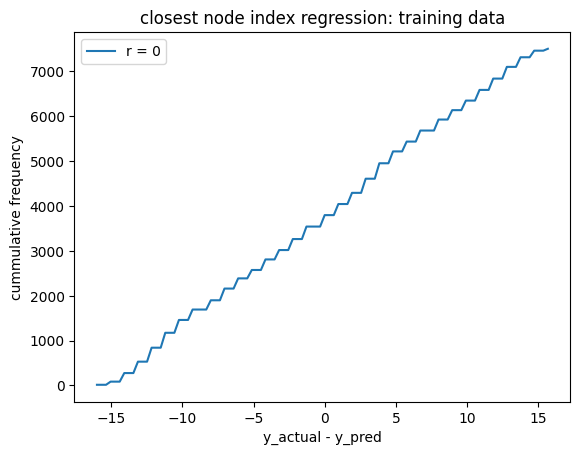

mean difference per seed set =  [0.07733333]
mean difference per seed node =  [-5. -3. -3. ... 16. 15. 14.]


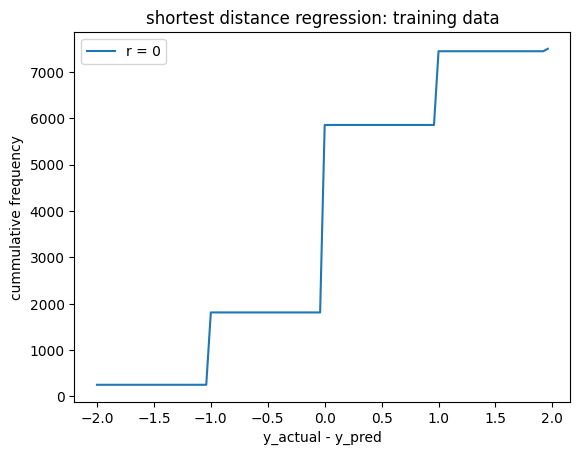

mean difference per seed set =  [-0.04853333]
mean difference per seed node =  [ 0. -1.  1. ...  0.  0. -2.]


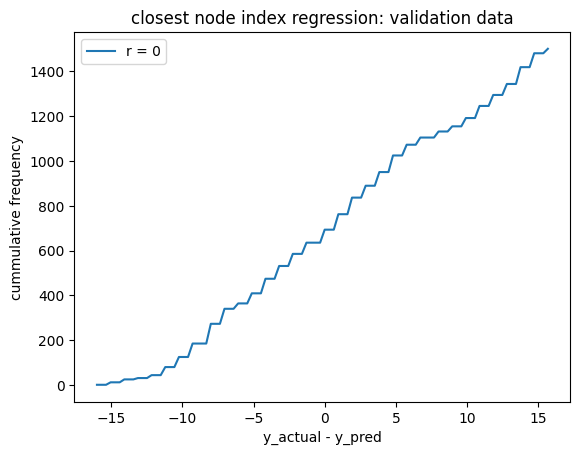

mean difference per seed set =  [1.5333333]
mean difference per seed node =  [4. 4. 5. ... 5. 5. 5.]


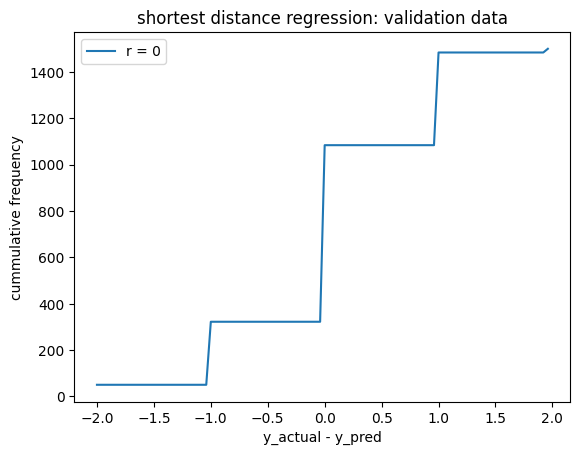

mean difference per seed set =  [0.04]
mean difference per seed node =  [ 0. -1.  0. ...  0.  0.  1.]


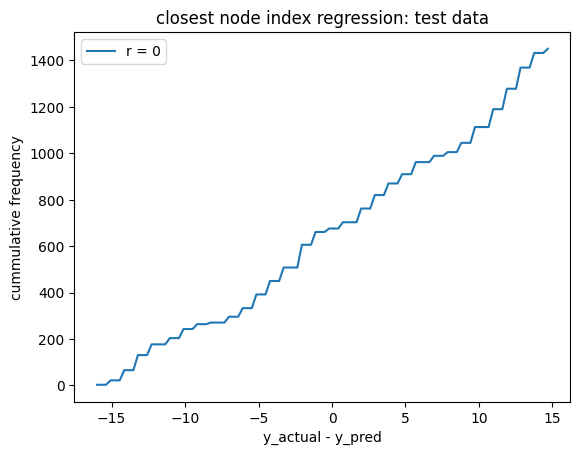

mean difference per seed set =  [1.3786207]
mean difference per seed node =  [-3. -3. -4. ...  3.  2.  3.]


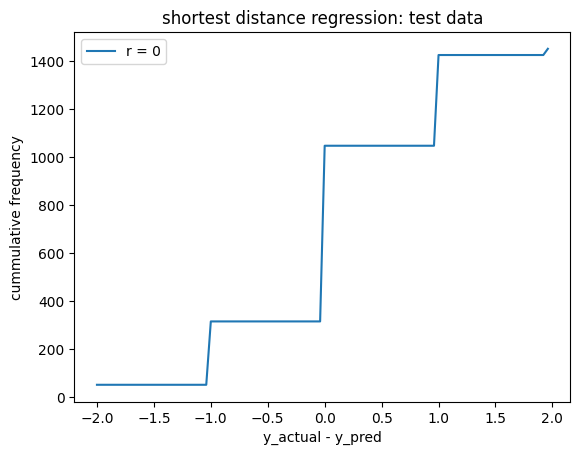

mean difference per seed set =  [0.04551724]
mean difference per seed node =  [0. 0. 0. ... 1. 1. 0.]


In [29]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.2)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)


Epoch: 010, Training Loss (MSE): 77496.6328, Validation Loss (MSE): 80114.9688
Epoch: 020, Training Loss (MSE): 77326.3828, Validation Loss (MSE): 79403.4219
Epoch: 030, Training Loss (MSE): 77156.0781, Validation Loss (MSE): 79074.5000
Epoch: 040, Training Loss (MSE): 76885.5547, Validation Loss (MSE): 78889.1797
Epoch: 050, Training Loss (MSE): 76450.8984, Validation Loss (MSE): 78886.7969
Test Loss (MSE): 66150.406250


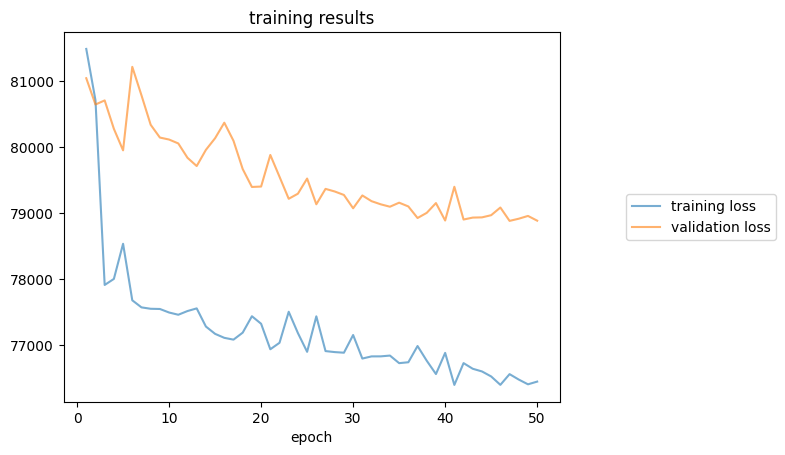

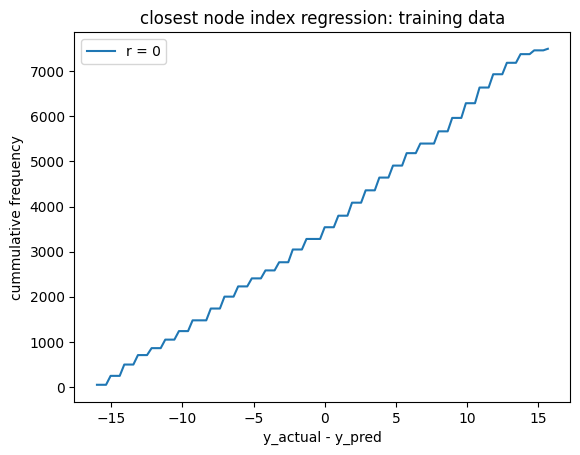

mean difference per seed set =  [0.58933336]
mean difference per seed node =  [10. 10. 12. ...  9.  9.  7.]


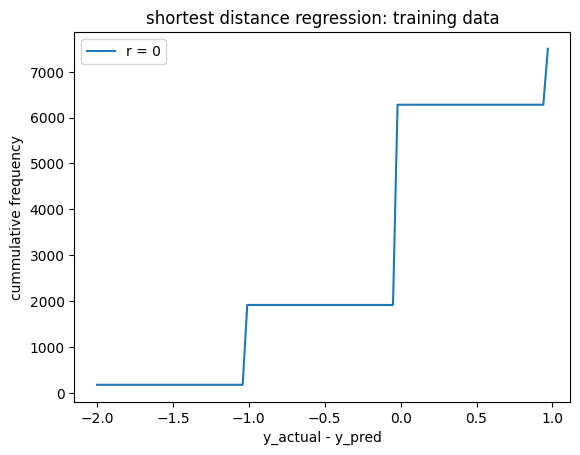

mean difference per seed set =  [-0.11573333]
mean difference per seed node =  [-1. -1.  0. ... -1.  0.  1.]


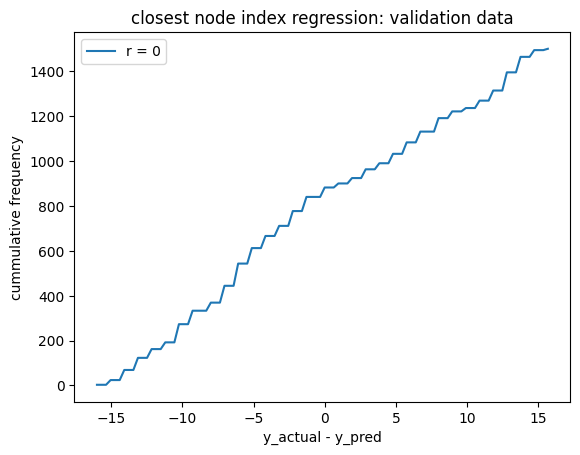

mean difference per seed set =  [-0.42]
mean difference per seed node =  [14. 13. 14. ... -6. -6. -6.]


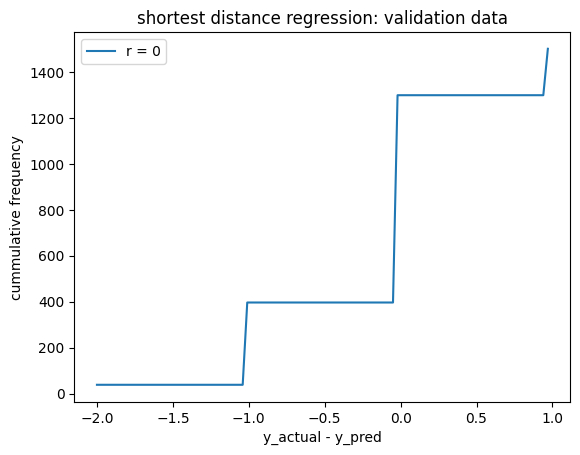

mean difference per seed set =  [-0.15466666]
mean difference per seed node =  [-1.  0.  0. ...  0. -1.  0.]


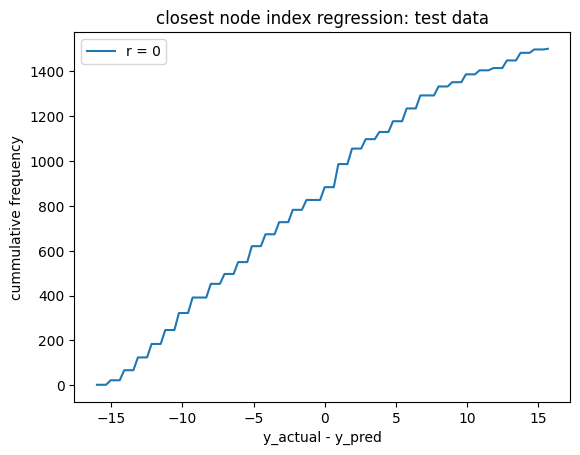

mean difference per seed set =  [-1.7666667]
mean difference per seed node =  [-10.  -9. -10. ... -10. -11. -11.]


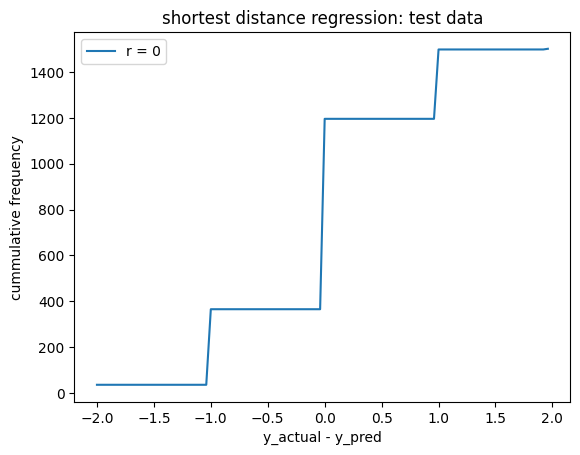

mean difference per seed set =  [-0.06333333]
mean difference per seed node =  [0. 0. 1. ... 0. 0. 1.]


In [30]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.4)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)


Epoch: 010, Training Loss (MSE): 77293.3828, Validation Loss (MSE): 95729.6250
Epoch: 020, Training Loss (MSE): 73885.5312, Validation Loss (MSE): 90136.8984
Epoch: 030, Training Loss (MSE): 73804.7969, Validation Loss (MSE): 89200.2188
Epoch: 040, Training Loss (MSE): 73694.6562, Validation Loss (MSE): 89455.3672
Epoch: 050, Training Loss (MSE): 73716.1172, Validation Loss (MSE): 89844.2266
Test Loss (MSE): 54025.472656


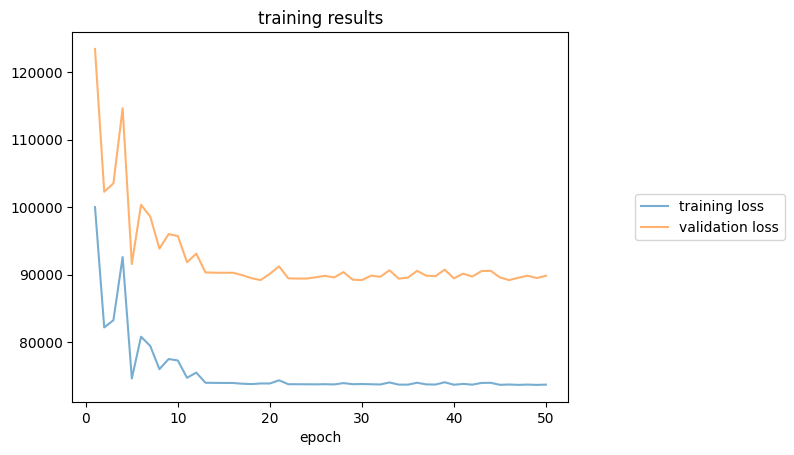

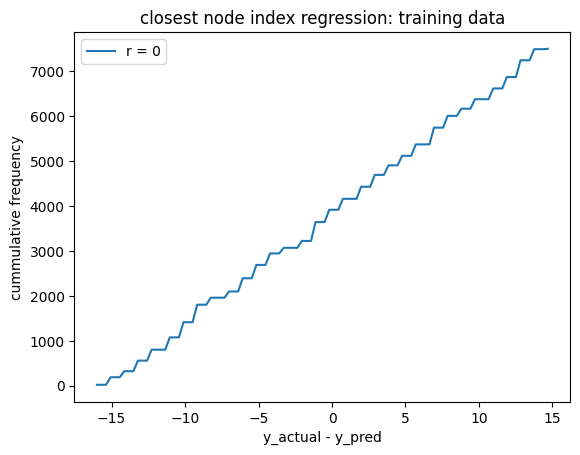

mean difference per seed set =  [-0.10266667]
mean difference per seed node =  [-9. -9. -9. ...  7.  7.  7.]


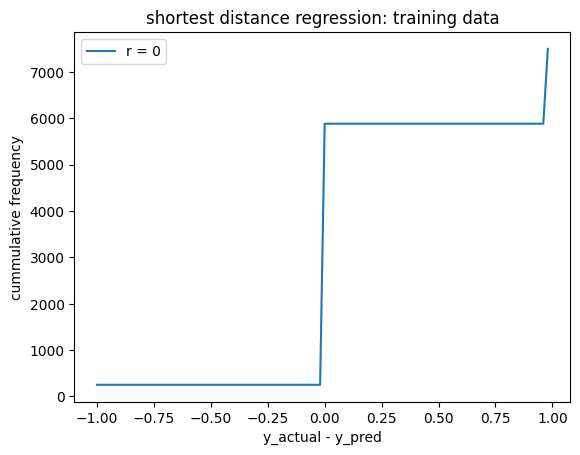

mean difference per seed set =  [0.18226667]
mean difference per seed node =  [1. 0. 0. ... 0. 1. 0.]


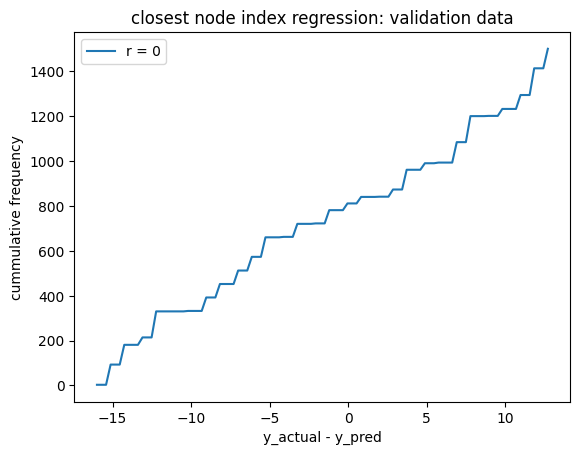

mean difference per seed set =  [-0.79333335]
mean difference per seed node =  [13. 13. 13. ... 13. 13. 13.]


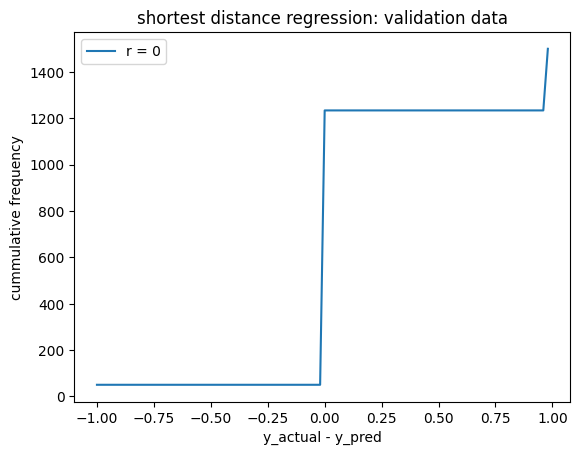

mean difference per seed set =  [0.144]
mean difference per seed node =  [ 0.  0.  0. ...  0. -1.  0.]


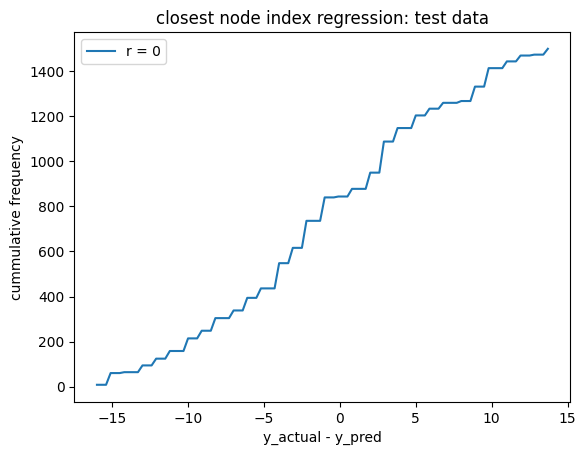

mean difference per seed set =  [-0.79333335]
mean difference per seed node =  [ 3.  4.  4. ... -1. -1. -1.]


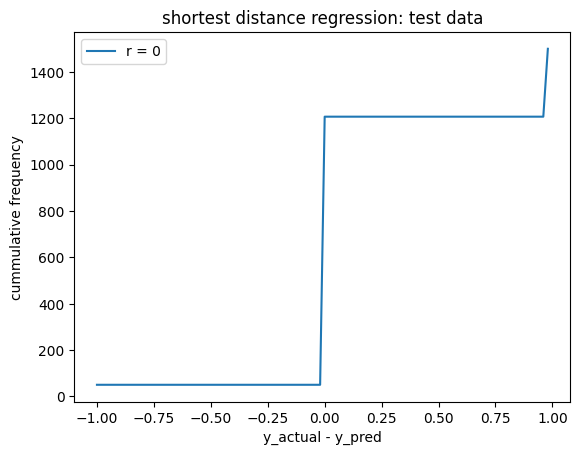

mean difference per seed set =  [0.162]
mean difference per seed node =  [0. 0. 0. ... 0. 0. 1.]


In [31]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.8)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)


Epoch: 010, Training Loss (MSE): 9901.4023, Validation Loss (MSE): 8007.4111
Epoch: 020, Training Loss (MSE): 9901.4072, Validation Loss (MSE): 8007.4043
Epoch: 030, Training Loss (MSE): 9901.4121, Validation Loss (MSE): 8007.4053
Epoch: 040, Training Loss (MSE): 9901.6484, Validation Loss (MSE): 8007.3281
Epoch: 050, Training Loss (MSE): 4299.4800, Validation Loss (MSE): 3556.9814
Test Loss (MSE): 2824.092773


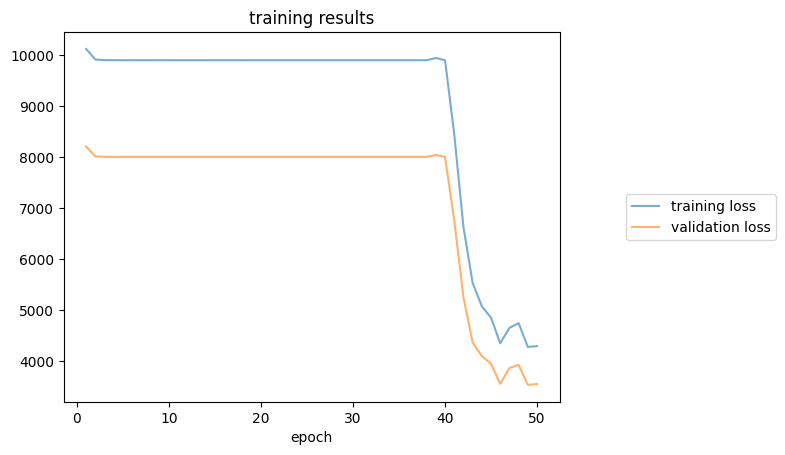

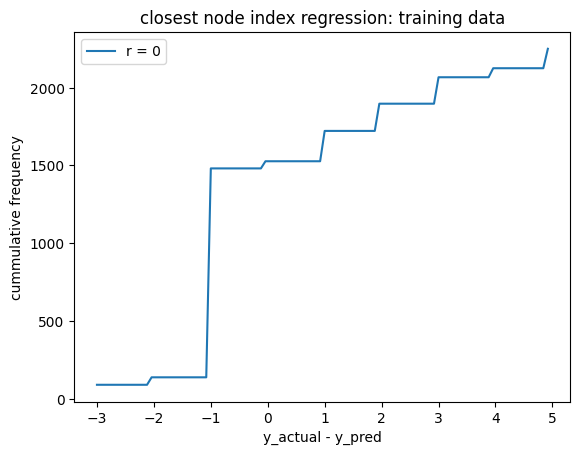

mean difference per seed set =  [0.09022222]
mean difference per seed node =  [ 1. -1. -1. ...  1. -1.  1.]


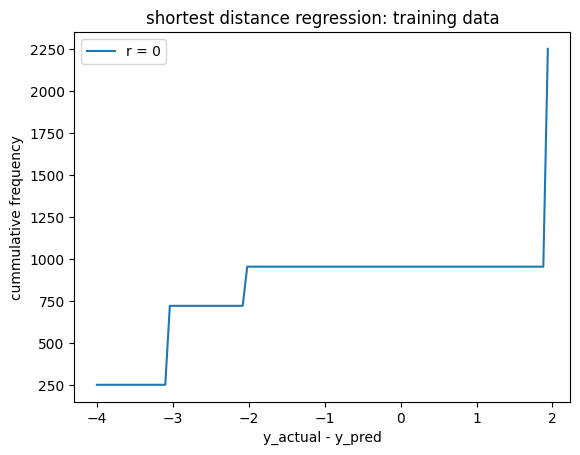

mean difference per seed set =  [-0.12533334]
mean difference per seed node =  [-3.  2.  2. ... -3.  2. -2.]


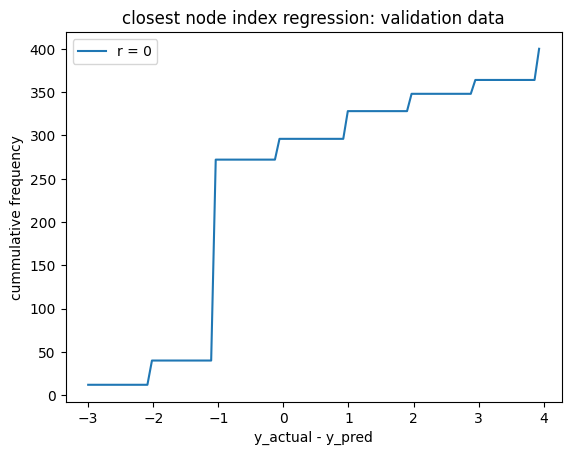

mean difference per seed set =  [-0.15]
mean difference per seed node =  [-1. -1. -1.  3. -1.  3.  3.  3. -1. -1. -1.  4. -1.  4.  4.  4. -1. -1.
 -1.  0. -1.  0.  0.  0. -1. -1. -1.  0. -1.  0.  0.  0. -1. -1. -1.  3.
 -1.  3.  3.  3. -1. -1. -1.  0. -1.  0.  0.  0.  1.  1.  1. -1.  1. -1.
 -1. -1. -1. -1. -1.  2. -1.  2.  2.  2. -2. -2. -2. -1. -2. -1. -1. -1.
 -1. -1. -1.  4. -1.  4.  4.  4. -1. -1. -1.  4. -1.  4.  4.  4. -2. -2.
 -2. -1. -2. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  4.
 -1.  4.  4.  4. -1. -1. -1.  0. -1.  0.  0.  0. -1. -1. -1.  4. -1.  4.
  4.  4. -1. -1. -1.  4. -1.  4.  4.  4. -1. -1. -1.  3. -1.  3.  3.  3.
 -1. -1. -1.  2. -1.  2.  2.  2.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  4.
 -1.  4.  4.  4. -1. -1. -1.  0. -1.  0.  0.  0. -1. -1. -1.  2. -1.  2.
  2.  2. -1. -1. -1.  3. -1.  3.  3.  3. -3. -3. -3. -1. -3. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -2. -2. -2. -1. -2

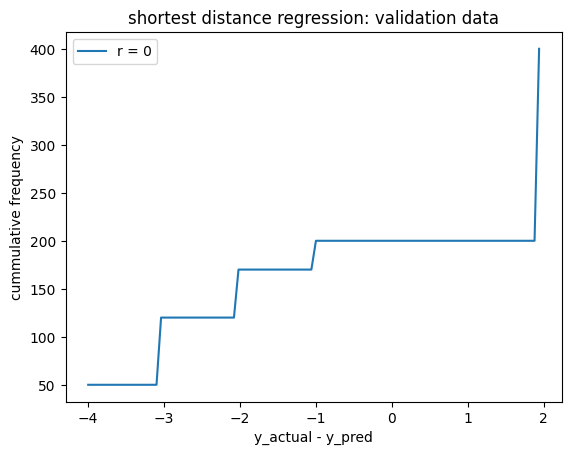

mean difference per seed set =  [-0.35]
mean difference per seed node =  [ 2.  2.  2. -3.  2. -3. -4. -2.  2.  2.  2. -1.  2. -3. -2. -4.  2.  2.
  2. -4.  2. -2. -3. -1.  2.  2.  2. -4.  2. -2. -3. -1.  2.  2.  2. -3.
  2. -3. -4. -2.  2.  2.  2. -4.  2. -2. -3. -1. -2. -1. -3.  2. -4.  2.
  2.  2.  2.  2.  2. -2.  2. -4. -3. -3. -3. -4. -2.  2. -1.  2.  2.  2.
  2.  2.  2. -1.  2. -3. -2. -4.  2.  2.  2. -1.  2. -3. -2. -4. -3. -4.
 -2.  2. -1.  2.  2.  2. -2. -1. -3.  2. -4.  2.  2.  2.  2.  2.  2. -1.
  2. -3. -2. -4.  2.  2.  2. -4.  2. -2. -3. -1.  2.  2.  2. -1.  2. -3.
 -2. -4.  2.  2.  2. -1.  2. -3. -2. -4.  2.  2.  2. -3.  2. -3. -4. -2.
  2.  2.  2. -2.  2. -4. -3. -3. -2. -1. -3.  2. -4.  2.  2.  2. -3. -2.
 -4.  2. -3.  2.  2.  2. -2. -1. -3.  2. -4.  2.  2.  2.  2.  2.  2. -1.
  2. -3. -2. -4.  2.  2.  2. -4.  2. -2. -3. -1.  2.  2.  2. -2.  2. -4.
 -3. -3.  2.  2.  2. -3.  2. -3. -4. -2. -4. -3. -3.  2. -2.  2.  2.  2.
 -3. -2. -4.  2. -3.  2.  2.  2. -3. -4. -2.  2. -1

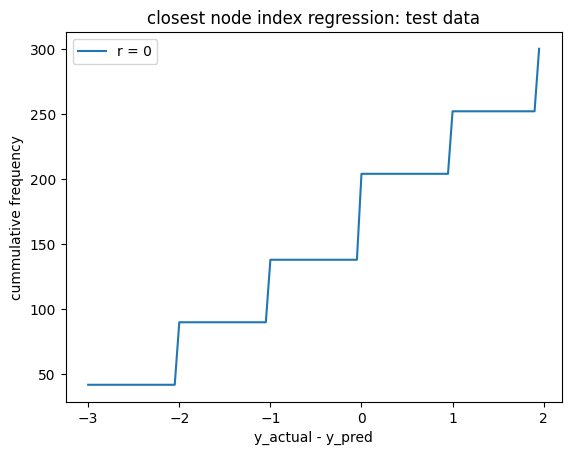

mean difference per seed set =  [-0.42]
mean difference per seed node =  [ 1.  1.  1.  1.  1.  1. -3. -3. -3. -3. -3. -3.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -2. -2. -2. -2. -2. -2.
  2.  2.  2.  2.  2.  2. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -1. -1. -1. -1. -1. -1. -2. -2. -2. -2. -2. -2.  1.  1.  1.  1.  1.  1.
  2.  2.  2.  2.  2.  2. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.
 -3. -3. -3. -3. -3. -3. -2. -2. -2. -2. -2. -2.  1.  1.  1.  1.  1.  1.
 -2. -2. -2. -2. -2. -2.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.
  0.  0.  0.  0.  0.  0. -1. -1. -1. -1. -1. -1.  2.  2.  2.  2.  2.  2.
  0.  0.  0.  0.  0.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  0.  0.  0.  0.  0.  0. -3. -3. -3. -3. -3. -3.  0.  0.  0.  0.  0.  0.
  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0

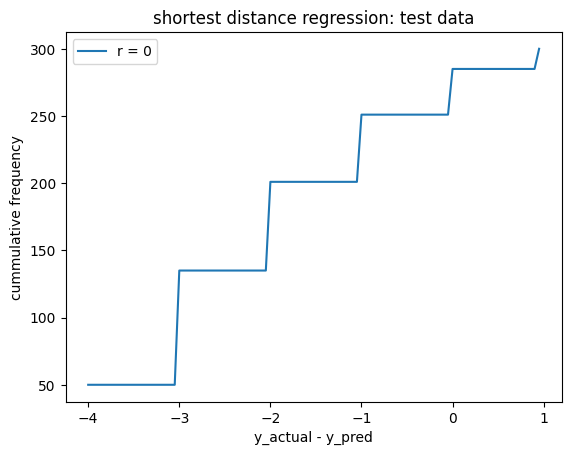

mean difference per seed set =  [-2.0733333]
mean difference per seed node =  [ 0. -2. -3. -1. -4. -3. -4. -2.  1. -3.  0. -1.  0. -2. -3. -1. -4. -3.
  1. -1. -4.  0. -3. -2.  1. -1. -4.  0. -3. -2.  1. -1. -4.  0. -3. -2.
  0. -2. -3. -1. -4. -3.  1. -1. -4.  0. -3. -2. -2. -4. -1. -3. -2. -3.
 -1. -3. -2. -2. -3. -4. -4. -2.  1. -3.  0. -1. -4. -2.  1. -3.  0. -1.
  1. -1. -4.  0. -3. -2. -2. -4. -1. -3. -2. -3.  0. -2. -3. -1. -4. -3.
 -1. -3. -2. -2. -3. -4.  1. -1. -4.  0. -3. -2. -3. -3.  0. -4. -1. -2.
 -3. -3.  0. -4. -1. -2.  1. -1. -4.  0. -3. -2. -3. -3.  0. -4. -1. -2.
 -4. -2.  1. -3.  0. -1. -2. -4. -1. -3. -2. -3.  0. -2. -3. -1. -4. -3.
 -2. -4. -1. -3. -2. -3.  0. -2. -3. -1. -4. -3. -1. -3. -2. -2. -3. -4.
 -3. -3.  0. -4. -1. -2.  1. -1. -4.  0. -3. -2. -1. -3. -2. -2. -3. -4.
 -3. -3.  0. -4. -1. -2. -1. -3. -2. -2. -3. -4. -1. -3. -2. -2. -3. -4.
 -3. -3.  0. -4. -1. -2. -4. -2.  1. -3.  0. -1. -3. -3.  0. -4. -1. -2.
  0. -2. -3. -1. -4. -3. -3. -3.  0. -4. -1. -

In [32]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,10,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 33706.0703, Validation Loss (MSE): 30155.0898
Epoch: 020, Training Loss (MSE): 33882.9453, Validation Loss (MSE): 29498.6250
Epoch: 030, Training Loss (MSE): 33466.5898, Validation Loss (MSE): 29268.3340
Epoch: 040, Training Loss (MSE): 33430.0938, Validation Loss (MSE): 29142.0117
Epoch: 050, Training Loss (MSE): 33392.4961, Validation Loss (MSE): 29073.6035
Test Loss (MSE): 27018.976562


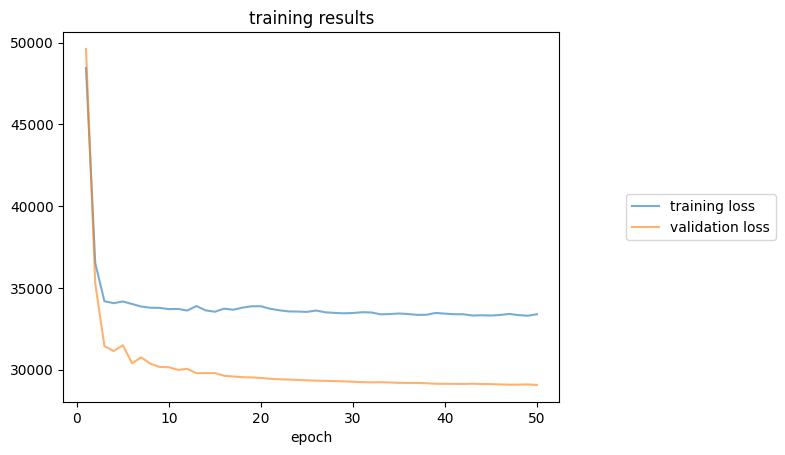

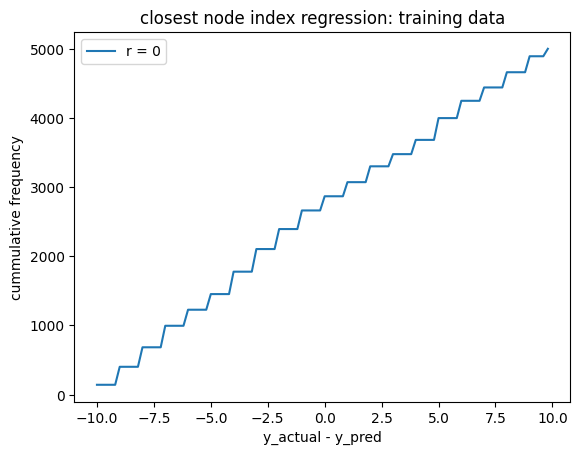

mean difference per seed set =  [-0.498]
mean difference per seed node =  [-1. -1. -2. ... -8. -7. -7.]


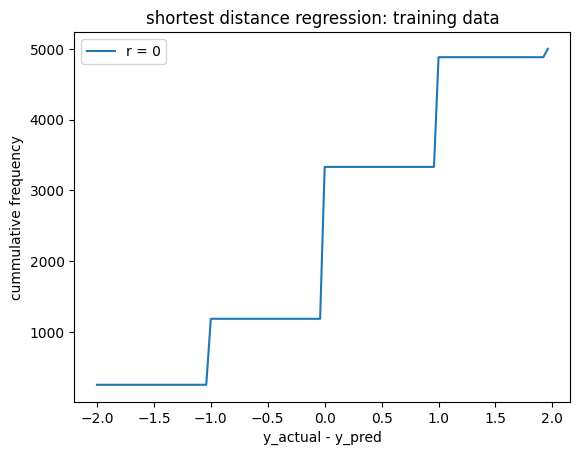

mean difference per seed set =  [0.0712]
mean difference per seed node =  [2. 0. 1. ... 0. 1. 0.]


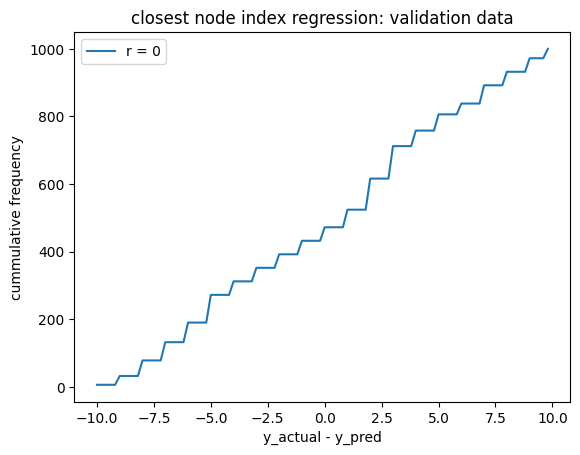

mean difference per seed set =  [0.28]
mean difference per seed node =  [  5.   4.   5.   4.   5.   5.   5.   4.   4.   5.   5.   5.   4.   5.
   5.   5.   4.   5.   5.   5.  -7.  -8.  -7.  -8.  -7.  -7.  -7.  -8.
  -8.  -7.  -7.  -7.  -8.  -7.  -7.  -7.  -8.  -7.  -7.  -7.   3.   2.
   3.   2.   3.   3.   3.   2.   2.   3.   3.   3.   2.   3.   3.   3.
   2.   3.   3.   3.   2.   1.   2.   1.   2.   2.   2.   1.   1.   2.
   2.   2.   1.   2.   2.   2.   1.   2.   2.   2.  -1.  -2.  -1.  -2.
  -1.  -1.  -1.  -2.  -2.  -1.  -1.  -1.  -2.  -1.  -1.  -1.  -2.  -1.
  -1.  -1.  -3.  -4.  -3.  -4.  -3.  -3.  -3.  -4.  -4.  -3.  -3.  -3.
  -4.  -3.  -3.  -3.  -4.  -3.  -3.  -3.   3.   2.   3.   2.   3.   3.
   3.   2.   2.   3.   3.   3.   2.   3.   3.   3.   2.   3.   3.   3.
  -6.  -7.  -6.  -7.  -6.  -6.  -6.  -7.  -7.  -6.  -6.  -6.  -7.  -6.
  -6.  -6.  -7.  -6.  -6.  -6.  10.   9.  10.   9.  10.  10.  10.   9.
   9.  10.  10.  10.   9.  10.  10.  10.   9.  10.  10.  10.   4.   3.
   4.

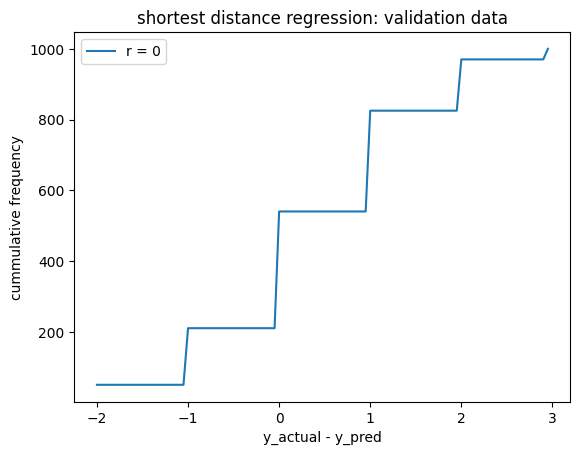

mean difference per seed set =  [0.405]
mean difference per seed node =  [ 1.  1.  1.  0.  1.  1.  2.  0.  0.  1.  2. -1. -1.  2. -2.  1.  0.  1.
  1.  1.  0.  0. -2.  1.  2. -1.  3. -1.  1.  1.  1.  1.  0.  3.  1.  2.
  1.  2.  2.  0.  0.  0.  0. -1.  0.  0.  2. -1. -1.  0.  1. -1. -2.  2.
 -1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0. -1.  0.  1. -2.
 -1.  1. -1.  0. -1.  0.  0.  0.  0.  0.  1. -1. -1.  1.  2.  0. -2. -1.
  1. -1. -1.  2.  0. -1.  0.  1.  1.  0.  1.  1.  3.  2.  3.  2. -2.  2.
  2.  2.  2.  1.  2.  2.  2.  3.  0.  1. -1.  1.  0.  0.  0. -1.  0.  0.
  2. -1. -1.  0.  1. -1. -2.  2. -1.  0.  0.  1.  1.  0.  0. -1.  1. -2.
  0.  0.  2.  0. -1. -1.  0.  0. -1.  2.  0.  0.  0.  1.  1. -1.  0.  0.
  0. -1.  1.  0.  1. -1.  0.  0.  1.  0.  0.  1.  1.  1. -1.  0.  0. -2.
  1.  1.  3.  2.  3.  2.  2.  2.  2.  2.  2.  1.  2. -2.  2.  3.  0. -1.
  1.  1.  1.  1.  1.  0.  1.  1.  2.  0.  0.  1.  2. -1. -1.  2. -2.  1.
  0.  1.  1.  1.  0.  0. -2.  1.  2. -1.  3. -1.  1

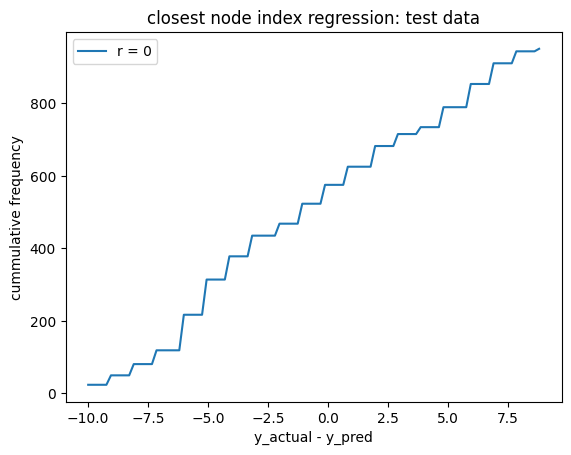

mean difference per seed set =  [-0.93157893]
mean difference per seed node =  [  0.  -1.  -1.  -1.   0.   0.  -1.   0.   0.   0.  -1.  -1.  -1.  -1.
  -1.  -1.  -1.   0.  -1.  -6.  -7.  -7.  -7.  -6.  -6.  -7.  -6.  -6.
  -6.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -6.  -7.  -5.  -6.  -6.  -6.
  -5.  -5.  -6.  -5.  -5.  -5.  -6.  -6.  -6.  -6.  -6.  -6.  -6.  -5.
  -6.   7.   6.   6.   6.   7.   7.   6.   7.   7.   7.   6.   6.   6.
   6.   6.   6.   6.   7.   6.  -2.  -3.  -3.  -3.  -2.  -2.  -3.  -2.
  -2.  -2.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -2.  -3.   1.   0.   0.
   0.   1.   1.   0.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.
   1.   0.   1.   0.   0.   0.   1.   1.   0.   1.   1.   1.   0.   0.
   0.   0.   0.   0.   0.   1.   0.   5.   4.   4.   4.   5.   5.   4.
   5.   5.   5.   4.   4.   4.   4.   4.   4.   4.   5.   4.  -6.  -7.
  -7.  -7.  -6.  -6.  -7.  -6.  -6.  -6.  -7.  -7.  -7.  -7.  -7.  -7.
  -7.  -6.  -7.  -5.  -6.  -6.  -6.  -5.  -5.  -6.  -5.  -5.  -5.  -6

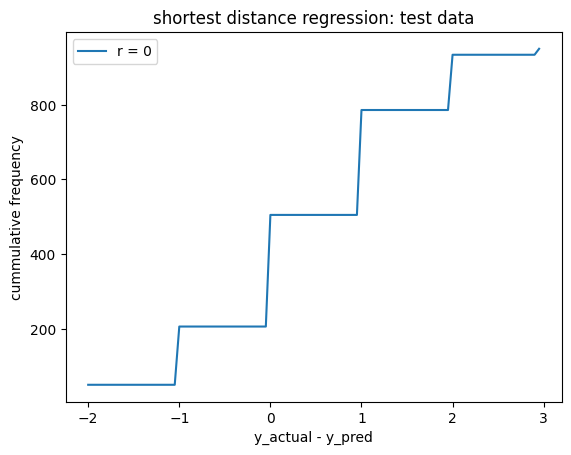

mean difference per seed set =  [0.38842106]
mean difference per seed node =  [ 2.  0.  2.  2.  0.  1.  0.  2.  3. -2.  1.  1. -1.  1.  0. -1.  1.  2.
  2.  1.  0. -1. -2.  0.  0.  0.  0.  0.  2.  0.  0.  1. -1.  1.  1. -1.
 -1.  0.  1.  0.  1.  0. -2.  2.  1.  0.  2.  0.  0.  0.  0.  1. -1. -1.
 -1.  1.  0.  2.  0.  0. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  0.  0.
  0. -2.  0. -1.  2.  1.  0.  0.  0.  2.  2. -2.  1.  2.  1.  0.  2.  1.
  1.  1. -1.  1. -1. -1.  0. -1.  0.  0.  2.  1.  1.  0.  1. -2.  1.  0.
  1. -1.  1.  1.  1.  0. -1.  0. -1.  0.  0.  2.  1.  1.  0.  1. -2.  1.
  0.  1. -1.  1.  1.  1.  0.  0. -1.  0.  1. -1.  1.  0.  1.  1.  0. -1.
  0. -1.  0. -2.  0.  0.  1.  1.  1.  0. -1. -2.  0.  0.  0.  0.  0.  2.
  0.  0.  1. -1.  1.  1. -1. -1.  0.  1.  0.  1.  0. -2.  2.  1.  0.  2.
  0.  0.  0.  0.  1. -1. -1. -1.  1.  0.  1.  0.  1.  1.  0.  0. -1.  2.
  2. -1.  0.  1. -2.  0. -1.  0.  1.  1.  2.  2. -1.  2.  1. -1.  2.  1.
  1.  3. -1.  1.  0.  0.  0.  0. -2.  0.  1.  

In [33]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,20,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)


Epoch: 010, Training Loss (MSE): 154417.0312, Validation Loss (MSE): 154245.1406
Epoch: 020, Training Loss (MSE): 146030.9531, Validation Loss (MSE): 143249.0156
Epoch: 030, Training Loss (MSE): 140577.5781, Validation Loss (MSE): 133161.5469
Epoch: 040, Training Loss (MSE): 139479.4219, Validation Loss (MSE): 131166.1875
Epoch: 050, Training Loss (MSE): 138952.8906, Validation Loss (MSE): 129900.4062
Test Loss (MSE): 122110.570312


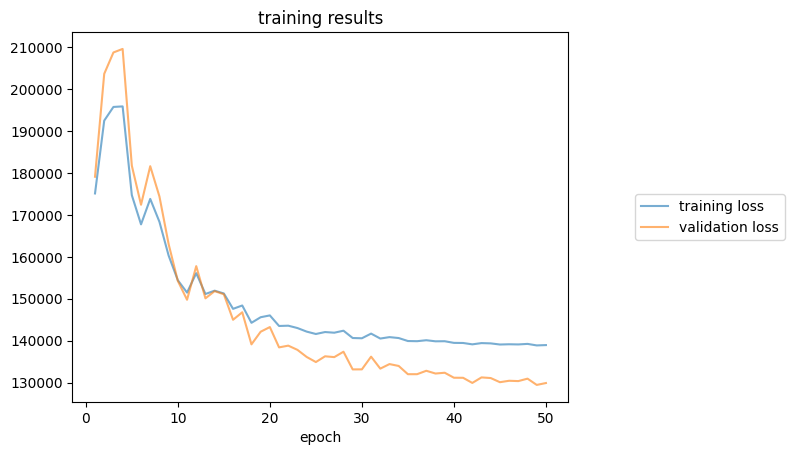

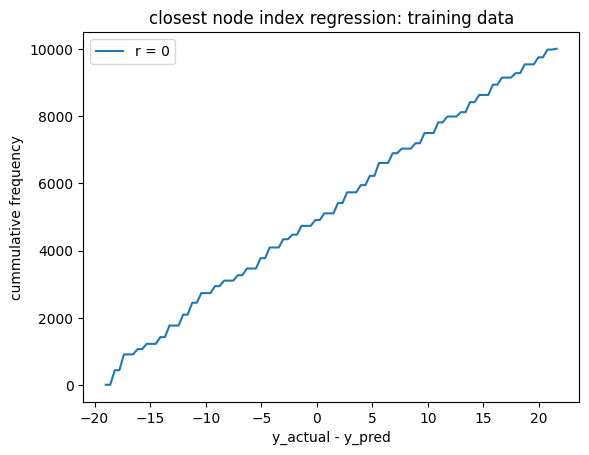

mean difference per seed set =  [0.551]
mean difference per seed node =  [-4. -4. -3. ...  5.  5.  5.]


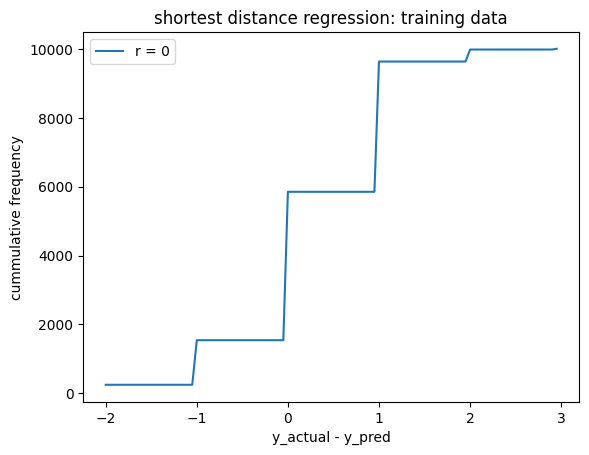

mean difference per seed set =  [0.2748]
mean difference per seed node =  [1. 1. 1. ... 0. 2. 1.]


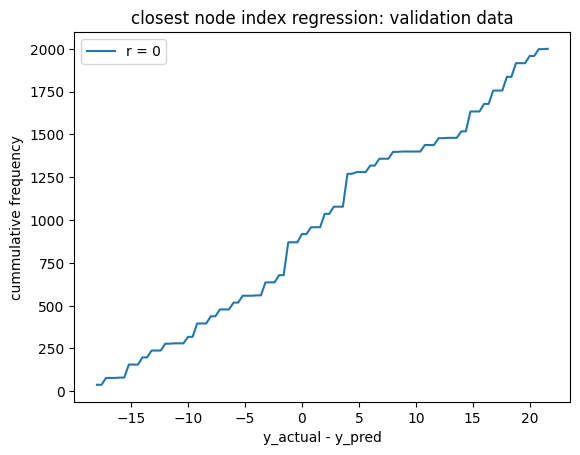

mean difference per seed set =  [2.55]
mean difference per seed node =  [19. 19. 19. ... -9. -9. -9.]


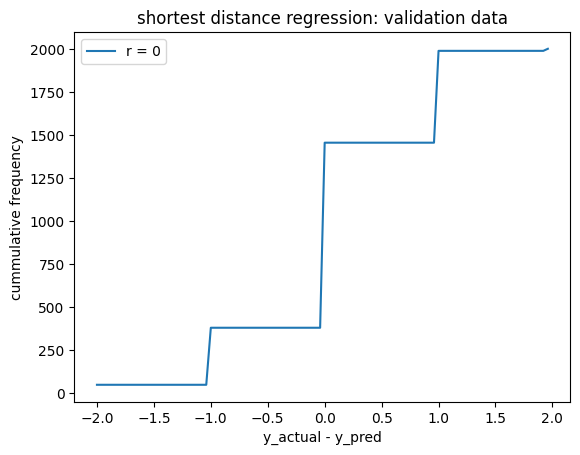

mean difference per seed set =  [0.063]
mean difference per seed node =  [ 1.  0.  0. ...  0. -1. -1.]


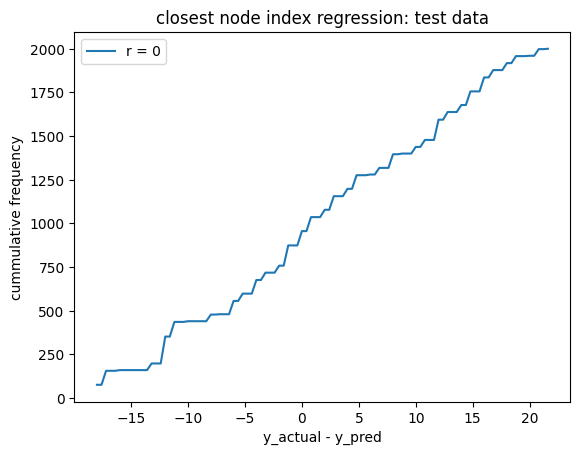

mean difference per seed set =  [1.53]
mean difference per seed node =  [-13. -13. -13. ...  15.  14.  14.]


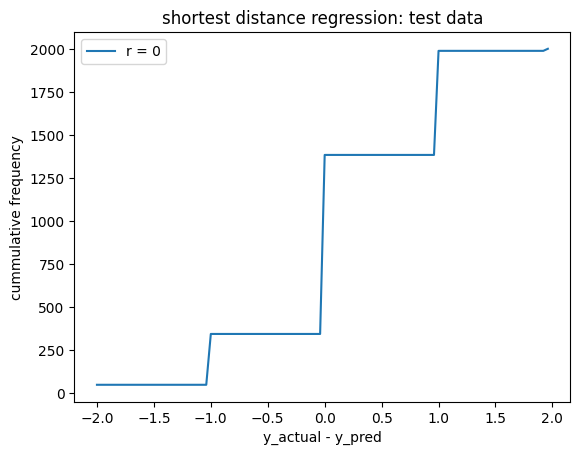

mean difference per seed set =  [0.1165]
mean difference per seed node =  [ 1.  0. -1. ...  1.  1.  0.]


In [34]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,40,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 560972.0000, Validation Loss (MSE): 723389.0000
Epoch: 020, Training Loss (MSE): 549701.2500, Validation Loss (MSE): 735967.3125
Epoch: 030, Training Loss (MSE): 549556.8125, Validation Loss (MSE): 741200.3750
Epoch: 040, Training Loss (MSE): 550302.8125, Validation Loss (MSE): 745837.2500
Epoch: 050, Training Loss (MSE): 550511.8750, Validation Loss (MSE): 747889.6875
Test Loss (MSE): 578375.812500


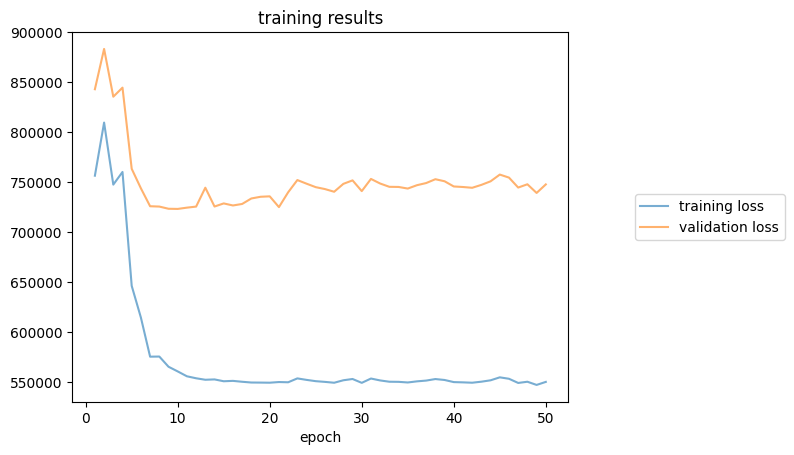

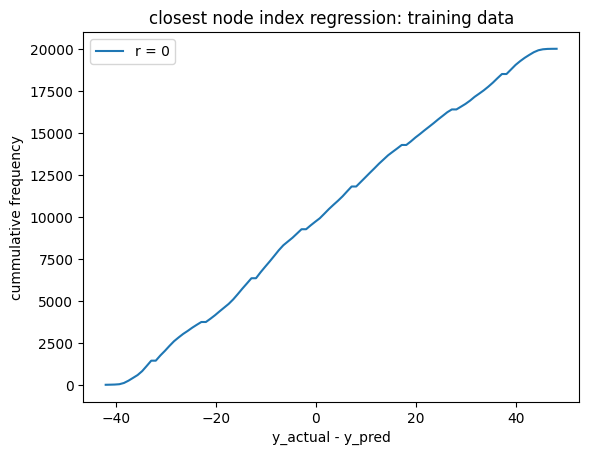

mean difference per seed set =  [2.6175]
mean difference per seed node =  [31. 32. 29. ... 15. 17. 14.]


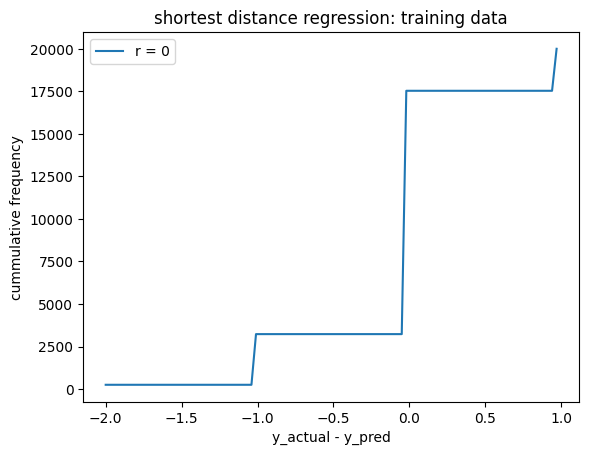

mean difference per seed set =  [-0.05045]
mean difference per seed node =  [ 0.  0.  0. ...  0. -1.  0.]


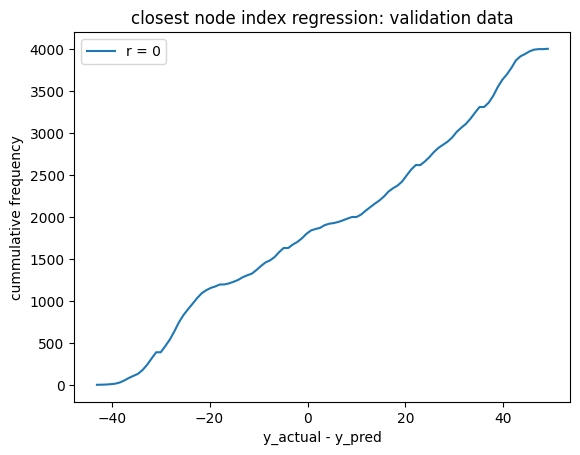

mean difference per seed set =  [6.225]
mean difference per seed node =  [-19. -24. -21. ...   0.  -5.  -3.]


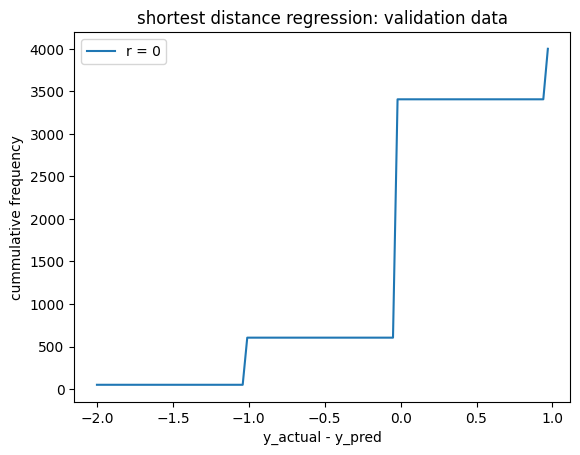

mean difference per seed set =  [-0.015]
mean difference per seed node =  [ 1. -1.  0. ... -1.  0.  0.]


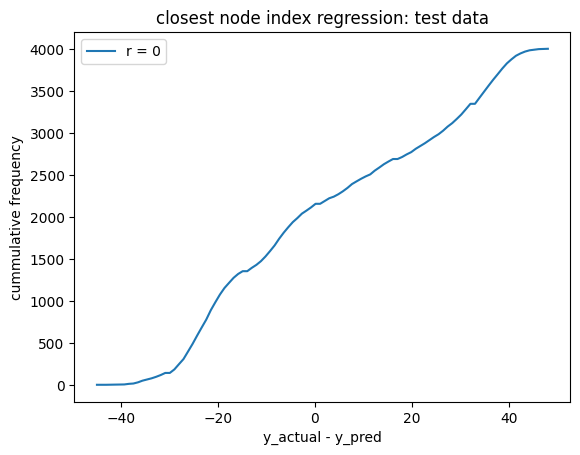

mean difference per seed set =  [2.96]
mean difference per seed node =  [ 33.  31.  37. ...  -8. -10. -19.]


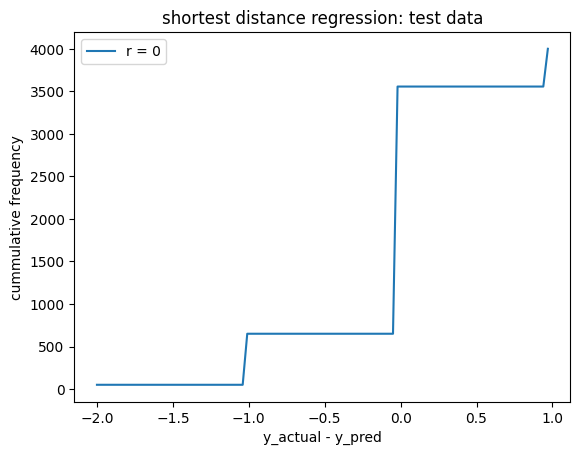

mean difference per seed set =  [-0.064]
mean difference per seed node =  [ 0. -1.  0. ...  0.  0.  0.]


In [35]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,80,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 2310493.5000, Validation Loss (MSE): 1867866.5000
Epoch: 020, Training Loss (MSE): 2295673.2500, Validation Loss (MSE): 1841831.1250
Epoch: 030, Training Loss (MSE): 2295561.7500, Validation Loss (MSE): 1843625.1250
Epoch: 040, Training Loss (MSE): 2288654.5000, Validation Loss (MSE): 1828291.1250
Epoch: 050, Training Loss (MSE): 2286400.2500, Validation Loss (MSE): 1822615.7500
Test Loss (MSE): 2150088.000000


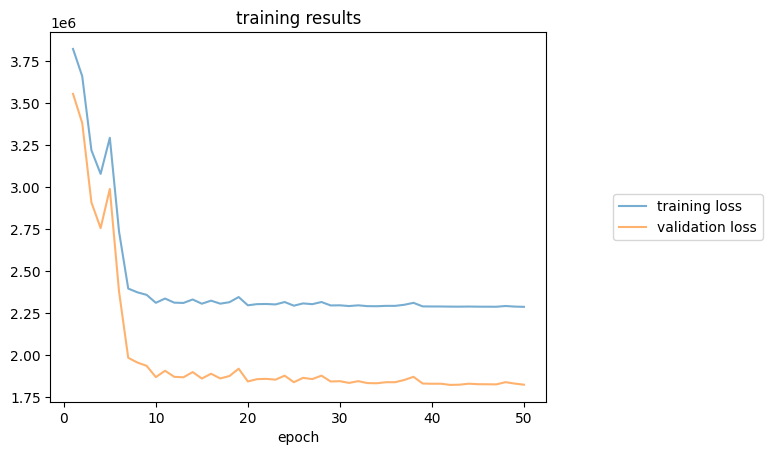

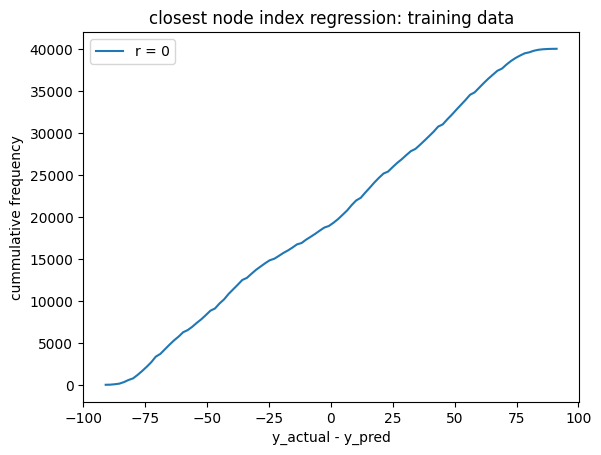

mean difference per seed set =  [0.66475]
mean difference per seed node =  [-64. -54. -52. ...  -2.   4.   7.]


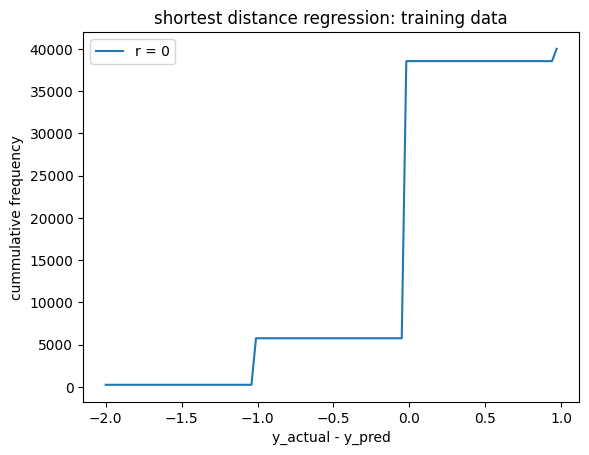

mean difference per seed set =  [-0.113675]
mean difference per seed node =  [ 0.  0. -1. ...  0.  0.  0.]


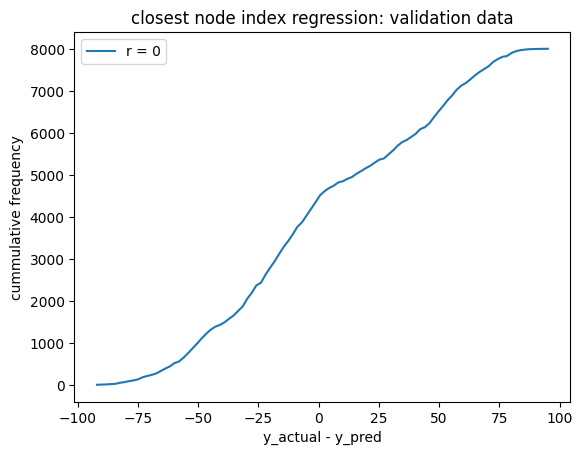

mean difference per seed set =  [3.32125]
mean difference per seed node =  [-14. -10. -17. ...  72.  65.  62.]


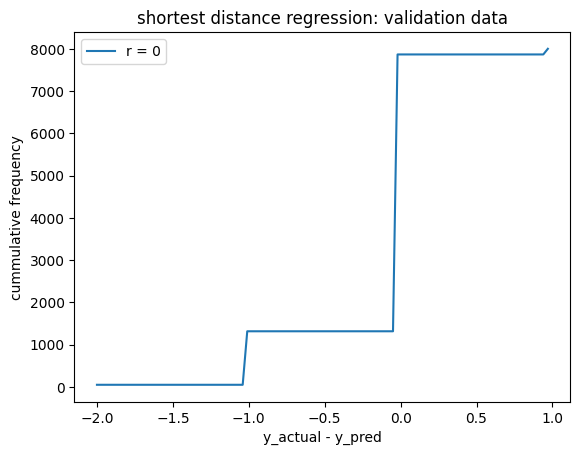

mean difference per seed set =  [-0.154]
mean difference per seed node =  [0. 0. 0. ... 0. 0. 0.]


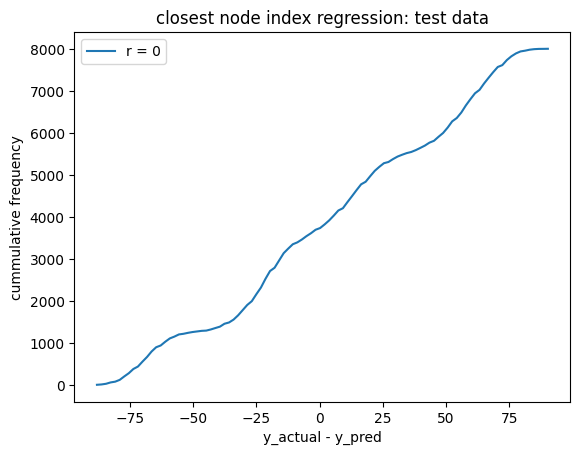

mean difference per seed set =  [5.93375]
mean difference per seed node =  [-23. -12. -22. ...  52.  54.  46.]


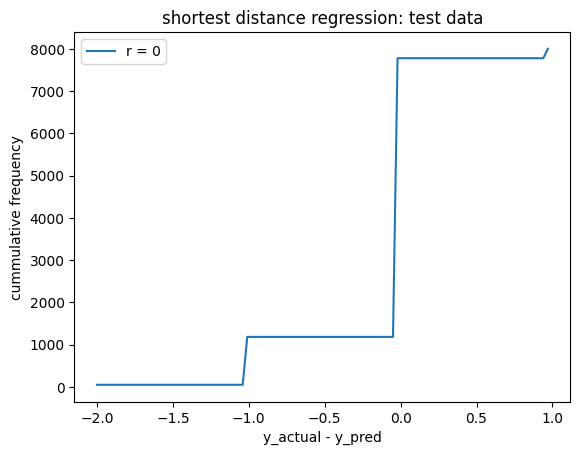

mean difference per seed set =  [-0.12625]
mean difference per seed node =  [ 0.  0.  0. ... -1.  0.  0.]


In [36]:
scale = 1000
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,160,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 6508.0283, Validation Loss (MSE): 6910.5078
Epoch: 020, Training Loss (MSE): 6243.4727, Validation Loss (MSE): 6353.5815
Epoch: 030, Training Loss (MSE): 6146.8423, Validation Loss (MSE): 6037.4536
Epoch: 040, Training Loss (MSE): 6132.7661, Validation Loss (MSE): 6009.9575
Epoch: 050, Training Loss (MSE): 6125.0439, Validation Loss (MSE): 5984.3774
Test Loss (MSE): 13690.472656


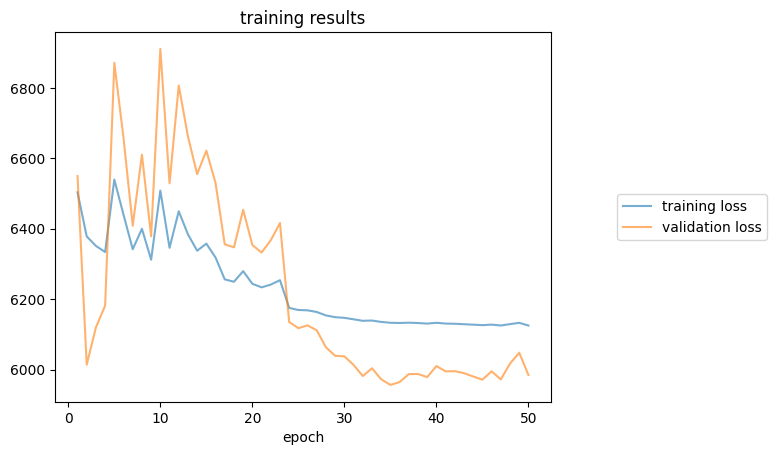

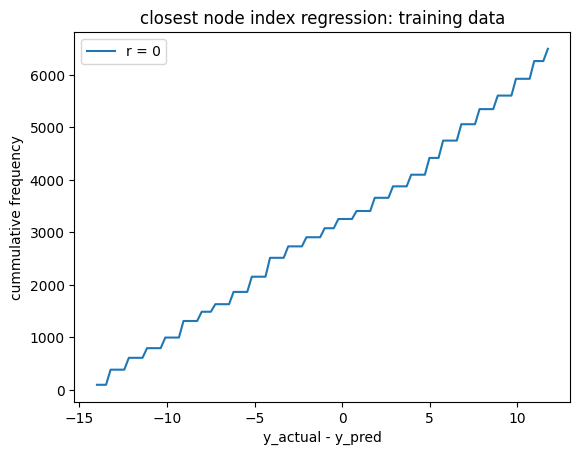

mean difference per seed set =  [-0.03969231]
mean difference per seed node =  [-4. -5. -5. ... 11. 10. 11.]


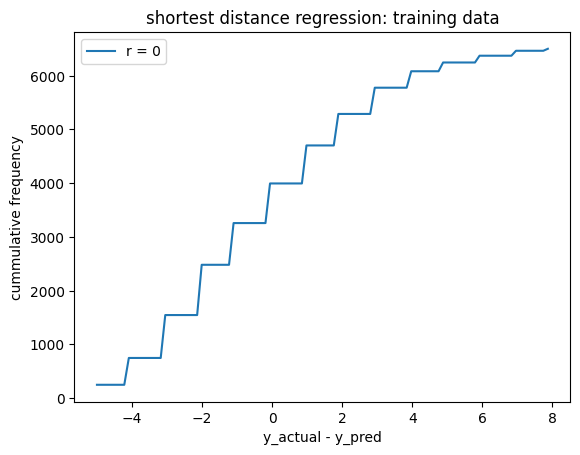

mean difference per seed set =  [-0.18584615]
mean difference per seed node =  [-1. -3.  0. ...  0. -5. -3.]


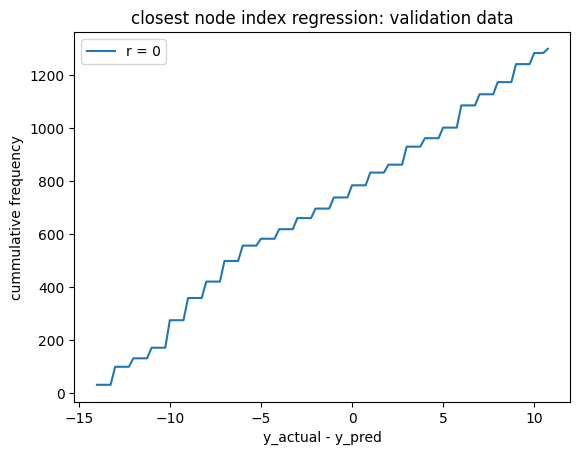

mean difference per seed set =  [-2.1646154]
mean difference per seed node =  [-2. -1. -1. ...  9.  8.  9.]


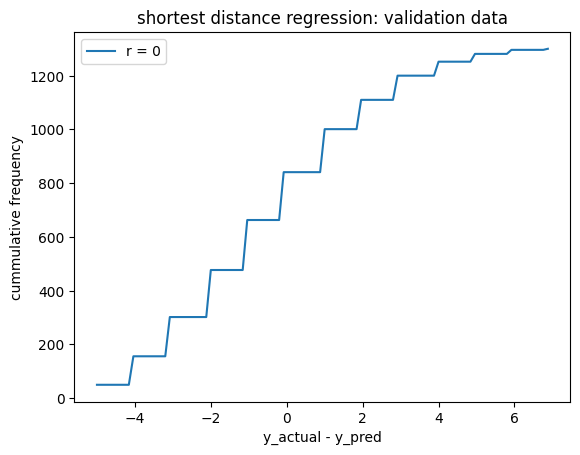

mean difference per seed set =  [-0.4069231]
mean difference per seed node =  [-1.  0.  0. ... -2. -1.  0.]


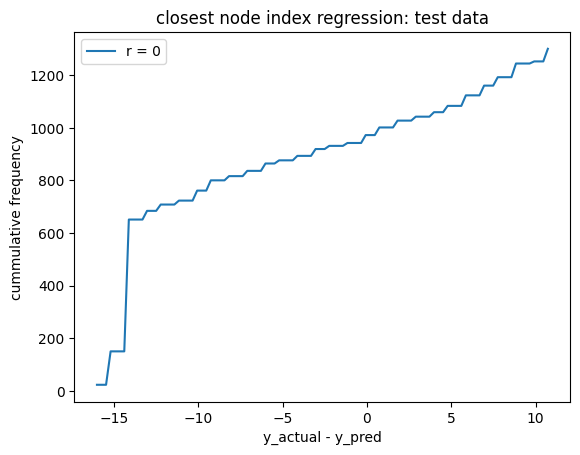

mean difference per seed set =  [-7.2553844]
mean difference per seed node =  [-15. -15.   9. ...  -4.  -3.  -3.]


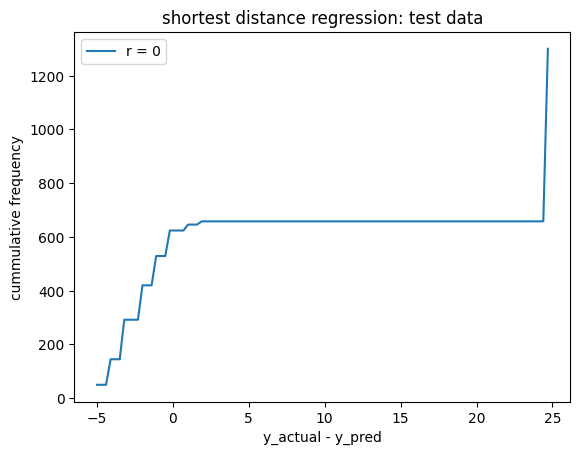

mean difference per seed set =  [11.276923]
mean difference per seed node =  [25. 25.  0. ... -4. -1. -4.]


In [37]:
## 100*MSE1 + MSE2
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.05)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 8501.4111, Validation Loss (MSE): 7266.6143
Epoch: 020, Training Loss (MSE): 8138.4292, Validation Loss (MSE): 7005.8906
Epoch: 030, Training Loss (MSE): 7881.9106, Validation Loss (MSE): 6833.6479
Epoch: 040, Training Loss (MSE): 7740.9751, Validation Loss (MSE): 6751.6841
Epoch: 050, Training Loss (MSE): 7692.8267, Validation Loss (MSE): 6726.9736
Test Loss (MSE): 5766.366699


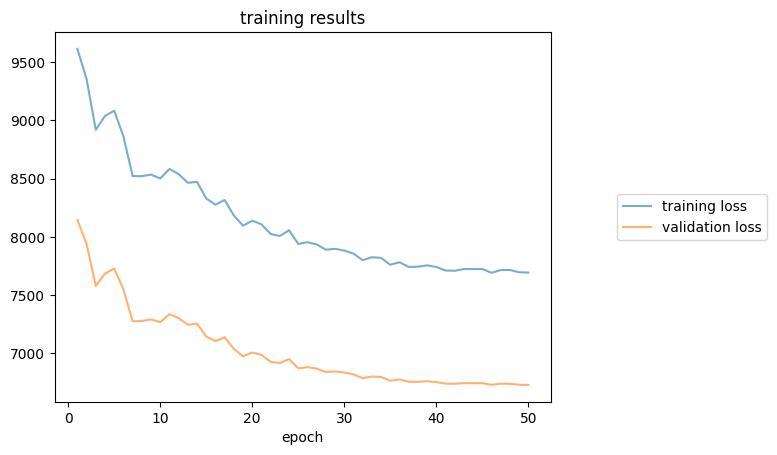

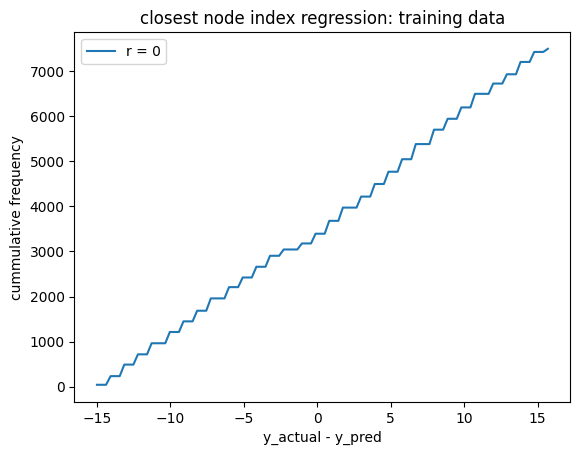

mean difference per seed set =  [0.964]
mean difference per seed node =  [16. 16. 15. ...  5.  6.  5.]


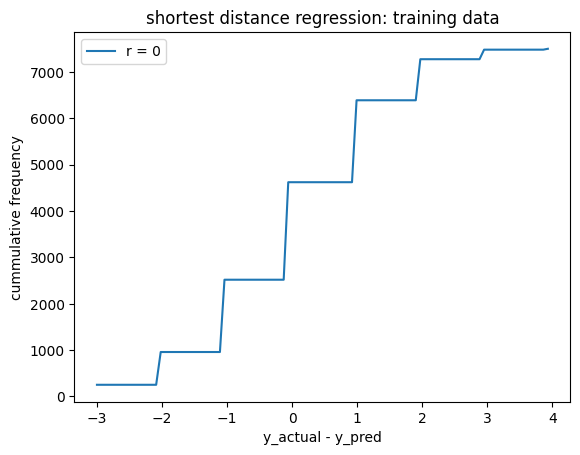

mean difference per seed set =  [0.068]
mean difference per seed node =  [ 0.  1.  0. ...  0. -1. -1.]


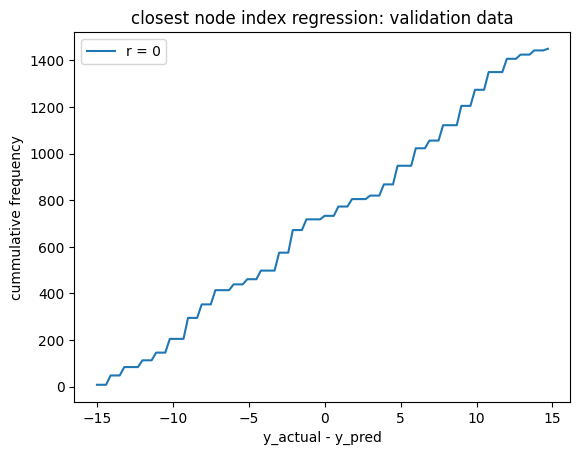

mean difference per seed set =  [0.32344827]
mean difference per seed node =  [ 9.  8. 10. ... -3. -3. -4.]


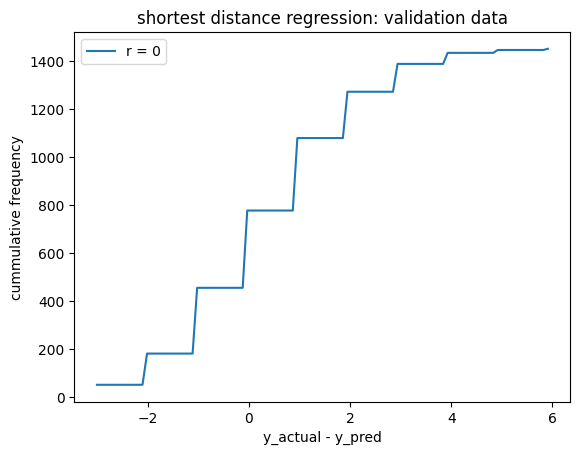

mean difference per seed set =  [0.43172413]
mean difference per seed node =  [ 0. -1.  2. ...  3.  1.  1.]


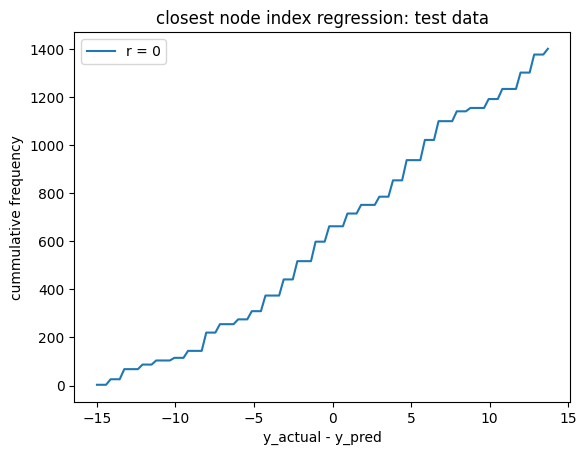

mean difference per seed set =  [1.3185714]
mean difference per seed node =  [-8. -7. -8. ... 10. 10.  9.]


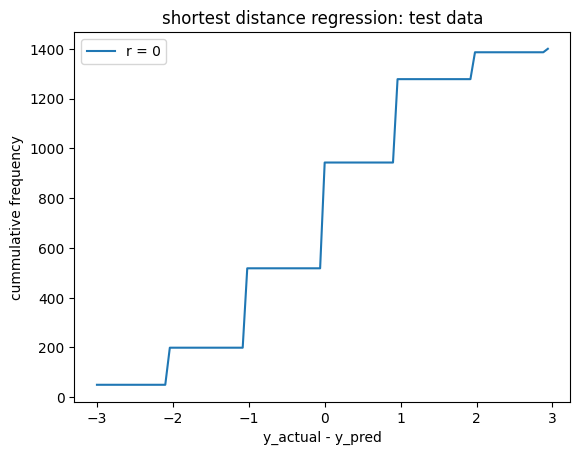

mean difference per seed set =  [-0.12428571]
mean difference per seed node =  [ 0.  0.  2. ...  1. -2. -1.]


In [38]:
## 100*MSE1 + MSE2
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.1)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 7336.1216, Validation Loss (MSE): 7857.5781
Epoch: 020, Training Loss (MSE): 7254.3862, Validation Loss (MSE): 7773.9766
Epoch: 030, Training Loss (MSE): 7206.7456, Validation Loss (MSE): 7759.5317
Epoch: 040, Training Loss (MSE): 7177.3491, Validation Loss (MSE): 7692.4209
Epoch: 050, Training Loss (MSE): 7158.7573, Validation Loss (MSE): 7671.0454
Test Loss (MSE): 9100.682617


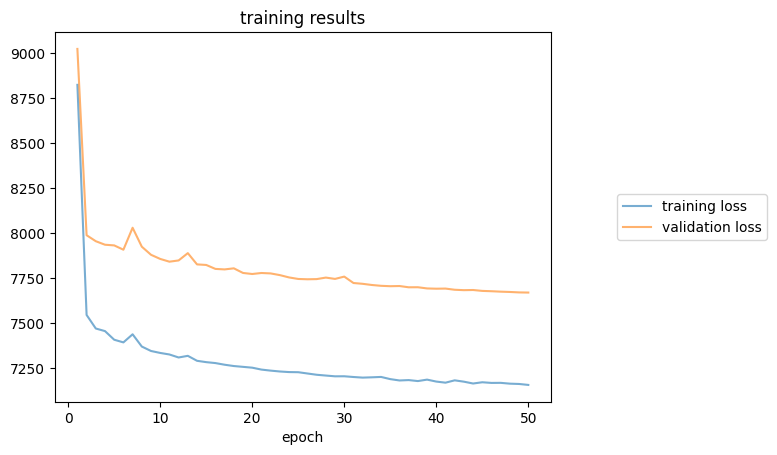

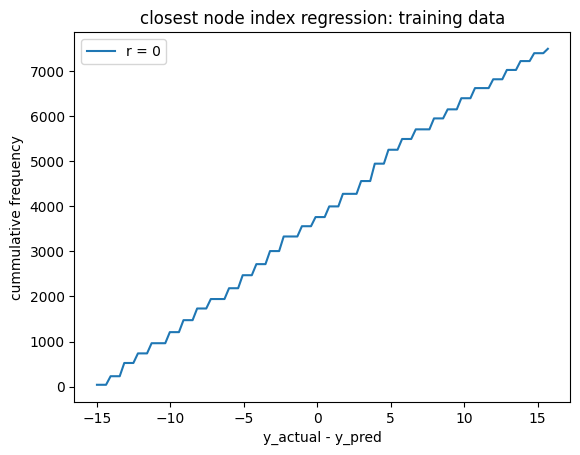

mean difference per seed set =  [0.29866666]
mean difference per seed node =  [-4. -6. -4. ...  2.  1.  2.]


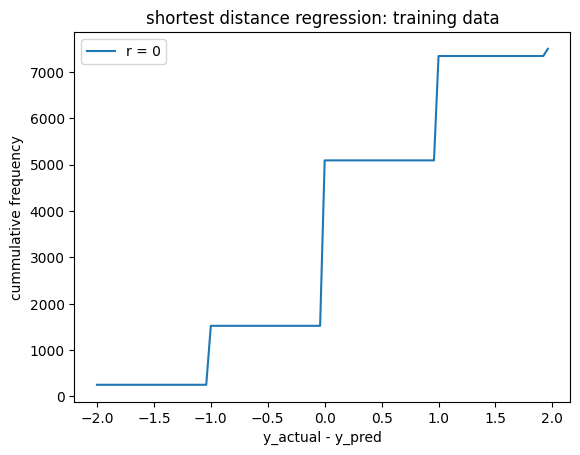

mean difference per seed set =  [0.1056]
mean difference per seed node =  [0. 0. 1. ... 1. 1. 0.]


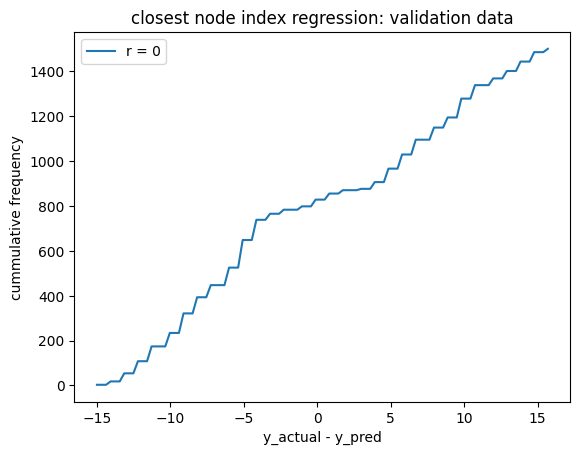

mean difference per seed set =  [-0.06]
mean difference per seed node =  [ -4.  -5.  -5. ... -11. -13. -11.]


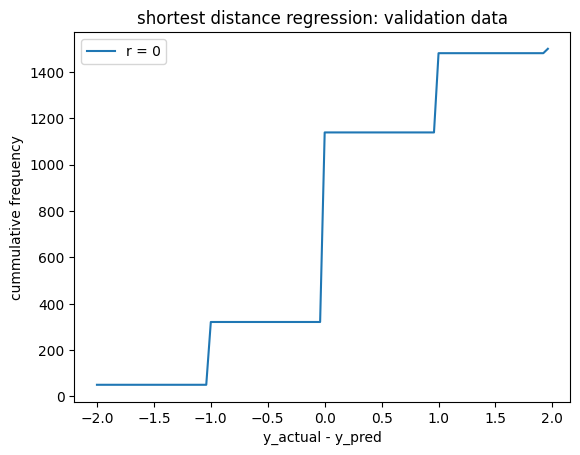

mean difference per seed set =  [0.006]
mean difference per seed node =  [ 0.  1. -1. ... -1.  0. -1.]


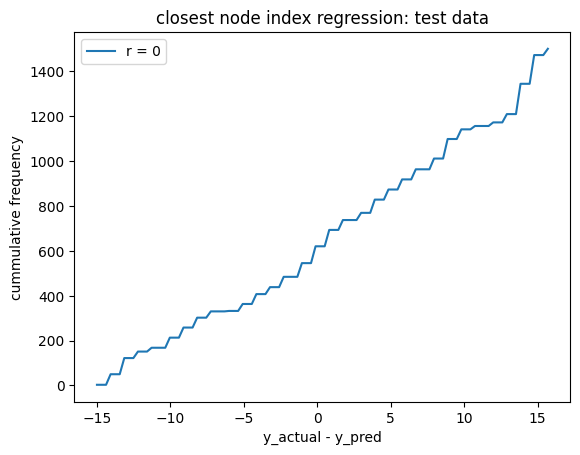

mean difference per seed set =  [2.5533333]
mean difference per seed node =  [10.  9.  9. ...  0.  0. -1.]


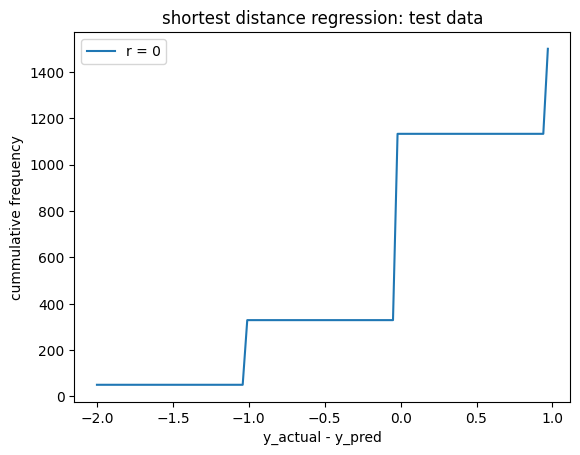

mean difference per seed set =  [-0.008]
mean difference per seed node =  [-1.  1.  0. ...  0.  0. -1.]


In [39]:
## 100*MSE1 + MSE2
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.2)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 8308.2090, Validation Loss (MSE): 6253.7686
Epoch: 020, Training Loss (MSE): 7876.8594, Validation Loss (MSE): 6114.4580
Epoch: 030, Training Loss (MSE): 7835.3296, Validation Loss (MSE): 6097.0273
Epoch: 040, Training Loss (MSE): 7751.6235, Validation Loss (MSE): 6135.4043
Epoch: 050, Training Loss (MSE): 7729.6177, Validation Loss (MSE): 6161.2974
Test Loss (MSE): 8640.425781


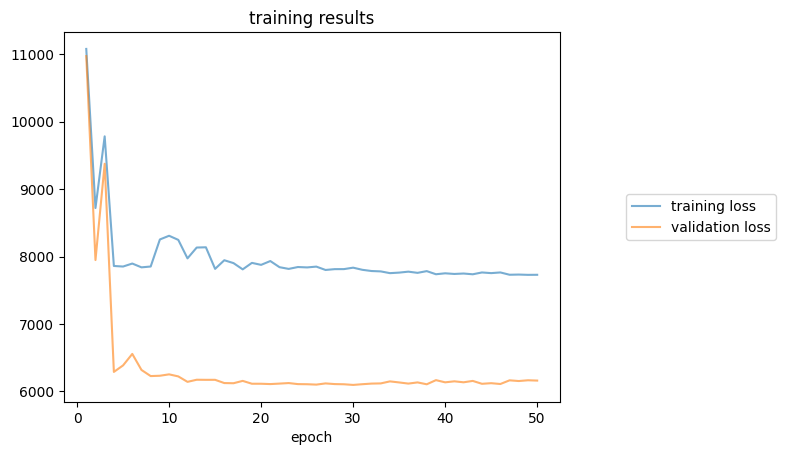

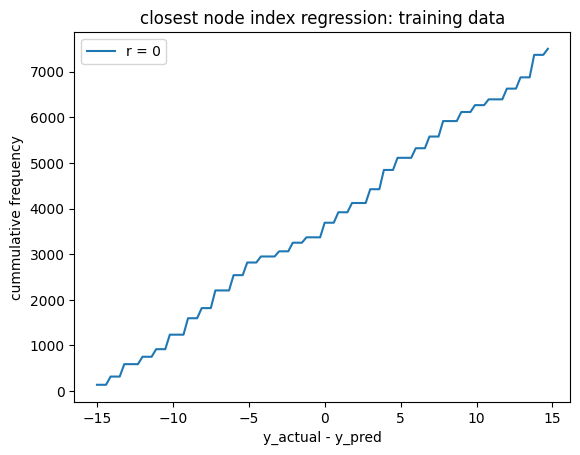

mean difference per seed set =  [0.31733334]
mean difference per seed node =  [ -6.  -6.  -5. ... -13. -13. -13.]


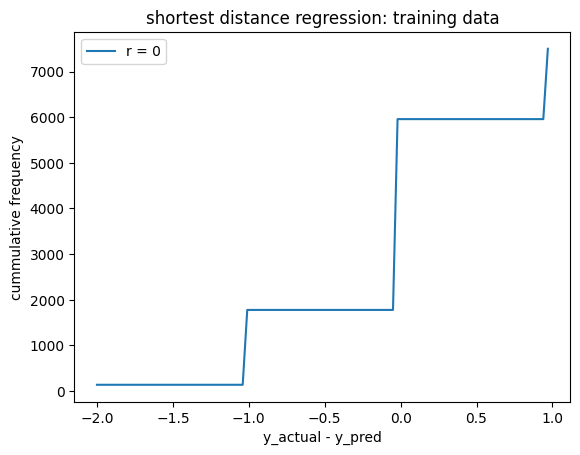

mean difference per seed set =  [-0.04893333]
mean difference per seed node =  [ 1. -1.  0. ...  0.  0.  0.]


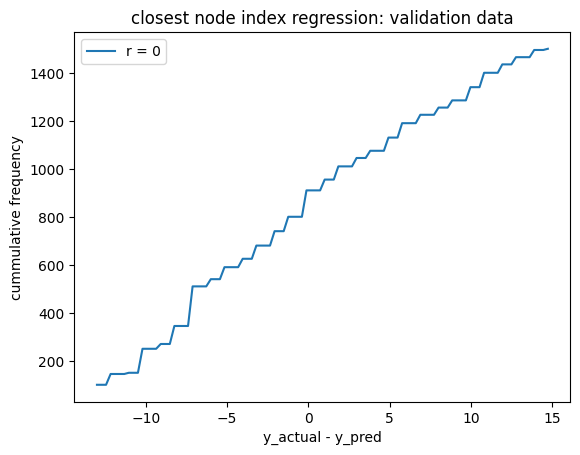

mean difference per seed set =  [-0.97333336]
mean difference per seed node =  [ 7.  7.  7. ... -7. -6. -7.]


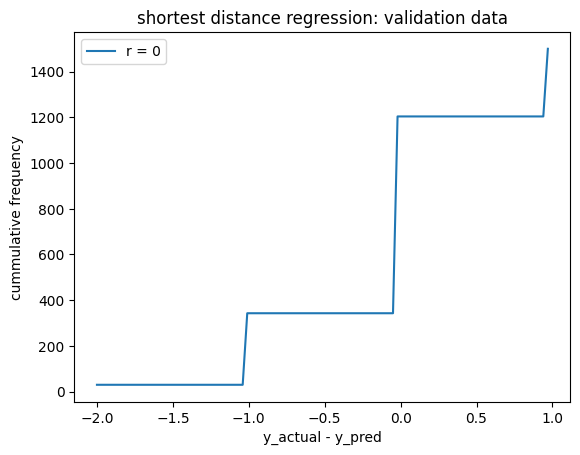

mean difference per seed set =  [-0.05133333]
mean difference per seed node =  [0. 1. 0. ... 0. 0. 0.]


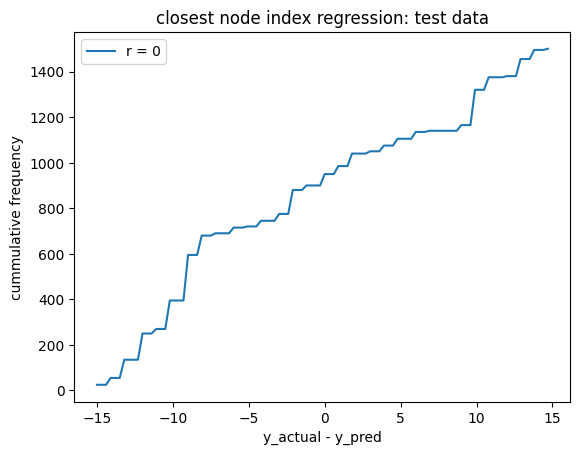

mean difference per seed set =  [-2.0933332]
mean difference per seed node =  [-9. -9. -8. ... -4. -4. -4.]


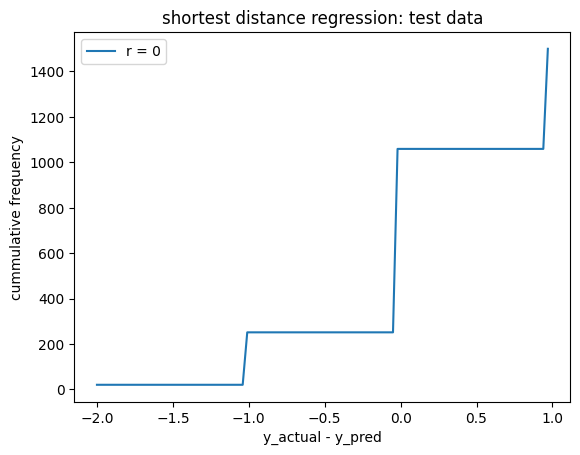

mean difference per seed set =  [0.11333334]
mean difference per seed node =  [ 0. -1. -1. ...  0.  0. -1.]


In [40]:
## 100*MSE1 + MSE2
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.4)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 7348.2700, Validation Loss (MSE): 8755.0771
Epoch: 020, Training Loss (MSE): 7366.9980, Validation Loss (MSE): 8857.2881
Epoch: 030, Training Loss (MSE): 7358.6274, Validation Loss (MSE): 8841.3379
Epoch: 040, Training Loss (MSE): 7367.2148, Validation Loss (MSE): 8876.5420
Epoch: 050, Training Loss (MSE): 7410.4077, Validation Loss (MSE): 8987.3408
Test Loss (MSE): 5460.087891


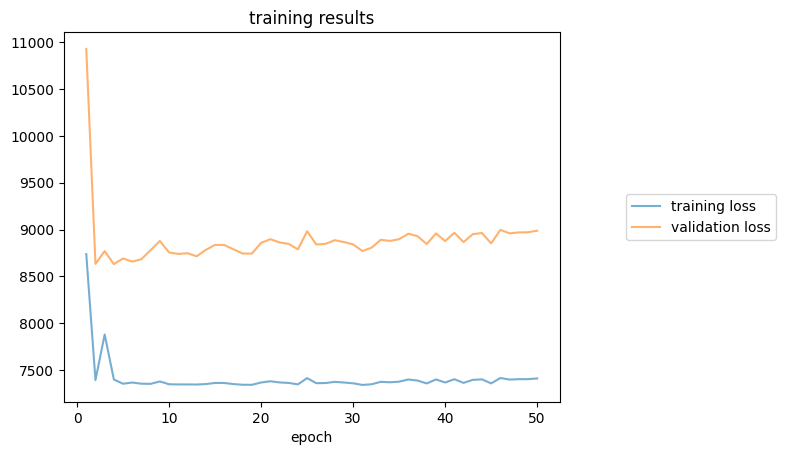

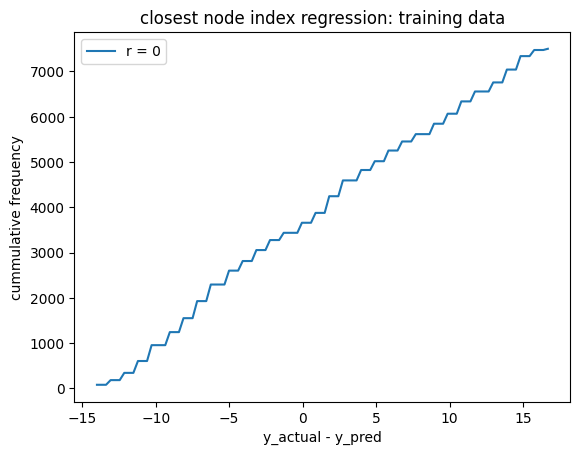

mean difference per seed set =  [0.9586667]
mean difference per seed node =  [ 2.  3.  3. ... 10.  9.  9.]


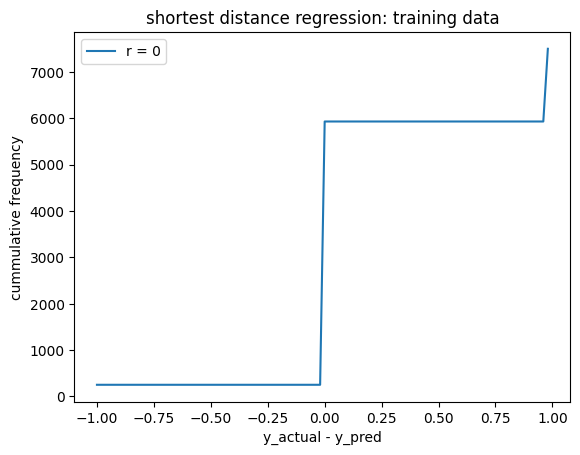

mean difference per seed set =  [0.17586666]
mean difference per seed node =  [0. 0. 0. ... 1. 0. 0.]


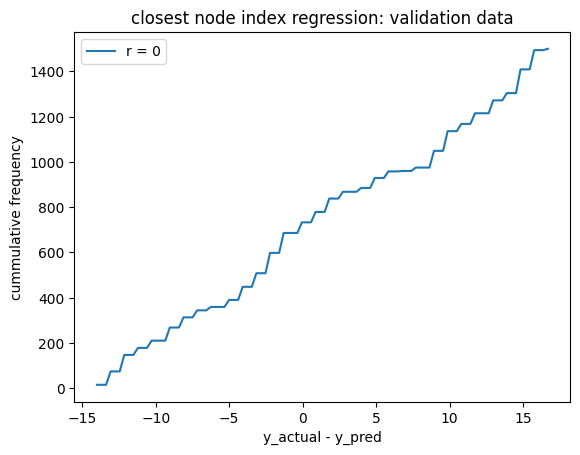

mean difference per seed set =  [1.9933333]
mean difference per seed node =  [-10. -11. -12. ...  11.  11.  11.]


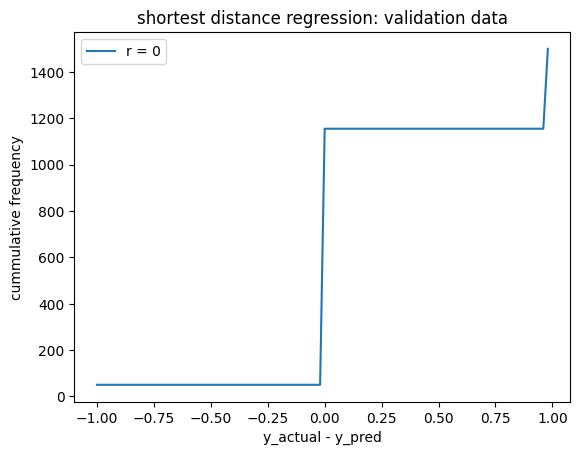

mean difference per seed set =  [0.19666667]
mean difference per seed node =  [ 0.  0. -1. ...  0.  0.  0.]


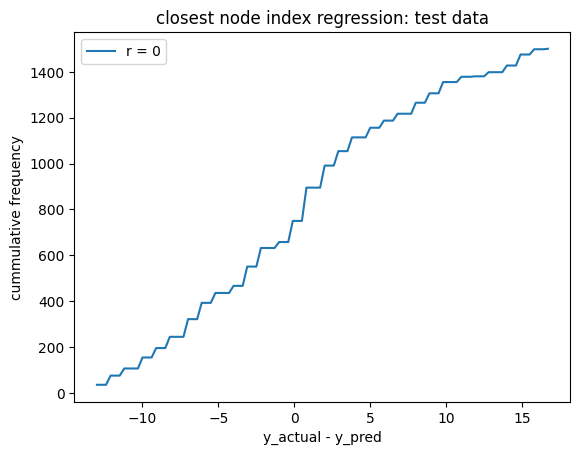

mean difference per seed set =  [0.25333333]
mean difference per seed node =  [-9. -8. -9. ...  1.  2.  1.]


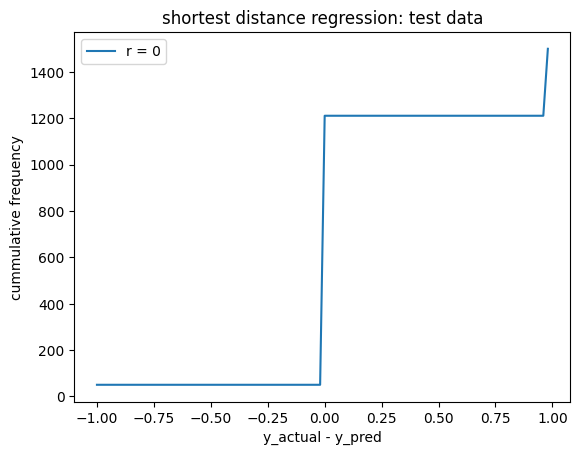

mean difference per seed set =  [0.15933333]
mean difference per seed node =  [0. 0. 0. ... 0. 0. 0.]


In [41]:
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.8)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 297.2136, Validation Loss (MSE): 1230.4575
Epoch: 020, Training Loss (MSE): 309.7190, Validation Loss (MSE): 1152.9130
Epoch: 030, Training Loss (MSE): 301.0104, Validation Loss (MSE): 1002.0729
Epoch: 040, Training Loss (MSE): 315.2832, Validation Loss (MSE): 930.5226
Epoch: 050, Training Loss (MSE): 308.6644, Validation Loss (MSE): 861.0762
Test Loss (MSE): 326.135529


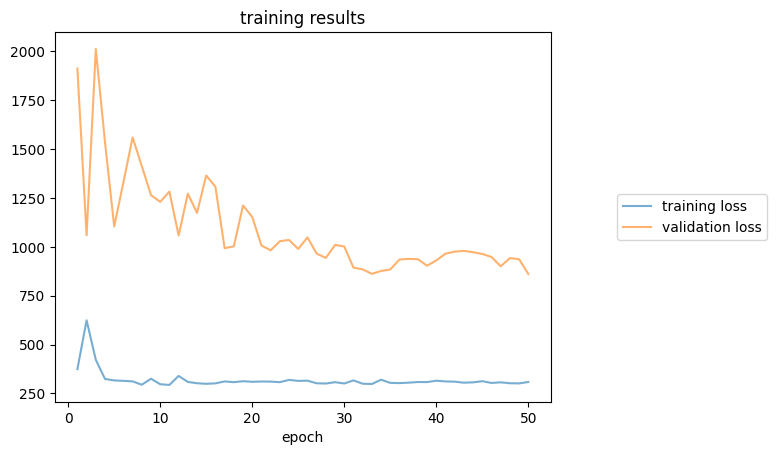

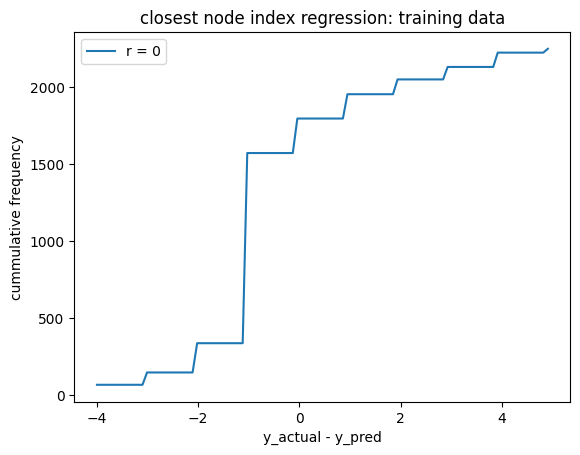

mean difference per seed set =  [-0.4608889]
mean difference per seed node =  [ 0.  0. -1. ... -1. -1. -1.]


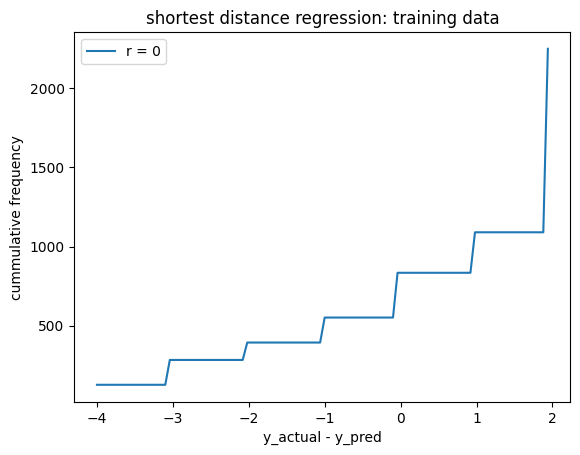

mean difference per seed set =  [0.54355556]
mean difference per seed node =  [1. 2. 2. ... 2. 2. 2.]


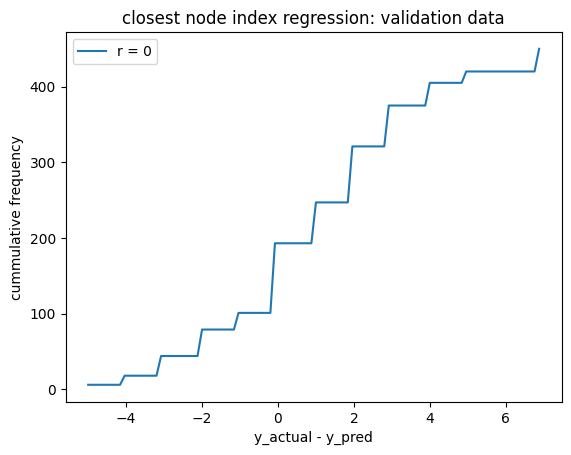

mean difference per seed set =  [1.1577778]
mean difference per seed node =  [ 2.  2.  2.  0.  0.  1.  1.  2.  2.  0.  0.  0. -2. -2. -1. -1.  0.  0.
  7.  7.  7.  7.  7.  3.  5.  3.  7.  2.  2.  2.  0.  0.  1.  1.  2.  2.
  7.  7.  7.  7.  7.  3.  5.  3.  7.  0.  0.  0. -2. -2. -1. -1.  0.  0.
  2.  0. -2. -2.  1.  2.  1.  2.  0.  1.  3.  5.  3.  0.  0.  0.  1.  3.
  2.  2.  2.  0.  0.  1.  1.  2.  2. -3. -3. -3. -5. -4.  0. -2.  1. -3.
 -4. -2.  0. -2. -4. -1. -2.  0. -1.  2.  2.  2.  0.  0.  1.  1.  2.  2.
 -4. -2.  0. -2. -4. -1. -2.  0. -1.  4.  4.  4.  2.  2.  3.  3.  4.  4.
  4.  4.  4.  2.  2.  3.  3.  4.  4.  1.  3.  5.  3.  0.  0.  0.  1.  3.
  2.  2.  2.  0.  0.  1.  1.  2.  2.  4.  4.  4.  2.  2.  3.  3.  4.  4.
  7.  7.  7.  7.  7.  3.  5.  3.  7.  1.  3.  5.  3.  0.  0.  0.  1.  3.
  0.  0.  0. -2. -2. -1. -1.  0.  0. -3. -3. -3. -5. -4.  0. -2.  1. -3.
 -3. -3. -3. -5. -4.  0. -2.  1. -3. -3. -3. -3. -5. -4.  0. -2.  1. -3.
  7.  7.  7.  7.  7.  3.  5.  3.  7.  1.  3.  5

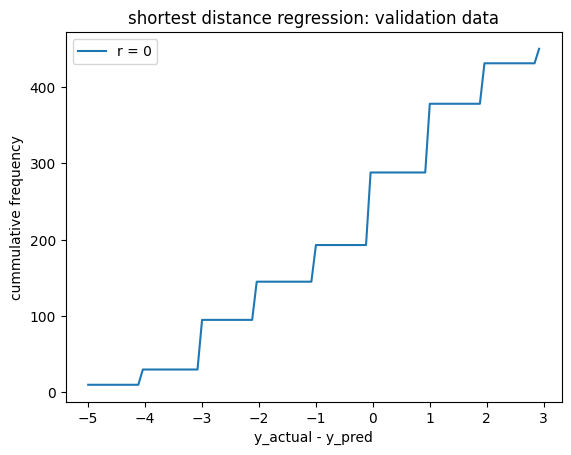

mean difference per seed set =  [-0.4888889]
mean difference per seed node =  [ 0.  1.  1.  3.  2.  1.  0.  1.  0. -1.  0.  1.  3.  1.  2.  1.  2.  1.
 -4. -4. -3. -4. -5. -1. -3. -1. -5.  0.  1.  1.  3.  2.  1.  0.  1.  0.
 -4. -4. -3. -4. -5. -1. -3. -1. -5. -1.  0.  1.  3.  1.  2.  1.  2.  1.
 -3. -2. -2.  0. -3. -4. -3. -3. -2.  1. -1. -3. -2.  2.  0.  0.  0. -2.
  0.  1.  1.  3.  2.  1.  0.  1.  0.  0. -1.  0.  2.  1. -3. -1. -3.  0.
 -2. -2. -3. -2.  0. -3. -2. -3. -2.  0.  1.  1.  3.  2.  1.  0.  1.  0.
 -2. -2. -3. -2.  0. -3. -2. -3. -2.  1.  1.  0.  2.  3.  2.  1.  2. -1.
  1.  1.  0.  2.  3.  2.  1.  2. -1.  1. -1. -3. -2.  2.  0.  0.  0. -2.
  0.  1.  1.  3.  2.  1.  0.  1.  0.  1.  1.  0.  2.  3.  2.  1.  2. -1.
 -4. -4. -3. -4. -5. -1. -3. -1. -5.  1. -1. -3. -2.  2.  0.  0.  0. -2.
 -1.  0.  1.  3.  1.  2.  1.  2.  1.  0. -1.  0.  2.  1. -3. -1. -3.  0.
  0. -1.  0.  2.  1. -3. -1. -3.  0.  0. -1.  0.  2.  1. -3. -1. -3.  0.
 -4. -4. -3. -4. -5. -1. -3. -1. -5.  1. -1. -

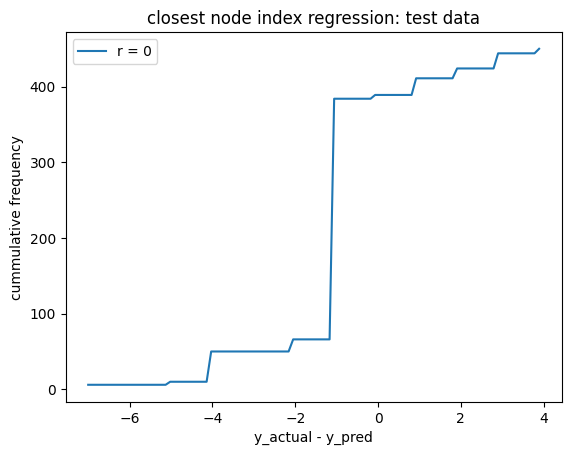

mean difference per seed set =  [-0.9777778]
mean difference per seed node =  [-1. -1. -1. -1. -1. -1.  3.  3.  1. -1. -1. -1. -1. -1. -1.  3.  3.  1.
 -1. -1. -1. -1. -1. -1.  4.  4.  2. -1. -4. -1. -1. -4. -1. -1. -1. -1.
 -1. -4. -1. -1. -4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  2.  2.  0.
 -2. -1. -2. -5. -1. -2. -1. -1. -1. -1. -1. -1. -4. -1. -1. -1. -1. -1.
 -1. -4. -1. -1. -4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -4. -1. -4. -7. -1. -4. -1. -1. -1. -1. -1. -1. -1. -1. -1.  3.  3.  1.
 -1. -1. -1. -1. -1. -1.  2.  2.  0. -1. -1. -1. -1. -1. -1.  3.  3.  1.
 -1. -1. -1. -1. -1. -1.  4.  4.  2. -4. -1. -4. -7. -1. -4. -1. -1. -1.
  1. -1.  1. -2. -1.  1. -1. -1. -1. -1. -1. -1. -4. -1. -1. -1. -1. -1.
 -1. -1. -1. -4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  3.  3.  1.
 -1. -1. -1. -1. -1. -1.  3.  3.  1. -1. -1. -1. -1. -1. -1.  3.  3.  1.
 -1. -1. -1. -4. -1. -1. -1. -1. -1. -2. -1. -2. -5. -1. -2. -1. -1. -1.
  1. -1.  1. -2. -1.  1. -1. -1. -1. -1. -1. -

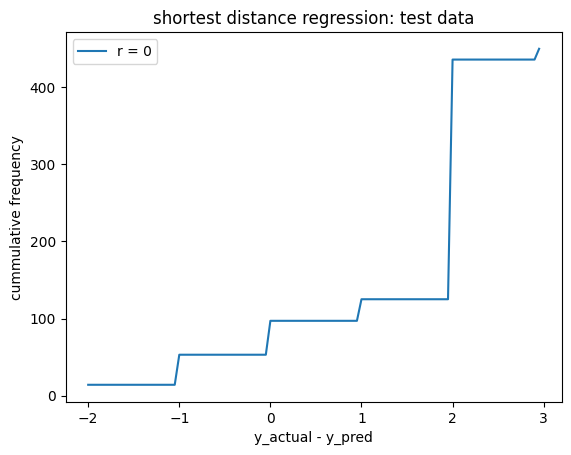

mean difference per seed set =  [1.3888888]
mean difference per seed node =  [ 2.  2.  2.  2.  2.  2.  1. -1.  2.  2.  2.  2.  2.  2.  2.  1. -1.  2.
  2.  2.  2.  2.  2.  2.  0.  0.  1.  2.  0.  2.  2.  1.  2.  2.  2.  2.
  2.  0.  2.  2.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2. -1.  1.  2.
  0.  2. -2.  3.  2.  0.  2.  2.  2. -1.  2. -1.  2.  2. -1.  2.  2.  2.
  2.  0.  2.  2.  1.  2.  2.  2.  2.  2.  1.  2.  2.  0.  2.  2.  2.  2.
 -2.  2.  0.  3.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1. -1.  2.
  2.  2.  2.  2.  2.  2. -1.  1.  2.  2.  2.  2.  2.  2.  2.  1. -1.  2.
  2.  2.  2.  2.  2.  2.  0.  0.  1. -2.  2.  0.  3.  2.  0.  2.  2.  2.
  0.  2.  0.  3.  2. -2.  2.  2.  2. -1.  2. -1.  2.  2. -1.  2.  2.  2.
 -1.  2. -1.  2.  2. -1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1. -1.  2.
  2.  2.  2.  2.  2.  2.  1. -1.  2.  2.  2.  2.  2.  2.  2.  1. -1.  2.
 -1.  2. -1.  2.  2. -1.  2.  2.  2.  0.  2. -2.  3.  2.  0.  2.  2.  2.
  0.  2.  0.  3.  2. -2.  2.  2.  2.  2.  2.  2

In [42]:
## 100*MSE1 + MSE2
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,10,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 2907.2361, Validation Loss (MSE): 3122.4121
Epoch: 020, Training Loss (MSE): 2805.9146, Validation Loss (MSE): 3027.4526
Epoch: 030, Training Loss (MSE): 2799.0479, Validation Loss (MSE): 3016.9375
Epoch: 040, Training Loss (MSE): 2779.7234, Validation Loss (MSE): 2996.8318
Epoch: 050, Training Loss (MSE): 2772.9243, Validation Loss (MSE): 2989.0112
Test Loss (MSE): 3629.771729


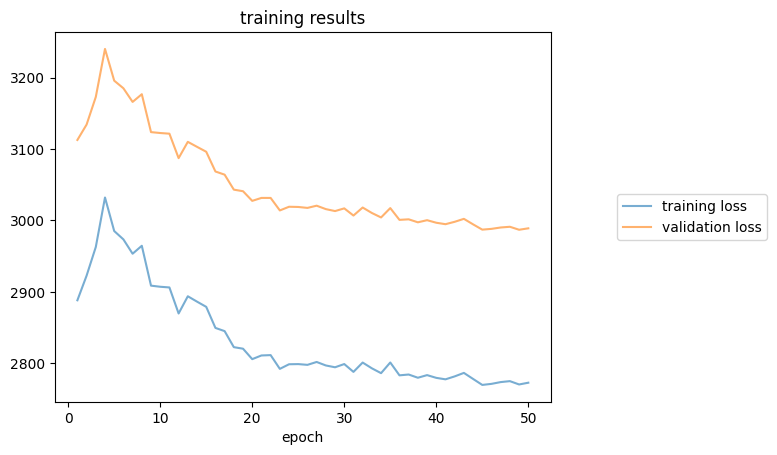

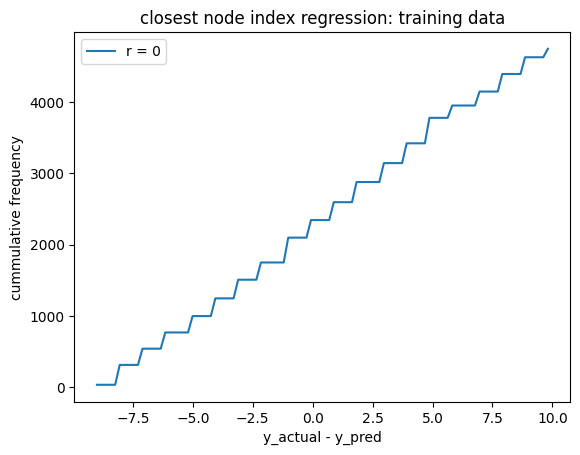

mean difference per seed set =  [0.6267368]
mean difference per seed node =  [ 8.  8.  8. ... -5. -4. -4.]


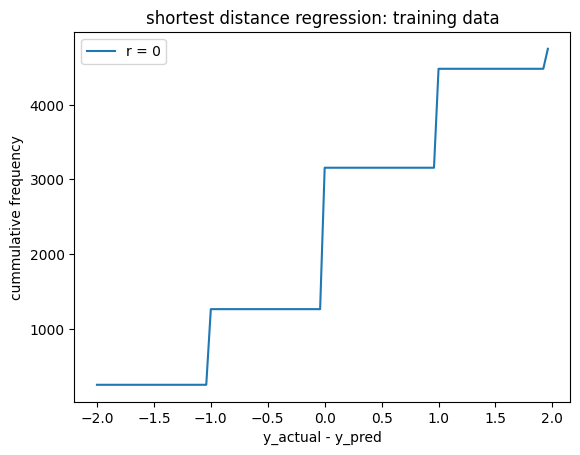

mean difference per seed set =  [0.07326316]
mean difference per seed node =  [-1.  0. -1. ...  0.  1.  0.]


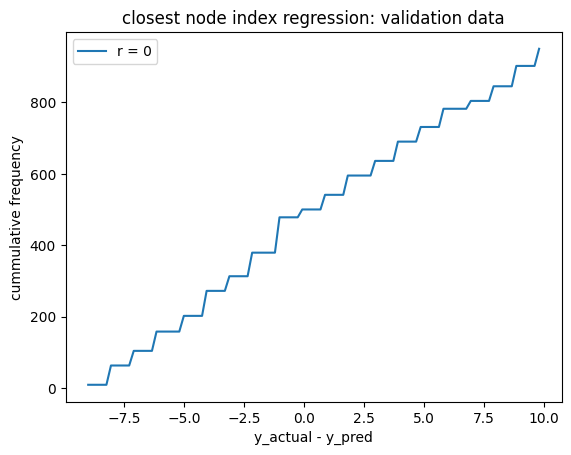

mean difference per seed set =  [0.5221053]
mean difference per seed node =  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -2. -2. -1. -1. -1. -1. -2. -1. -1.
 -1. -3. -3. -3. -3. -3. -3. -3. -3. -3. -4. -4. -3. -3. -3. -3. -4. -3.
 -3. -3. -6. -6. -6. -6. -6. -6. -6. -6. -6. -7. -7. -6. -6. -6. -6. -7.
 -6. -6. -6. -4. -4. -4. -4. -4. -4. -4. -4. -4. -5. -5. -4. -4. -4. -4.
 -5. -4. -4. -4. -6. -6. -6. -6. -6. -6. -6. -6. -6. -7. -7. -6. -6. -6.
 -6. -7. -6. -6. -6. -5. -5. -5. -5. -5. -5. -5. -5. -5. -6. -6. -5. -5.
 -5. -5. -6. -5. -5. -5.  4.  4.  4.  4.  4.  4.  4.  4.  4.  3.  3.  4.
  4.  4.  4.  3.  4.  4.  4.  3.  3.  3.  3.  3.  3.  3.  3.  3.  2.  2.
  3.  3.  3.  3.  2.  3.  3.  3. 10. 10. 10. 10. 10. 10. 10. 10. 10.  9.
  9. 10. 10. 10. 10.  9. 10. 10. 10.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  5.  5.  6.  6.  6.  6.  5.  6.  6.  6. -5. -5. -5. -5. -5. -5. -5. -5.
 -5. -6. -6. -5. -5. -5. -5. -6. -5. -5. -5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  4.  4.  5.  5.  5.  5.  4.  5.  5.  5

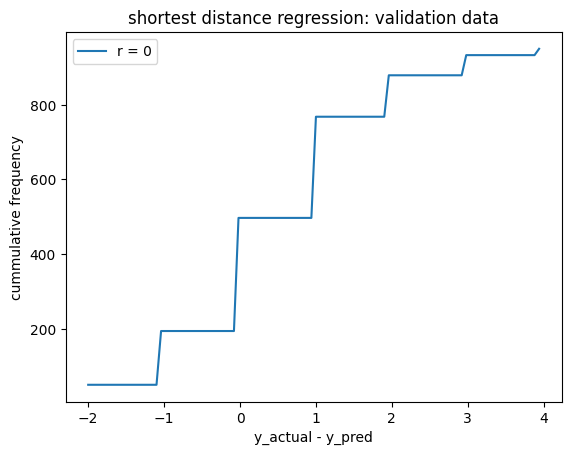

mean difference per seed set =  [0.50421053]
mean difference per seed node =  [ 2.  1.  2.  4.  3.  1.  0. -2.  0.  0.  1.  1.  1.  1. -1.  2.  3.  1.
  1.  0.  0. -1.  2.  1. -2. -1.  1. -1.  0. -1.  0.  0.  0.  0.  0.  1.
  0.  1.  0. -1. -2.  1.  0. -1.  0.  2.  0.  0. -1.  1.  0.  1.  1. -1.
  0.  0.  1. -1.  1.  0.  1. -2.  1.  1.  3.  2.  1.  0.  3.  0.  2.  2.
 -1.  0.  1.  2.  0. -1. -2.  1.  0. -1.  0.  2.  0.  0. -1.  1.  0.  1.
  1. -1.  0.  0.  1.  2.  2.  1. -2.  1.  2.  2.  4.  3.  3.  2.  4.  1.
  3.  3.  0. -1.  3.  4.  0.  0.  0.  1.  0.  0. -1.  1.  1.  0. -1.  2.
 -2.  0.  0. -1.  0.  0.  1.  2.  0.  1.  4.  3.  0.  1.  1. -1.  0.  1.
 -2.  2.  1.  0.  2.  3.  1. -1.  1.  1.  1.  4.  2.  1.  1.  1.  0. -1.
  0. -1.  1.  0.  0.  2.  3.  0. -2.  1.  0.  1.  3.  2.  0. -1. -1. -1.
 -1.  0.  0.  0.  0. -2.  1.  2.  0.  0.  2.  2.  1. -2.  1.  2.  2.  4.
  3.  3.  2.  4.  1.  3.  3.  0. -1.  3.  4.  1.  1.  1.  3.  2.  0. -1.
  1.  1. -1.  0.  1.  0. -2.  0.  1.  2.  0.  

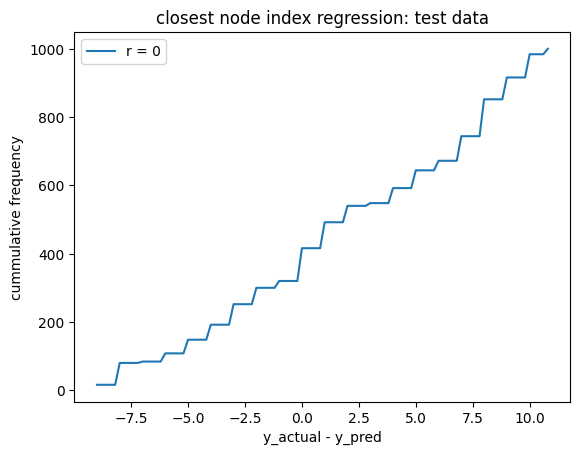

mean difference per seed set =  [2.1]
mean difference per seed node =  [ 8.  7.  8.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  7.
  8.  7.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0. -1.  9.  8.  9.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
  9.  9.  9.  8.  9.  8.  8.  7.  8.  7.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  7.  8.  7.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. -1.  0. -1. -2. -3. -2. -3. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -3. -2. -3. -8. -9. -8. -9. -8. -8.
 -8. -8. -8. -8. -8. -8. -8. -8. -8. -8. -8. -9. -8. -9.  5.  4.  5.  4.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  4.  5.  4.  8.  7.
  8.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  7.  8.  7.
  5.  4.  5.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  4.
  5.  4.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  0. 10.  9. 10.  9. 10. 10. 10. 10. 10. 

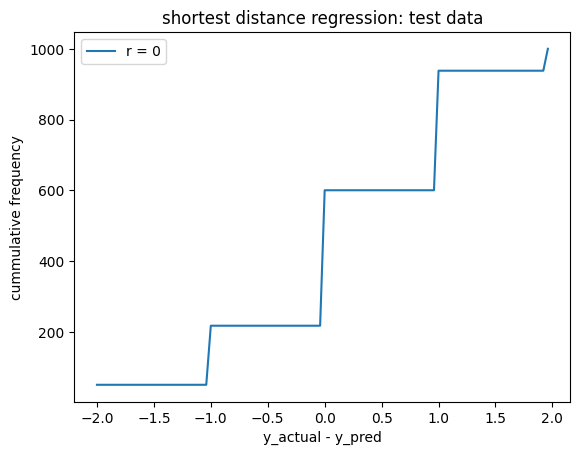

mean difference per seed set =  [0.195]
mean difference per seed node =  [ 0. -1.  1. -1. -1.  0.  0.  0.  1. -1.  0. -1.  1.  0.  0. -1. -2.  0.
  1.  0.  1.  0.  2.  1.  1.  1.  1. -1. -2.  2.  2.  0.  2.  1.  2.  0.
  1.  0.  1.  1.  1. -1.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.
  0. -1.  0. -2. -1. -1.  0. -1.  1. -1. -1.  0.  0.  0.  1. -1.  0. -1.
  1.  0.  0. -1. -2.  0.  1.  0.  1.  0.  2.  1.  1.  1.  1. -1. -2.  2.
  2.  0.  2.  1.  2.  0.  1.  0.  1.  1.  0.  0.  1.  0. -1.  1. -2.  0.
  1.  1.  1. -1.  1.  1.  0.  0.  0. -1. -1.  0. -2.  0.  1.  1.  0.  1.
  0.  0.  1.  1.  0. -1. -1. -1.  1.  1.  0.  1.  1.  0. -1. -1.  2.  0.
  0.  0.  1.  0.  1.  1. -1.  0.  0. -2.  1.  1.  0.  0.  1.  1.  0. -1.
  1. -1. -1.  0.  0.  0.  1. -1.  0. -1.  1.  0.  0. -1. -2.  0.  1.  0.
 -1. -1.  2.  0.  0.  0.  1.  0.  1.  1. -1.  0.  0. -2.  1.  1.  0.  0.
  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  2. -2.  1.  0.  0.  1.  1.  0.
 -1.  0.  1. -1.  1.  0.  1.  0.  0.  1. -1.  0.  1

In [43]:
## 100*MSE1 + MSE2
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,20,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 14732.7822, Validation Loss (MSE): 15962.1270
Epoch: 020, Training Loss (MSE): 14143.3828, Validation Loss (MSE): 15037.0244
Epoch: 030, Training Loss (MSE): 13961.2988, Validation Loss (MSE): 14755.0049
Epoch: 040, Training Loss (MSE): 13722.7207, Validation Loss (MSE): 14298.0117
Epoch: 050, Training Loss (MSE): 13640.6787, Validation Loss (MSE): 14136.1074
Test Loss (MSE): 13370.500000


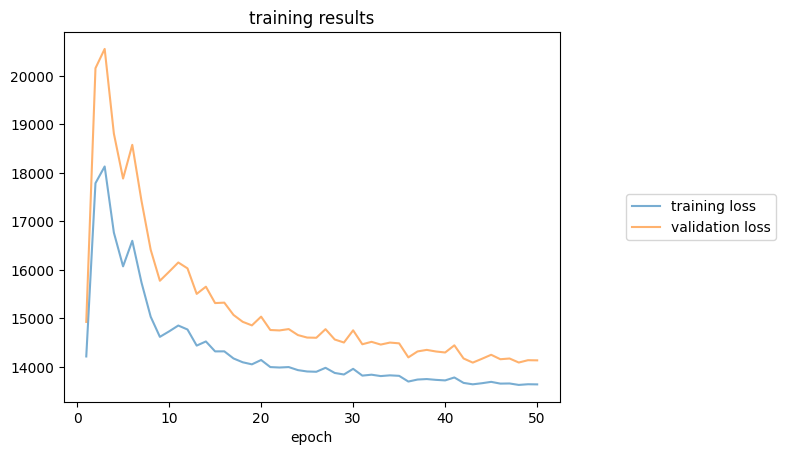

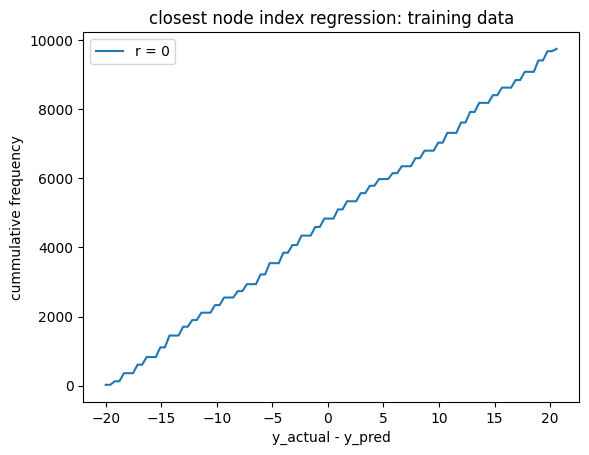

mean difference per seed set =  [1.0012307]
mean difference per seed node =  [12. 12. 11. ... 11. 10. 11.]


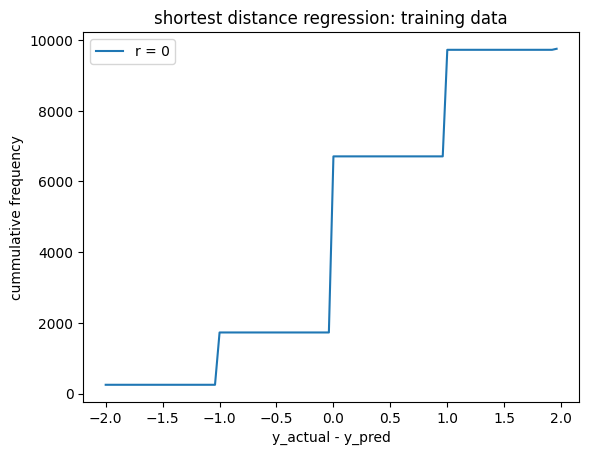

mean difference per seed set =  [0.112]
mean difference per seed node =  [0. 1. 0. ... 1. 0. 0.]


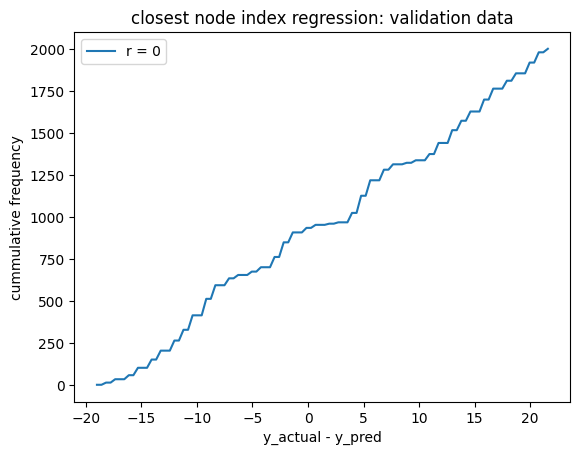

mean difference per seed set =  [2.57]
mean difference per seed node =  [-11.  -9. -11. ...  -2.  -1.  -1.]


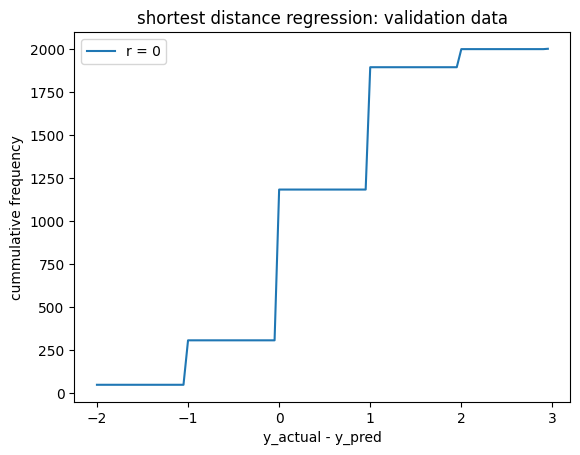

mean difference per seed set =  [0.284]
mean difference per seed node =  [-1.  0. -1. ...  0.  0.  1.]


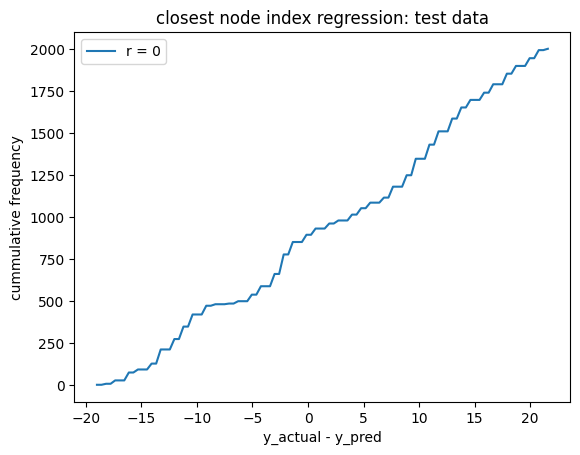

mean difference per seed set =  [3.085]
mean difference per seed node =  [20. 21. 20. ... 16. 17. 18.]


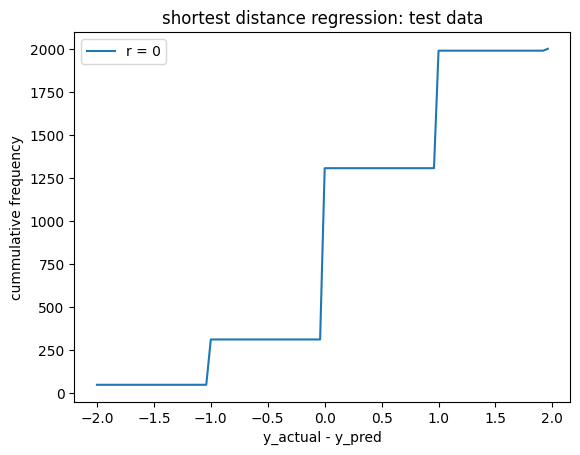

mean difference per seed set =  [0.1705]
mean difference per seed node =  [0. 0. 0. ... 0. 0. 1.]


In [44]:
## 100*MSE1 + MSE2
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,40,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 61955.4844, Validation Loss (MSE): 59558.7070
Epoch: 020, Training Loss (MSE): 59714.6016, Validation Loss (MSE): 56251.0820
Epoch: 030, Training Loss (MSE): 59350.1250, Validation Loss (MSE): 55697.5625
Epoch: 040, Training Loss (MSE): 58793.9922, Validation Loss (MSE): 54836.4336
Epoch: 050, Training Loss (MSE): 58174.1289, Validation Loss (MSE): 53862.2539
Test Loss (MSE): 60295.644531


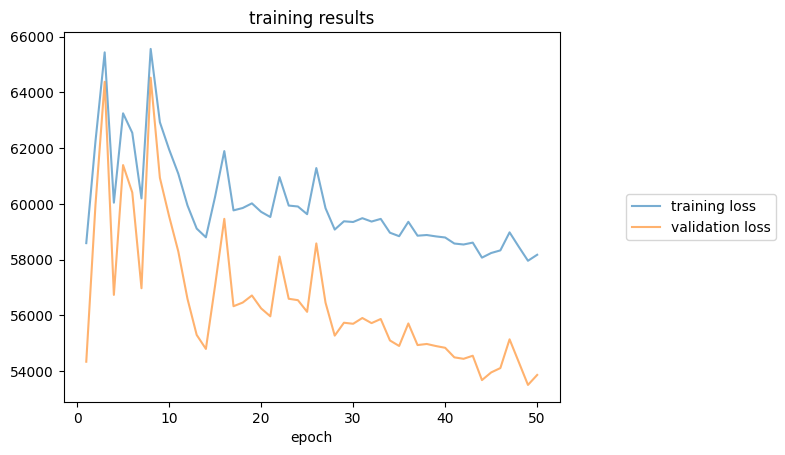

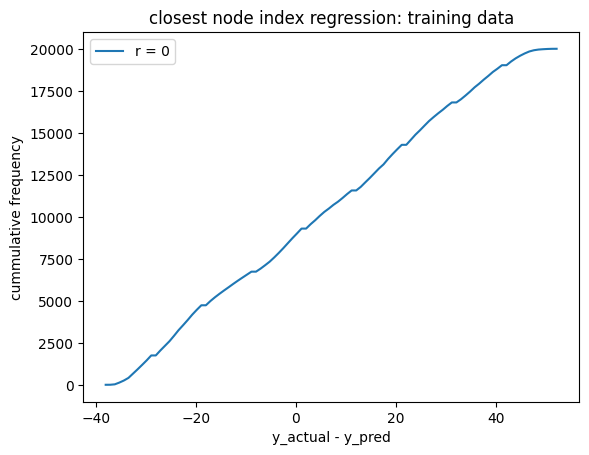

mean difference per seed set =  [5.406]
mean difference per seed node =  [26. 22. 23. ... 32. 24. 24.]


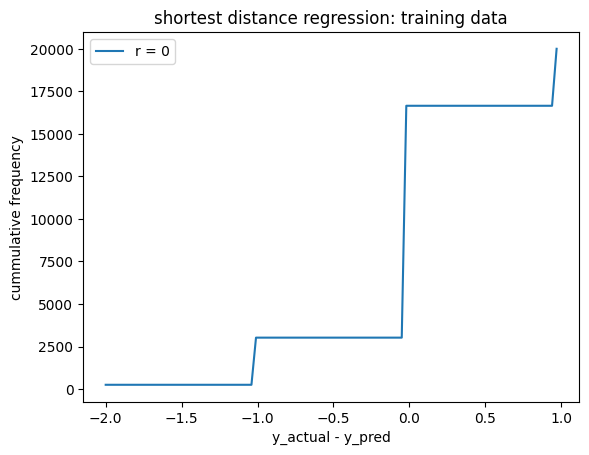

mean difference per seed set =  [0.00395]
mean difference per seed node =  [ 1. -1.  0. ...  1.  0.  0.]


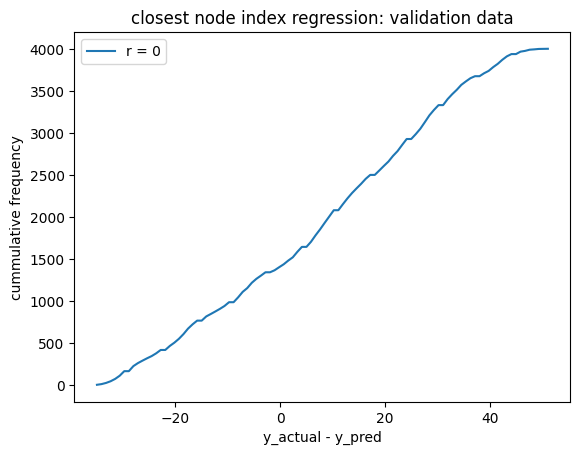

mean difference per seed set =  [8.86]
mean difference per seed node =  [-25. -22. -18. ...   4.   2.   3.]


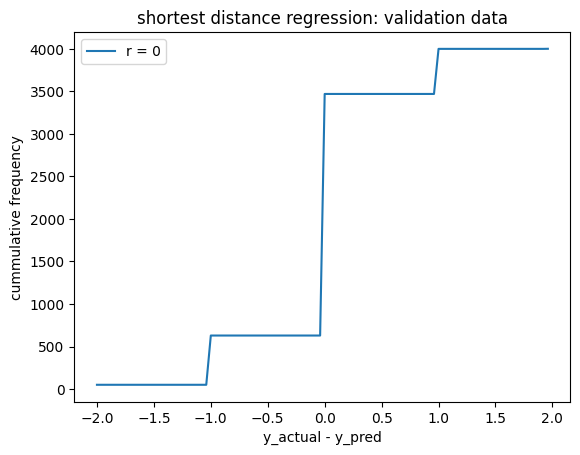

mean difference per seed set =  [-0.03675]
mean difference per seed node =  [ 0. -1.  0. ...  0. -1.  0.]


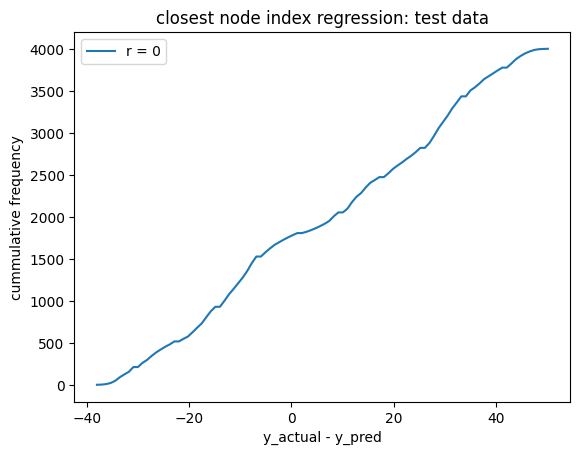

mean difference per seed set =  [7.38]
mean difference per seed node =  [ 43.  46.  45. ... -13. -15. -13.]


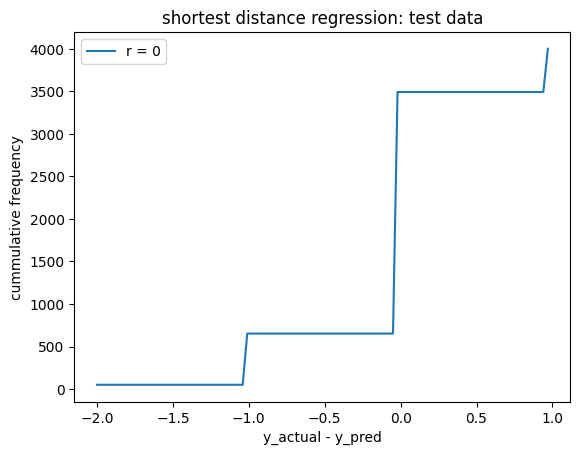

mean difference per seed set =  [-0.0485]
mean difference per seed node =  [-1.  0.  0. ... -1.  0.  1.]


In [45]:
## 100*MSE1 + MSE2
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,80,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [46]:
scale = 100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,160,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 2)
)
Epoch: 010, Training Loss (MSE): 224386.1250, Validation Loss (MSE): 171562.4531
Epoch: 020, Training Loss (MSE): 220295.4531, Validation Loss (MSE): 173249.9688
Epoch: 030, Training Loss (MSE): 219943.3125, Validation Loss (MSE): 174033.2969


In [ ]:
## 10*MSE1 + MSE2
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.05)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## 10*MSE1 + MSE2
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.1)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## 10*MSE1 + MSE2
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.2)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## 10*MSE1 + MSE2
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.4)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.8)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## 10*MSE1 + MSE2
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,10,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## 10*MSE1 + MSE2
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,20,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## 10*MSE1 + MSE2
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,40,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## 10*MSE1 + MSE2
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,80,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,160,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## MSE1 + MSE2
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.05)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## MSE1 + MSE2
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.1)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## MSE1 + MSE2
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.2)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## MSE1 + MSE2
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.4)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.8)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## MSE1 + MSE2
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,10,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## MSE1 + MSE2
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,20,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## MSE1 + MSE2
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,40,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
## MSE1 + MSE2
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,80,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,160,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.05)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.1)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.2)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.4)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.8)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,10,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,20,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,40,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,80,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/10
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,160,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.05)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.1)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.2)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.4)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.8)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,10,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,20,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,40,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,80,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 1/100
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,160,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.05)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.1)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.2)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.4)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.8)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,10,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,20,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,40,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,80,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [ ]:
scale = 0
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,160,0.15)
results = run(samples,'gcn','mse-mse','adam',None,50)

In [29]:
def generateSamples_closestPoints_inner(n_samples,max_n_samples_per_graph,k,function,*args,**kwargs):
    samples_x = []
    samples_y1 = []
    samples_y2 = []
    samples_y3 = []
    samples_edge_index = []
    samples_weights = None
    not_disconnected_nodes = []
    object,directed,weighted = function(*args,**kwargs)
    if weighted:
        samples_weights = []
    if isinstance(object, np.ndarray):
        #matrix_type = object
        object = matrix_to_graph(object)
    #else:
        #matrix_type = graph_to_matrix(object)
    n = len(object.nodes())
    i = 0
    while i<n_samples:
        #print(i)
        components = list(nx.strongly_connected_components(object))
        to_remove = [c.pop() for c in components if len(c) == 1]
        if len(to_remove) < len(object.nodes()):
            object.remove_nodes_from(to_remove)
            remaining = object.nodes()
            object = nx.relabel_nodes(object, {node: index for index, node in enumerate(object.nodes())})
            if weighted:
                weights = list(nx.get_edge_attributes(object,'weight').values())
            n_new = len(object.nodes())
            r = 0
            #print(1)
            r_new = r
            while 2**r_new > n_new:
                r_new -= 1
                #print(r_new)
            j = 0
            #print('a')
            while i<n_samples and j<max_n_samples_per_graph:
                x_final = np.zeros((n_new,0))
                y1_final = np.zeros((n_new,0))
                y2_final = np.zeros((n_new,0))
                y3_final = np.zeros((n_new,0))
                for h in range(k):
                    sample_sets = [np.random.choice(object.nodes(),size=seed_set_size,replace=False) for t in range(r_new+1)]
                    x = np.zeros((n_new,r+1))
                    y1 = np.zeros((n_new,(r+1)*2))
                    y2 = np.zeros((n_new,r+1))
                    y3 = np.zeros((n_new,r+1))
                    for t in range(r_new+1):
                        x[:,t] = np.array([int(node in sample_sets[t]) for node in range(n_new)])
                    for u in range(n_new):
                        distances = shortestDistance_allNodes_networkx(object,u)
                        if weighted:
                            M = n*max(weights)
                            distances = np.where(distances == float('inf'), M, distances)
                        else:
                            M = n
                            distances = np.where(distances == float('inf'), M, distances)
                        for t in range(r_new+1):
                            selected_distances = distances[sample_sets[t]]
                            y1[u,t*2+1] = np.min(selected_distances)
                            y3[u,t] = y1[u,t*2+1]
                            if y1[u,t*2+1] == M:
                                y1[u,t*2] = -1
                            else:
                                y1[u,t*2] = sample_sets[t][np.argmin(selected_distances)]
                            y2[u,t] = y1[u,t*2]
                    for t in range(r_new+1,r+1):
                        x[:,t] = x[:,t-1]
                        y1[:t*2] = y1[:t*2-2]
                        y2[:,t] = y1[:,t*2]
                        y1[:t*2+1] = y1[:t*2-1]
                        y3[:,t] = y1[:,t*2+1]
                    x_final = np.concatenate((x_final, x), axis=1)
                    y1_final = np.concatenate((y1_final, y1), axis=1)
                    y2_final = np.concatenate((y2_final, y2), axis=1)
                    y3_final = np.concatenate((y3_final, y3), axis=1)
                    #print(y1_final.shape)
                samples_x.append(torch.tensor(x_final.astype(np.float32), requires_grad=True))
                samples_y1.append(torch.tensor(y1_final).to(torch.float32))
                samples_y2.append(torch.tensor(y2_final).to(torch.float32))
                samples_y3.append(torch.tensor(y3_final).to(torch.float32))
                samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                if weighted:
                    samples_weights.append(torch.tensor(weights).to(torch.float32))
                not_disconnected_nodes.append(remaining)
                i += 1
                j += 1
        else:
            object,directed,weighted = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                #matrix_type = object
                object = matrix_to_graph(object)
            #else:
                #matrix_type = graph_to_matrix(object)
    return samples_x, samples_y1, samples_y2, samples_y3, samples_edge_index, samples_weights,not_disconnected_nodes

def generateSamples_closestPoints(n_train,n_val,n_test,max_n_samples_per_graph,k,function,*args,**kwargs):
    x_train, y1_train, y2_train, y3_train, edge_index_train, weights_train,not_disconnected_train = generateSamples_closestPoints_inner(n_train,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_val, y1_val, y2_val, y3_val, edge_index_val, weights_val,not_disconnected_val = generateSamples_closestPoints_inner(n_val,max_n_samples_per_graph,k,function,*args,**kwargs)
    x_test, y1_test, y2_test, y3_test, edge_index_test, weights_test,not_disconnected_test = generateSamples_closestPoints_inner(n_test,max_n_samples_per_graph,k,function,*args,**kwargs)
    return [x_train, x_val, x_test, [y1_train, y2_train, y3_train], [y1_val, y2_val, y3_val], [y1_test, y2_test, y3_test], edge_index_train,edge_index_val,edge_index_test,weights_train,weights_val,weights_test,not_disconnected_train,not_disconnected_val,not_disconnected_test]

In [38]:
def evaluate_inner(plot_title,title,y_actual,y_pred,true_distances,x_samples = None,classification=True): ## target is nx1

    if classification:

        graph_size = true_distances.shape[1]

        ## Calculate the proportion of points selected from the sample.
        ratio1 = np.mean(y_pred,axis=1)

        ## Check if any disconnected node is in actual sketch.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        M = np.max(true_distances) * 10
        true_distances[true_distances == -1] = M
        y_actual = torch.stack(y_actual).detach().numpy()
        dump_actual = y_actual*true_distances
        n_dump_actual_equal_M = np.sum((dump_actual == M).astype(int),axis=1)
        ratio2 = n_dump_actual_equal_M/np.sum(y_actual,axis=1) ## nan means empty sketch
        #ratio2[np.isnan(ratio2)] = -1

        ## Check if any disconnected node is chosen.
        dump = y_pred*true_distances
        n_true_distances_equal_M = np.sum((true_distances == M).astype(int),axis=1)
        n_dump_equal_M = np.sum((dump == M).astype(int),axis=1)
        n_selected = np.sum(y_pred,axis=1)
        n_selected[n_selected == 0] = 0.0001
        ratio3 = n_dump_equal_M/n_selected ## nan means no nodes have been selected, ratio1 = 0
        #ratio3[np.isnan(ratio3)] = -1

        if x_samples != None:

            ## Seed node and neighbors -> 1. Others -> 0
            seed_or_neighbors = np.zeros_like(true_distances)
            _,seeds = np.where(true_distances == 0) ## number of seeds = number of samples because we selected one seed from each sample
            seed_disconnected = np.zeros(seed_or_neighbors.shape[0])
            for i in range(len(seeds)):
                seed = seeds[i]
                seed_or_neighbors[i] = x_samples[i].detach().numpy()[seed] ## x_samples[i] has to be adjacency matrix
                seed_disconnected[i] = sum((seed_or_neighbors[i]>0).astype(int))>0
                seed_or_neighbors[i,seed] = 1
            seed_or_neighbors_selected = seed_or_neighbors*y_pred

            ## Is seed node not disconnected from the remaining?
            seed_disconnected = seed_disconnected.astype(int)

            ## Have seed node and its neighbors been chosen?
            ratio4 = np.sum(seed_or_neighbors_selected,axis=1)/np.sum(seed_or_neighbors,axis=1)

            ## How many of the chosen nodes are seed node and its neighbors?
            ratio5 = np.sum(seed_or_neighbors_selected,axis=1)/n_selected ## nan means no nodes have been selected, ratio1 = 0
            #ratio5[np.isnan(ratio5)] = -1

        ## Check if the chosen nodes are closer than random selection.
        sum_distance_selected = np.sum(dump,axis=1)
        term0 = np.mean(true_distances,axis=1)
        term0[term0 == 0] = 0.0001
        ratio6 = sum_distance_selected/n_selected/term0 ## nan means no nodes have been selected, ratio1 = 0
        #ratio6[np.isnan(ratio6)] = -1

        ## Same as ratio6 but excludes disconnected nodes with inf distance to the seed node.
        n_selected[n_selected == 0.0001] = 0
        term1 = n_selected-n_dump_equal_M
        term1[term1 == 0] = 0.0001
        term2 = np.sum(true_distances,axis=1)-n_true_distances_equal_M*M
        term2[term2 == 0] = 0.0001
        ratio7 = (sum_distance_selected-n_dump_equal_M*M)/term1/term2*(graph_size-n_true_distances_equal_M)
        #ratio7[np.isnan(ratio7)] = -1
        ## nan means no nodes have been selected (ratio1 = 0) or selected nodes are all disconnected from seed node (inf distance)

        plt.figure(figsize=(10, 5))
        plt.plot(range(len(ratio1)), ratio1, color = '#1f77b4', label = 'ratio 1: size of selected community to size of sample ratio',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio6, color = '#8c564b', label = 'ratio 2: mean distance of chosen nodes to seed node divided by mean distance of all nodes to seed node',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio7, color = '#e377c2', label = 'ratio 3: same as ratio 6 but excludes disconnected nodes',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio2, color = '#ff7f0e', label = 'ratio 4: proportion of disconnected nodes in actual sketch',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio3, color = '#2ca02c', label = 'ratio 5: proportion of disconnected nodes in the chosen community',alpha = 0.6)
        if x_samples != None:
            plt.plot(range(len(ratio1)), ratio4, color = '#d62728', label = 'ratio 6: proportion of seed node and its neighbors that are selected',alpha = 0.6)
            plt.plot(range(len(ratio1)), ratio5, color = '#9467bd', label = 'ratio 7: proportion of selected nodes that are seed node or its neighbors',alpha = 0.6)
            plt.scatter(range(len(ratio1)), seed_disconnected, color = 'k', marker='x', label = 'is seed node not disconnected from the remaining nodes in graph? 1 = True, 0 = False',alpha = 0.6)
        plt.xlabel("sample index")
        plt.ylabel("")
        plt.title(title)
        plt.legend(loc = 'lower center',bbox_to_anchor=(0.48, -0.6))
        plt.show()

        true_distances[true_distances == M] = np.inf
        if x_samples == None:
            return [np.mean(ratio1),np.mean(ratio6),np.mean(ratio7),np.mean(ratio2),np.mean(ratio3)]
        else:
            return [np.mean(ratio1),np.mean(ratio6),np.mean(ratio7),np.mean(ratio2),np.mean(ratio3),np.mean(ratio4),np.mean(ratio5)]
        
    else:

        ## Calculate prediction to true distance.
        #y_actual[y_actual == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        #y_pred[y_pred == np.inf] = -1
        #M = max(np.max(y_actual),np.max(y_pred))*10
        #y_actual[y_actual == -1] = M
        y_actual = np.array(y_actual)
        #y_actual[y_actual == 0] = 0.0001 ## to avoid ratio = x/0
        #y_pred[y_pred == -1] = M
        #print(y_pred.shape)
        #print(y_actual.shape)
        diff = y_actual - y_pred.reshape((y_actual.shape[0],y_actual.shape[1],y_actual.shape[2]))
        diff = diff.reshape((diff.shape[0]*diff.shape[1],diff.shape[2]))
        
        if len(np.unique(diff)) == 1:
            print('y_actual - y_actual is '+str(diff[0])+' for all nodes in all seed sets in '+title+'.')
        else:
            for r in range(diff.shape[1]):
                values, base = np.histogram(diff[:,r], bins=100)
                cumulative = np.cumsum(values)
                plt.plot(base[:-1], cumulative, label='r = '+str(r))
                #plt.scatter([r]*ratio.shape[0],ratio[:,r])
            plt.xlabel("y_actual - y_pred")
            plt.ylabel("cummulative frequency")
            plt.title(plot_title+title)
            plt.legend()
            plt.show()

            m0 = np.mean(diff,axis=0)
            m1 = np.mean(diff,axis=1)
            print('mean difference per seed set = ',m0)
            print('mean difference per seed node = ',m1)

        #y_actual[y_actual == M] = np.inf
        #y_actual[y_actual == 0.0001] = 0
        #y_pred[y_pred == M] = np.inf

        #return [m0,m1]
    
def evaluate(plot_title,model,criterion_type,samples,adjacency_matrix_available = False):
    if criterion_type in ['mse','l2','l1','mse-mse']:
        classification = False
    else:
        classification = True
    y_pred_train,y_pred_val,y_pred_test = predict_allBatches(model,criterion_type,samples)
    if adjacency_matrix_available:
        evaluate_inner(plot_title,'training data',samples[3],y_pred_train,samples[12],samples[0],classification)
        evaluate_inner(plot_title,'validation data',samples[4],y_pred_val,samples[13],samples[1],classification)
        evaluate_inner(plot_title,'test data',samples[5],y_pred_test,samples[14],samples[2],classification)
    else:
        evaluate_inner(plot_title,'training data',samples[3],y_pred_train,samples[12],classification=classification)
        evaluate_inner(plot_title,'validation data',samples[4],y_pred_val,samples[13],classification=classification)
        evaluate_inner(plot_title,'test data',samples[5],y_pred_test,samples[14],classification=classification)
    #return np.array(stats)

In [42]:
def test(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index = None,samples_weights = None):
    t_loss = 0
    total_samples = 0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                out = model(x)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)
        elif samples_weights == None:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                out = model(x,edge_index)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)
        else:
            for x,y,edge_index,weights in list(zip(samples_x,samples_y,samples_edge_index,samples_weights)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                    weights = weights.to('cuda:1')
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)

    t_loss = t_loss/total_samples
    t_loss = t_loss.cpu()
    if criterion_type in ['mse','l2','l1','mse-mse']:
        return t_loss, None, None, None
    else:
        y_true = np.array([y.cpu() for y in y_true])
        y_pred = np.array([y.cpu() for y in y_pred])
        #print(np.array(y_true).shape)
        #print(np.array(y_pred).shape)
        t_accuracy = sum(y_true == y_pred)/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        #print(cm.ravel())
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None,weights_train=None,weights_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
            out = model(x)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    elif weights_train == None:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
            out = model(x,edge_index)  # Perform a single forward pass
            #print(out.shape)
            #print(y.shape)
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index,weights in list(zip(x_train,y_train,edge_index_train,weights_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
                weights = weights.to('cuda:1')
            out = model(x,edge_index,weights)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy, train_sensitivity, train_specificity = test(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train,weights_train)
    v_loss, v_accuracy, v_sensitivity, v_specificity = test(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val,weights_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()
    return train_loss,train_accuracy,train_sensitivity,train_specificity,v_loss,v_accuracy,v_sensitivity,v_specificity

def run(samples,model,criterion_type,optimizer_type,scheduler_type,num_epochs=100,early_stopping_patience=None,visualize = False,save_model = False):

    gpu_bool = torch.cuda.is_available()

    x_train = samples[0]
    x_val = samples[1]
    x_test = samples[2]
    edge_index_train = samples[6]
    edge_index_val = samples[7]
    edge_index_test = samples[8]
    weights_train = samples[9]
    weights_val = samples[10]
    weights_test = samples[11]

    new_samples = samples

    #print(samples[3][0][0].shape)
    #print(samples[3][1][0].shape)
    #print(samples[3][2][0].shape)

    out_channels = None

    for index in range(2,3):

        if index == 1:
            plot_title = 'closest node index regression: '
        else:
            plot_title = 'shortest distance regression: '

        y_train = samples[3][index]
        y_val = samples[4][index]
        y_test = samples[5][index]

        #print(y_train[0].shape)
        
        # if criterion_type in ['ce','bce','multimargin']:
        #     out_channels = 2
        # elif criterion_type == 'mse-mse':
        #     out_channels = y_train[0].shape[1]
        # else:
        #     out_channels = 1

        if out_channels == None:
            out_channels = y_train[0].shape[1]

        if isinstance(model, str):
            model_type = model
            model,criterion,optimizer,scheduler = build(x_train[0].shape[1], out_channels, model_type,criterion_type,optimizer_type,scheduler_type)
        else:
            model_type = model.name
            _,criterion,optimizer,scheduler = build(x_train[0].shape[1], out_channels, model, criterion_type,optimizer_type,scheduler_type)
        print(model)

        if gpu_bool:
            model = model.to('cuda:1')
            
        if visualize:
            model.eval()
            if model_type == 'mlp':
                out = model(x_test[0])
            else:
                out = model(x_test[0],edge_index_test[0])
            visualizeTNSE(out, color=y_test[0])

        train_loss = []
        train_acc = []
        train_sen = []
        train_spec = []
        val_loss = []
        val_acc = []
        val_sen = []
        val_spec = []

        if early_stopping_patience != None:
            best_val_loss = float('inf')
            best_epoch = 0
            no_improvement_count = 0

        for epoch in range(1, num_epochs+1):
            if model_type == 'mlp':
                #print(y_train[0].shape)
                t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
            else:
                #print(y_train[0].shape)
                t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val,weights_train,weights_val)
            train_loss.append(t_loss)
            train_acc.append(t_acc)
            train_sen.append(t_sen)
            train_spec.append(t_spec)
            val_loss.append(v_loss)
            val_acc.append(v_acc)
            val_sen.append(v_sen)
            val_spec.append(v_spec)
            #print(t_loss)
            #print(t_acc_or_error)
            if epoch % 10 == 0:
                if criterion_type in ['mse','l2','mse-mse']:
                    print(f'Epoch: {epoch:03d}, Training Loss (MSE): {t_loss:.4f}, Validation Loss (MSE): {v_loss:.4f}')
                elif criterion_type == 'l1':
                    print(f'Epoch: {epoch:03d}, Training Loss (MAE): {t_loss:.4f}, Validation Loss (MAE): {v_loss:.4f}')
                else:
                    print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

            if early_stopping_patience != None:
                if v_loss < best_val_loss:
                    best_val_loss = v_loss
                    best_epoch = epoch
                    no_improvement_count = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    no_improvement_count += 1
                if no_improvement_count >= early_stopping_patience:
                    model.load_state_dict(torch.load('best_model.pth'))
                    if gpu_bool:
                        model = model.to('cuda:1')
                    break

        if model_type == 'mlp':
            test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test)
        else:
            test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test, weights_test)
        
        if early_stopping_patience == None:
            if criterion_type in ['mse','l2','mse-mse']:
                print(f'Test Loss (MSE): {test_loss:03f}')
            elif criterion_type == 'l1':
                print(f'Test Loss (MAE): {test_loss:03f}')
            else:
                print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')
        else:
            if criterion_type in ['mse','l2','mse-mse']:
                print(f'Best Epoch: {best_epoch:03d}, Test Loss (MSE): {test_loss:03f}')
            elif criterion_type == 'l1':
                print(f'Best Epoch: {best_epoch:03d}, Test Loss (MAE): {test_loss:03f}')
            else:
                print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

        x = range(1, len(train_loss)+1)
        plt.plot(x, train_loss, color = '#1f77b4', label = 'training loss', alpha = 0.6)
        plt.plot(x, val_loss, color = '#ff7f0e', label = 'validation loss', alpha = 0.6)
        if criterion_type in ['ce','bce','bcelogits','multimargin']:
            plt.plot(x, train_acc, color = '#2ca02c', label = 'training accuracy', alpha = 0.6)
            plt.plot(x, val_acc, color = '#d62728', label = 'validation accuracy', alpha = 0.6)
            plt.plot(x, train_sen, color = '#9467bd', label = 'training sensitivity', alpha = 0.6)
            plt.plot(x, val_sen, color = '#8c564b', label = 'validation sensitivity', alpha = 0.6)
            plt.plot(x, train_spec, color = '#e377c2', label = 'training specificity', alpha = 0.6)
            plt.plot(x, val_spec, color = '#7f7f7f', label = 'validation specificity', alpha = 0.6)
        plt.xlabel("epoch")
        plt.ylabel("")
        plt.title("training results")
        plt.legend(loc = 'right',bbox_to_anchor=(1.45, 0.5))
        plt.show()

        if visualize:
            model.eval()
            if model_type == 'mlp':
                out = model(x_test[0])
            else:
                out = model(x_test[0],edge_index_test[0])
            visualizeTNSE(out, color=y_test[0])

        model = model.to('cpu')
        if save_model:
            torch.save(model.state_dict(), 'trained_model_'+str(model.in_channels)+'_'+str(model.first_hidden_channels)+'_'+str(model.out_channels)+'_'+str(model.n_hidden_layers)+'.pth')
        
        new_samples[3] = y_train
        new_samples[4] = y_val
        new_samples[5] = y_test
        #print(y_train)
        evaluate(plot_title,model,criterion_type,new_samples,adjacency_matrix_available = False)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 115.9131, Validation Loss (MSE): 371.8682
Epoch: 020, Training Loss (MSE): 115.5974, Validation Loss (MSE): 358.7751
Epoch: 030, Training Loss (MSE): 115.3865, Validation Loss (MSE): 368.1666
Epoch: 040, Training Loss (MSE): 115.2131, Validation Loss (MSE): 367.7524
Epoch: 050, Training Loss (MSE): 115.1959, Validation Loss (MSE): 363.1591
Test Loss (MSE): 110.323601


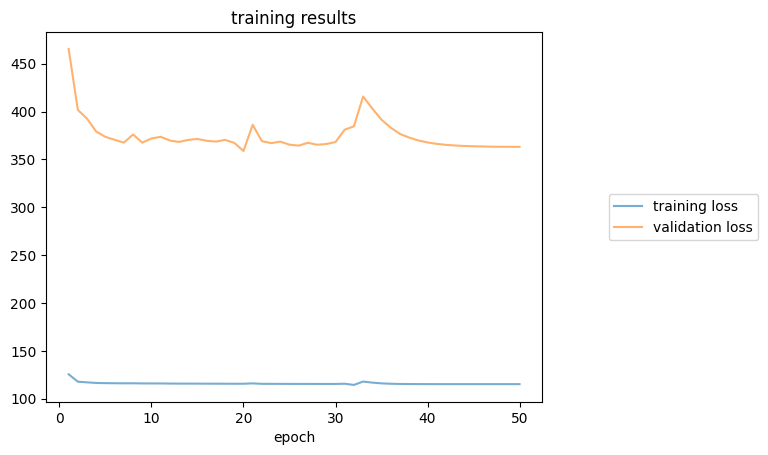

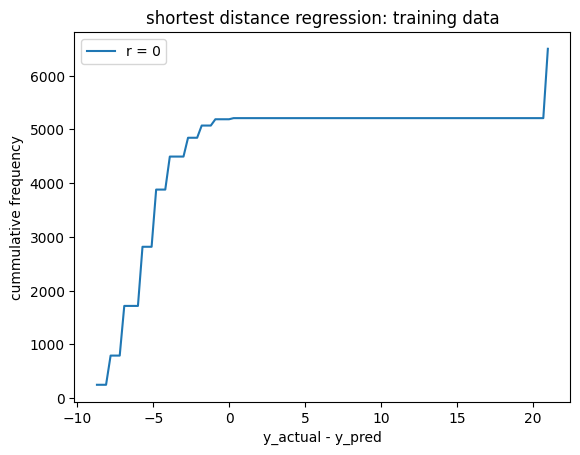

mean difference per seed set =  [-0.01956695]
mean difference per seed node =  [-8.716643  -3.7166433 -4.7166433 ... -6.7166433 -5.7166433 -5.7166433]


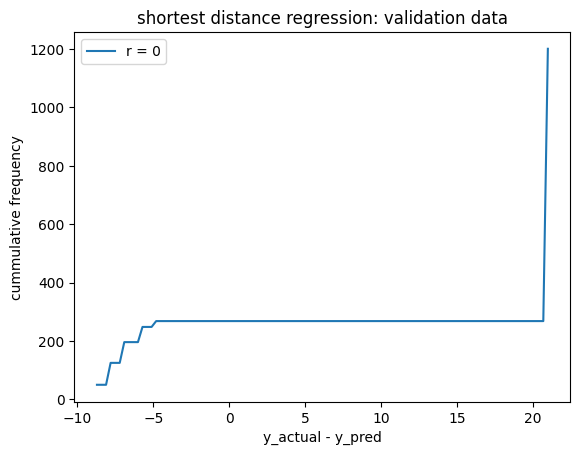

mean difference per seed set =  [14.960856]
mean difference per seed node =  [-4.7166433 21.283356  21.283356  ... 21.283356  21.283356  -5.7166433]


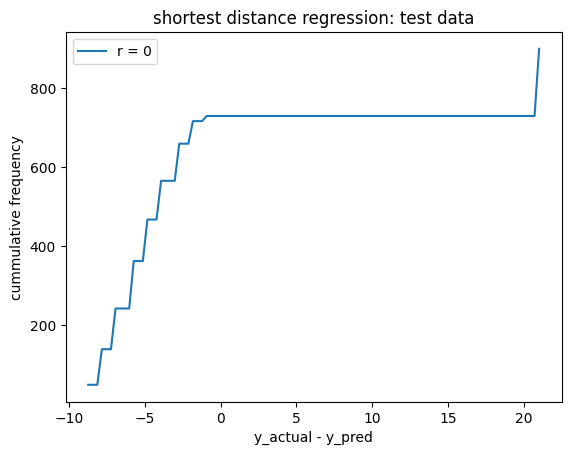

mean difference per seed set =  [-0.12442172]
mean difference per seed node =  [21.283356   -2.7166433  -2.7166433  -1.7166433  -6.7166433  -5.7166433
 -4.7166433  -4.7166433  21.283356   -5.7166433  -3.7166433  -7.7166433
 -6.7166433  -7.7166433  -3.7166433  -2.7166433  -3.7166433  -8.716643
 21.283356   -5.7166433  -5.7166433  -4.7166433  -7.7166433  -4.7166433
 -7.7166433  -7.7166433  21.283356   -8.716643   -6.7166433  -6.7166433
 -5.7166433  -4.7166433  -6.7166433  -5.7166433  -6.7166433  -5.7166433
 21.283356   -1.7166433  -1.7166433  -0.71664333 -5.7166433  -4.7166433
 -3.7166433  -3.7166433  21.283356   -4.7166433  -2.7166433  -6.7166433
 -5.7166433  -8.716643   -2.7166433  -1.7166433  -2.7166433  -7.7166433
 -7.7166433  21.283356   21.283356   21.283356   21.283356   21.283356
 21.283356   21.283356   -8.716643   21.283356   21.283356   21.283356
 21.283356   21.283356   21.283356   21.283356   21.283356   21.283356
 21.283356   -2.7166433  -8.716643   -1.7166433  -4.7166433  

In [43]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.05)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 1.6008, Validation Loss (MSE): 1.6894
Epoch: 020, Training Loss (MSE): 1.6016, Validation Loss (MSE): 1.6890
Epoch: 030, Training Loss (MSE): 1.6015, Validation Loss (MSE): 1.6890
Epoch: 040, Training Loss (MSE): 1.6015, Validation Loss (MSE): 1.6890
Epoch: 050, Training Loss (MSE): 1.6015, Validation Loss (MSE): 1.6890
Test Loss (MSE): 1.118186


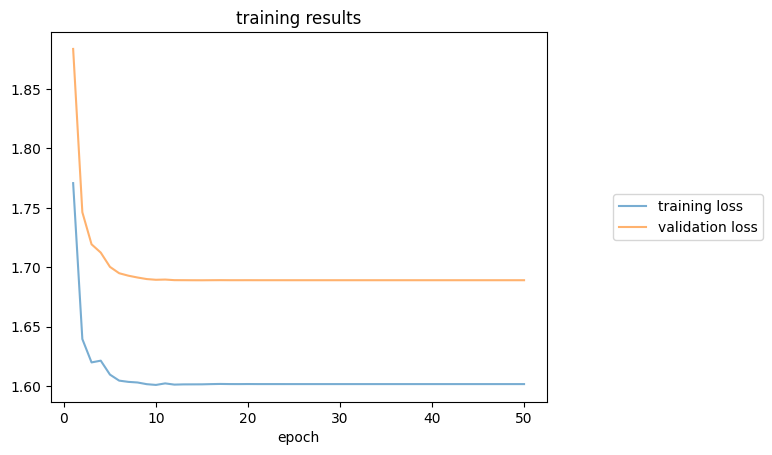

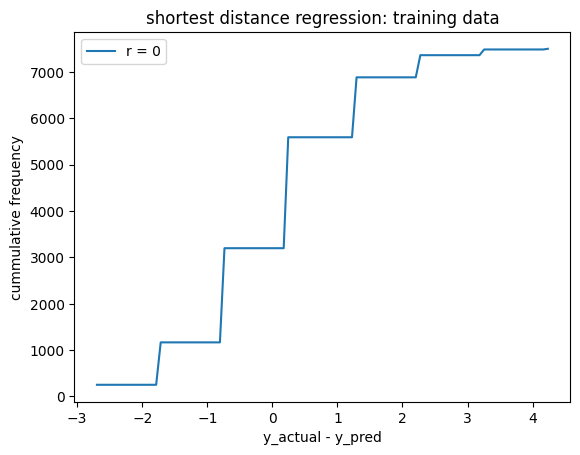

mean difference per seed set =  [0.04628753]
mean difference per seed node =  [-1.6958458   0.30415416 -2.6958458  ...  0.30415416  0.30415416
  0.30415416]


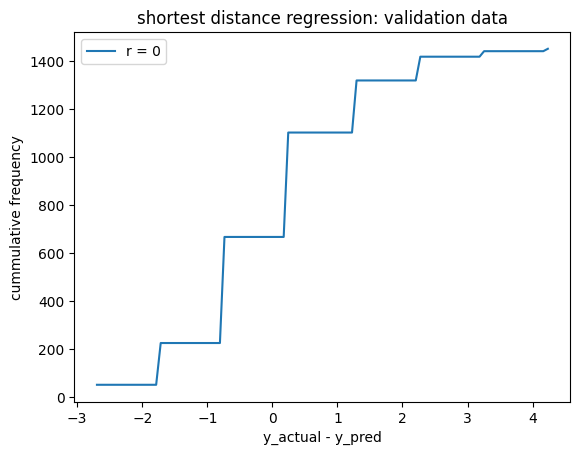

mean difference per seed set =  [0.01725764]
mean difference per seed node =  [-0.69584584 -1.6958458   0.30415416 ... -1.6958458  -1.6958458
 -0.69584584]


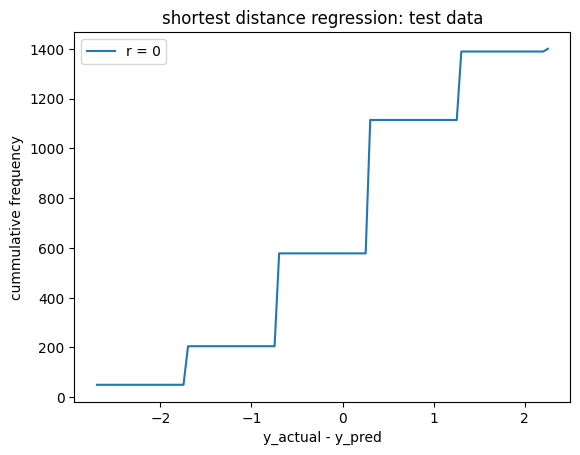

mean difference per seed set =  [-0.07870297]
mean difference per seed node =  [ 0.30415416  0.30415416  1.3041542  ...  0.30415416  1.3041542
 -0.69584584]


In [44]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.1)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.8248, Validation Loss (MSE): 0.5456
Epoch: 020, Training Loss (MSE): 0.8239, Validation Loss (MSE): 0.5525
Epoch: 030, Training Loss (MSE): 0.8300, Validation Loss (MSE): 0.5249
Epoch: 040, Training Loss (MSE): 0.8239, Validation Loss (MSE): 0.5524
Epoch: 050, Training Loss (MSE): 0.8239, Validation Loss (MSE): 0.5524
Test Loss (MSE): 0.591651


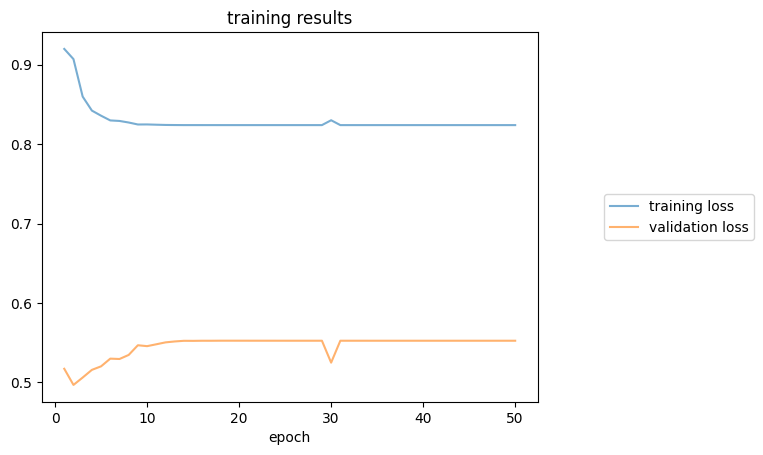

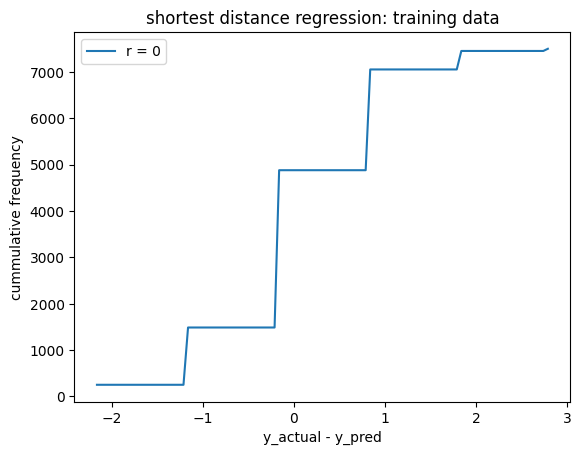

mean difference per seed set =  [0.02078681]
mean difference per seed node =  [-0.16281319  0.8371868   0.8371868  ... -0.16281319 -0.16281319
  0.8371868 ]


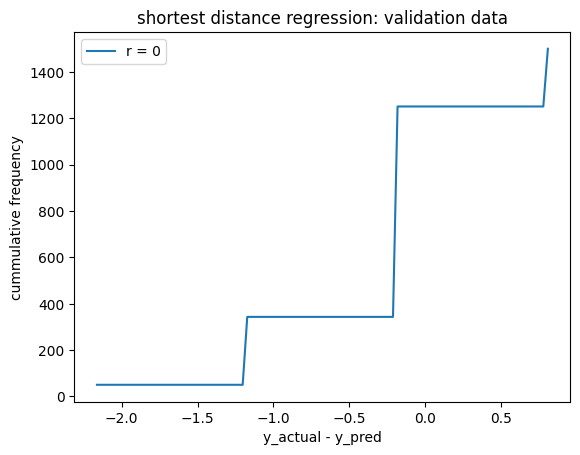

mean difference per seed set =  [-0.2588132]
mean difference per seed node =  [-0.16281319 -0.16281319 -0.16281319 ...  0.8371868  -0.16281319
 -0.16281319]


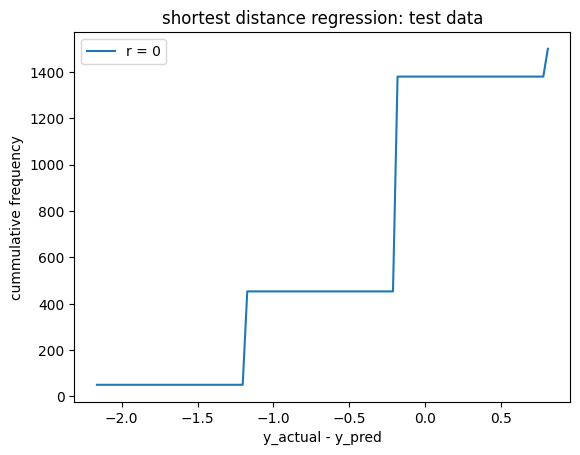

mean difference per seed set =  [-0.4181465]
mean difference per seed node =  [-0.16281319 -1.1628132  -0.16281319 ... -1.1628132  -0.16281319
 -0.16281319]


In [45]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.2)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3235, Validation Loss (MSE): 0.3194
Epoch: 020, Training Loss (MSE): 0.3235, Validation Loss (MSE): 0.3194
Epoch: 030, Training Loss (MSE): 0.3235, Validation Loss (MSE): 0.3194
Epoch: 040, Training Loss (MSE): 0.3235, Validation Loss (MSE): 0.3194
Epoch: 050, Training Loss (MSE): 0.3235, Validation Loss (MSE): 0.3194
Test Loss (MSE): 0.319334


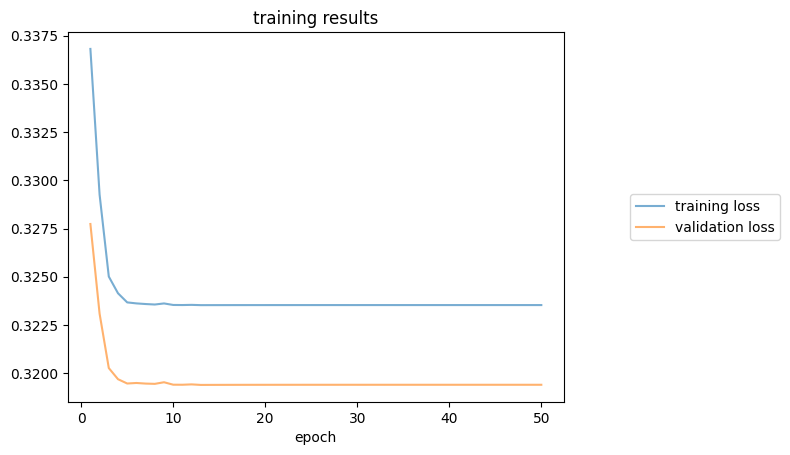

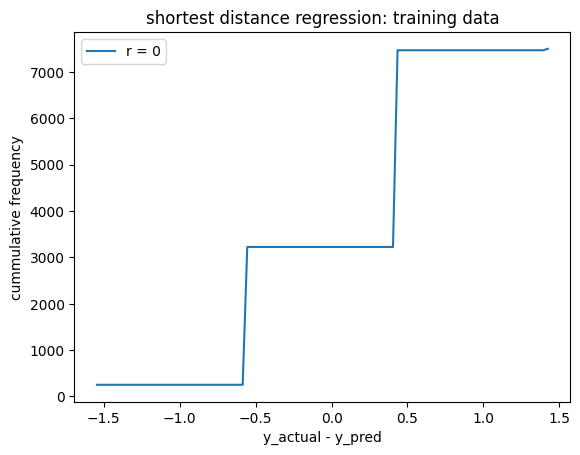

mean difference per seed set =  [-0.00433658]
mean difference per seed node =  [0.45459676 0.45459676 0.45459676 ... 0.45459676 0.45459676 0.45459676]


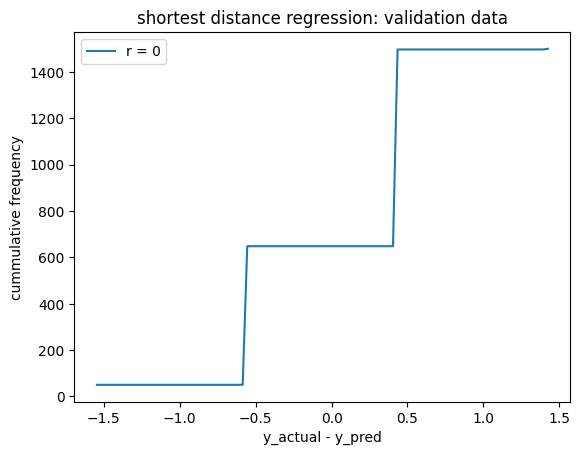

mean difference per seed set =  [-0.00873658]
mean difference per seed node =  [ 0.45459676 -0.54540324 -0.54540324 ... -0.54540324 -0.54540324
 -0.54540324]


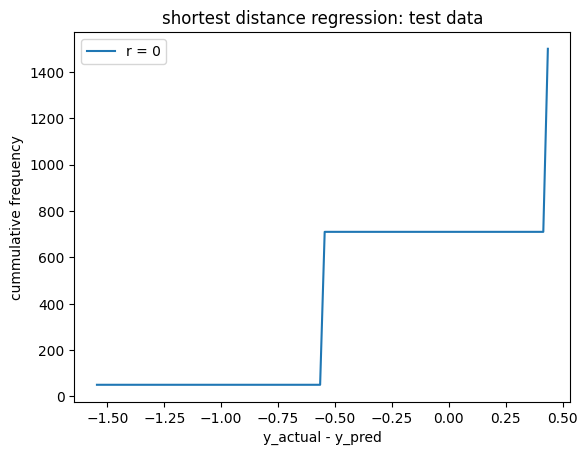

mean difference per seed set =  [-0.05206991]
mean difference per seed node =  [-0.54540324 -0.54540324  0.45459676 ...  0.45459676  0.45459676
 -0.54540324]


In [46]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.4)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1985, Validation Loss (MSE): 0.1881
Epoch: 020, Training Loss (MSE): 0.1985, Validation Loss (MSE): 0.1881
Epoch: 030, Training Loss (MSE): 0.1985, Validation Loss (MSE): 0.1881
Epoch: 040, Training Loss (MSE): 0.1985, Validation Loss (MSE): 0.1881
Epoch: 050, Training Loss (MSE): 0.1985, Validation Loss (MSE): 0.1881
Test Loss (MSE): 0.186779


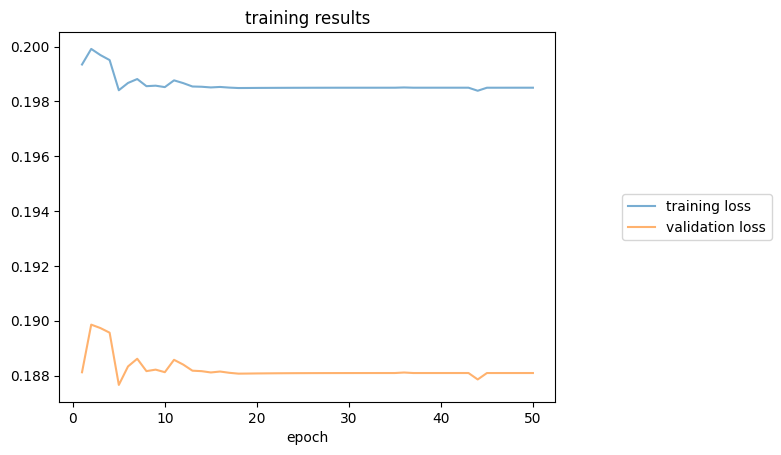

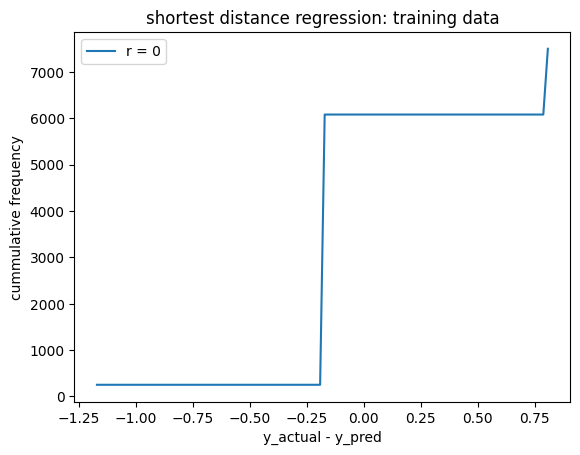

mean difference per seed set =  [-0.01614376]
mean difference per seed node =  [-0.17201042 -0.17201042 -0.17201042 ... -0.17201042 -0.17201042
 -0.17201042]


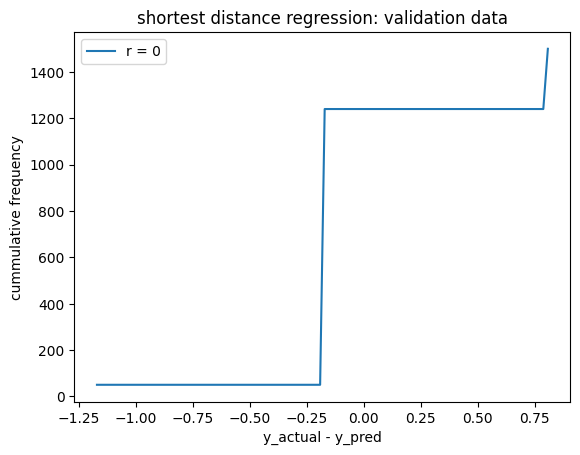

mean difference per seed set =  [-0.03201042]
mean difference per seed node =  [-0.17201042 -0.17201042 -0.17201042 ...  0.8279896  -0.17201042
 -0.17201042]


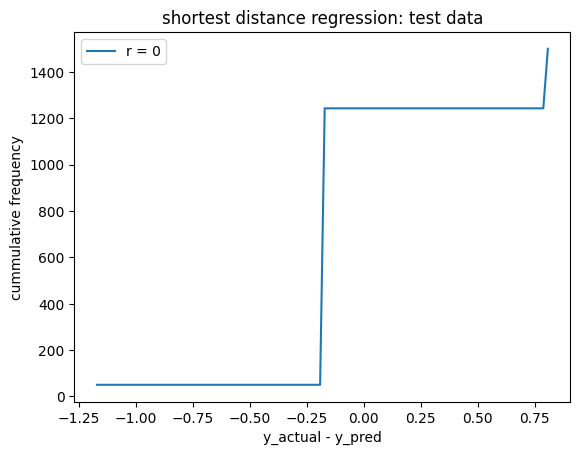

mean difference per seed set =  [-0.03401042]
mean difference per seed node =  [-0.17201042 -1.1720104  -0.17201042 ... -0.17201042 -0.17201042
 -0.17201042]


In [47]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,30,0.8)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.8990, Validation Loss (MSE): 32.7440
Epoch: 020, Training Loss (MSE): 0.8990, Validation Loss (MSE): 32.7405
Epoch: 030, Training Loss (MSE): 0.8990, Validation Loss (MSE): 32.7406
Epoch: 040, Training Loss (MSE): 0.8990, Validation Loss (MSE): 32.7409
Epoch: 050, Training Loss (MSE): 0.8990, Validation Loss (MSE): 32.7406
Test Loss (MSE): 0.756730


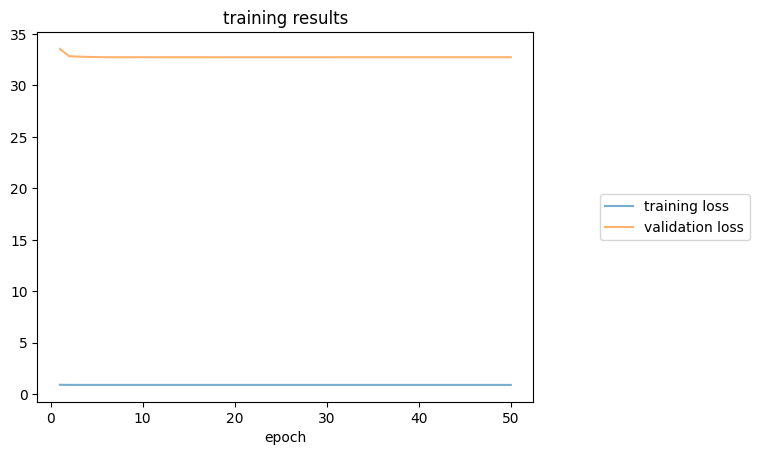

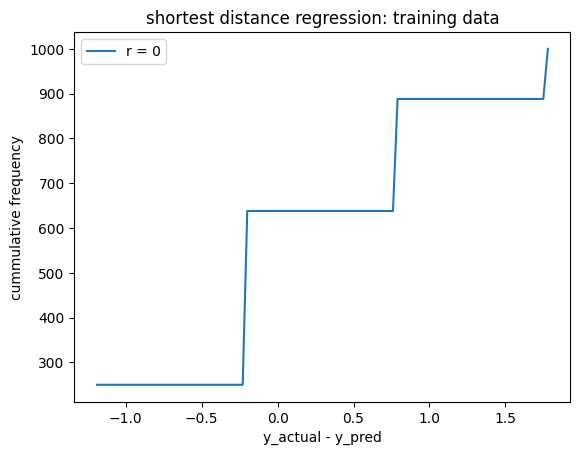

mean difference per seed set =  [0.03393958]
mean difference per seed node =  [ 1.8099396  -1.1900604  -0.19006038  0.8099396   0.8099396  -0.19006038
 -1.1900604  -0.19006038  0.8099396  -0.19006038 -1.1900604  -0.19006038
 -1.1900604   1.8099396   0.8099396  -0.19006038  0.8099396  -0.19006038
 -1.1900604  -0.19006038 -0.19006038  0.8099396  -0.19006038 -1.1900604
 -0.19006038  0.8099396  -0.19006038 -1.1900604  -0.19006038  0.8099396
 -0.19006038 -1.1900604   0.8099396  -0.19006038 -1.1900604  -0.19006038
  1.8099396  -1.1900604  -0.19006038  0.8099396  -0.19006038  0.8099396
 -0.19006038 -1.1900604   0.8099396  -0.19006038 -1.1900604  -0.19006038
 -1.1900604   1.8099396   0.8099396  -0.19006038 -1.1900604   1.8099396
  0.8099396  -0.19006038 -0.19006038  0.8099396  -0.19006038 -1.1900604
 -0.19006038  0.8099396  -0.19006038 -1.1900604  -0.19006038  0.8099396
 -0.19006038 -1.1900604   1.8099396  -1.1900604  -0.19006038  0.8099396
 -0.19006038  0.8099396  -0.19006038 -1.1900604   1.8

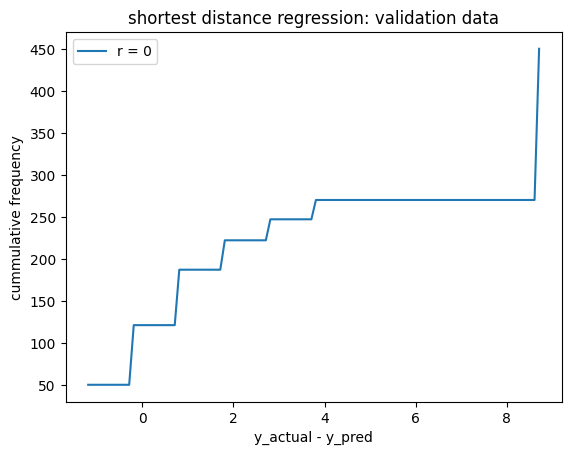

mean difference per seed set =  [3.972162]
mean difference per seed node =  [ 8.809939    8.809939    8.809939   -0.19006038  8.809939   -1.1900604
  8.809939    8.809939    8.809939    0.8099396   1.8099396  -1.1900604
  8.809939    2.8099396   8.809939    0.8099396  -0.19006038  3.8099396
  0.8099396   1.8099396  -1.1900604   8.809939    2.8099396   8.809939
  0.8099396  -0.19006038  3.8099396   0.8099396   1.8099396   0.8099396
  8.809939    2.8099396   8.809939   -1.1900604  -0.19006038  3.8099396
  0.8099396   1.8099396  -1.1900604   8.809939    2.8099396   8.809939
  0.8099396  -0.19006038  3.8099396   0.8099396   1.8099396   0.8099396
  8.809939    2.8099396   8.809939   -1.1900604  -0.19006038  3.8099396
  0.8099396   1.8099396  -1.1900604   8.809939    2.8099396   8.809939
  0.8099396  -0.19006038  3.8099396   0.8099396   1.8099396  -1.1900604
  8.809939    2.8099396   8.809939    0.8099396  -0.19006038  3.8099396
  1.8099396   0.8099396   3.8099396   8.809939   -0.19006038  8

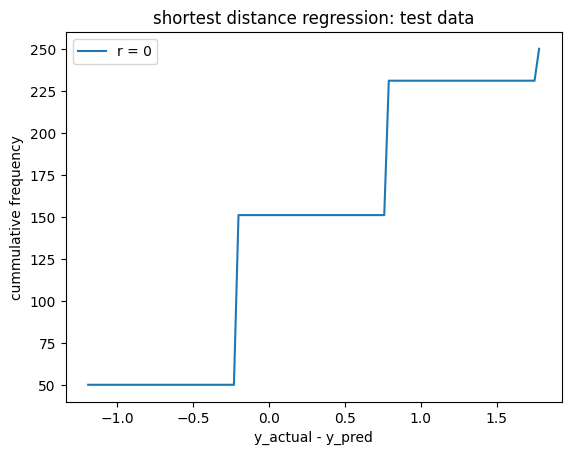

mean difference per seed set =  [0.08193962]
mean difference per seed node =  [ 0.8099396  -0.19006038 -0.19006038 -1.1900604  -0.19006038  1.8099396
  0.8099396  -1.1900604  -0.19006038  0.8099396  -0.19006038  0.8099396
  0.8099396  -0.19006038 -1.1900604  -1.1900604  -0.19006038  1.8099396
  0.8099396  -0.19006038 -0.19006038  0.8099396   0.8099396  -0.19006038
 -1.1900604  -0.19006038 -1.1900604   0.8099396  -0.19006038  0.8099396
  1.8099396   0.8099396  -1.1900604  -0.19006038  0.8099396  -0.19006038
 -1.1900604   0.8099396  -0.19006038  0.8099396   1.8099396   0.8099396
 -1.1900604  -0.19006038  0.8099396   0.8099396  -0.19006038 -0.19006038
 -1.1900604  -0.19006038 -0.19006038 -1.1900604   0.8099396  -0.19006038
  0.8099396  -1.1900604  -0.19006038  1.8099396   0.8099396  -0.19006038
 -0.19006038 -1.1900604   0.8099396  -0.19006038  0.8099396   0.8099396
 -0.19006038 -0.19006038 -1.1900604  -0.19006038 -1.1900604  -0.19006038
  1.8099396   0.8099396  -0.19006038 -0.19006038 -1.

In [48]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,10,0.15)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 1.0505, Validation Loss (MSE): 2.7099
Epoch: 020, Training Loss (MSE): 1.0503, Validation Loss (MSE): 2.7012
Epoch: 030, Training Loss (MSE): 1.0503, Validation Loss (MSE): 2.7013
Epoch: 040, Training Loss (MSE): 1.0503, Validation Loss (MSE): 2.7013
Epoch: 050, Training Loss (MSE): 1.0503, Validation Loss (MSE): 2.7013
Test Loss (MSE): 3.334857


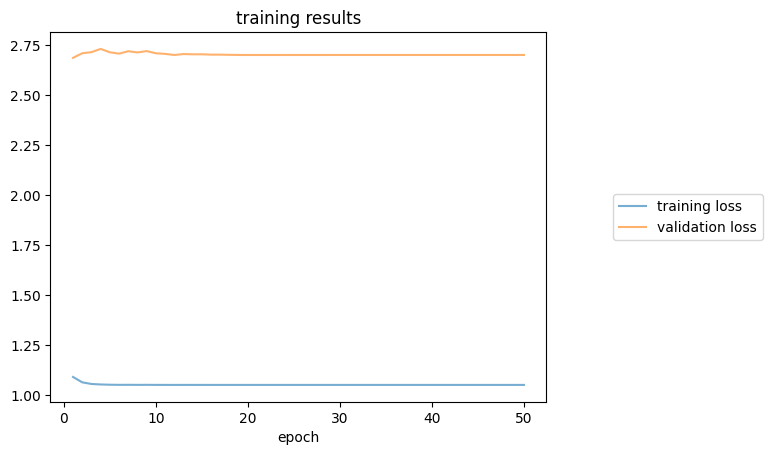

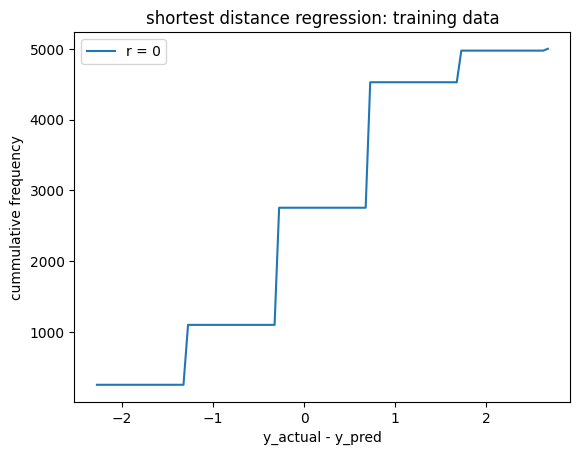

mean difference per seed set =  [0.00533825]
mean difference per seed node =  [-0.27446175 -0.27446175  0.72553825 ...  1.7255383  -0.27446175
  0.72553825]


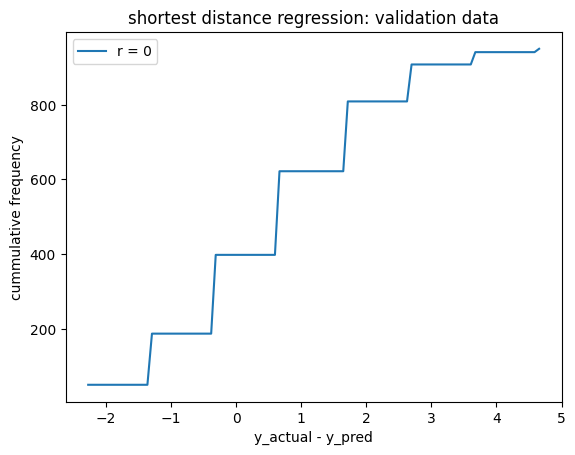

mean difference per seed set =  [0.60448563]
mean difference per seed node =  [ 1.7255383  -1.2744617  -0.27446175 -0.27446175  2.7255383   1.7255383
  1.7255383  -0.27446175  0.72553825  1.7255383  -1.2744617  -2.2744617
 -0.27446175 -1.2744617   0.72553825 -0.27446175 -1.2744617  -0.27446175
  0.72553825 -0.27446175  1.7255383   0.72553825  0.72553825 -0.27446175
 -1.2744617  -1.2744617   0.72553825 -0.27446175 -1.2744617  -0.27446175
  0.72553825 -0.27446175  1.7255383  -1.2744617   2.7255383   1.7255383
 -1.2744617  -2.2744617   1.7255383   3.7255383   2.7255383   2.7255383
 -2.2744617  -0.27446175 -1.2744617   0.72553825 -0.27446175 -1.2744617
  1.7255383   2.7255383   1.7255383   1.7255383   0.72553825  4.7255383
  3.7255383   0.72553825 -0.27446175 -0.27446175  1.7255383   0.72553825
  0.72553825 -0.27446175 -1.2744617  -1.2744617   0.72553825 -0.27446175
 -1.2744617  -0.27446175  0.72553825 -0.27446175  1.7255383  -1.2744617
  2.7255383   1.7255383  -1.2744617  -2.2744617   1.7

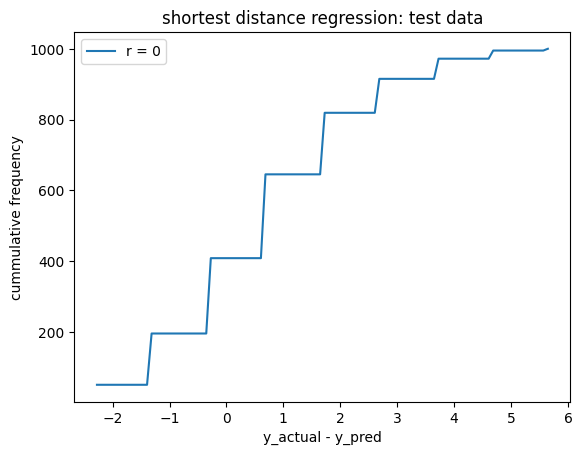

mean difference per seed set =  [0.7265382]
mean difference per seed node =  [ 0.72553825 -1.2744617  -1.2744617  -0.27446175  2.7255383   0.72553825
  0.72553825 -1.2744617   1.7255383   1.7255383  -0.27446175 -0.27446175
  0.72553825  0.72553825 -0.27446175 -0.27446175  1.7255383   0.72553825
 -2.2744617   0.72553825  0.72553825 -0.27446175 -2.2744617   0.72553825
  3.7255383   1.7255383  -0.27446175 -0.27446175  1.7255383   2.7255383
 -1.2744617  -0.27446175 -0.27446175 -0.27446175 -1.2744617  -1.2744617
  2.7255383  -0.27446175 -1.2744617   0.72553825  0.72553825  1.7255383
 -0.27446175  0.72553825  3.7255383   1.7255383   1.7255383  -0.27446175
 -0.27446175  0.72553825 -1.2744617  -0.27446175 -1.2744617  -1.2744617
  0.72553825 -0.27446175  2.7255383  -2.2744617   0.72553825 -1.2744617
  1.7255383   2.7255383   2.7255383  -0.27446175  0.72553825 -1.2744617
  4.7255383   0.72553825 -1.2744617  -2.2744617   1.7255383   0.72553825
  0.72553825  1.7255383   3.7255383   1.7255383  -0.2

In [49]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,20,0.15)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.5834, Validation Loss (MSE): 0.4994
Epoch: 020, Training Loss (MSE): 0.5833, Validation Loss (MSE): 0.4994
Epoch: 030, Training Loss (MSE): 0.5833, Validation Loss (MSE): 0.4994
Epoch: 040, Training Loss (MSE): 0.5833, Validation Loss (MSE): 0.4994
Epoch: 050, Training Loss (MSE): 0.5833, Validation Loss (MSE): 0.4994
Test Loss (MSE): 0.634420


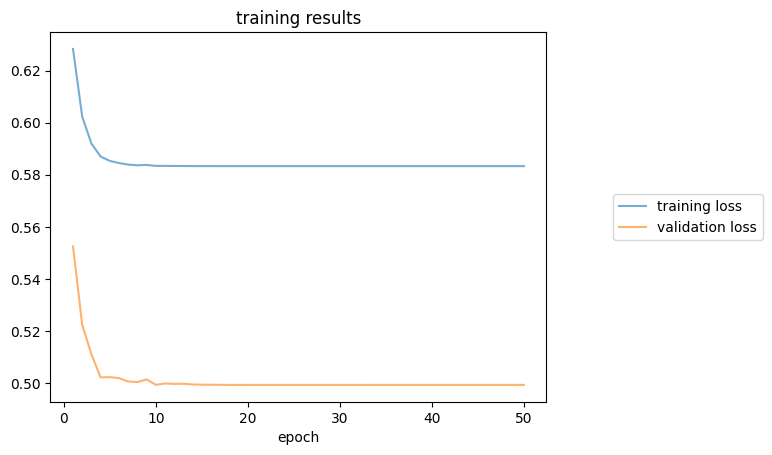

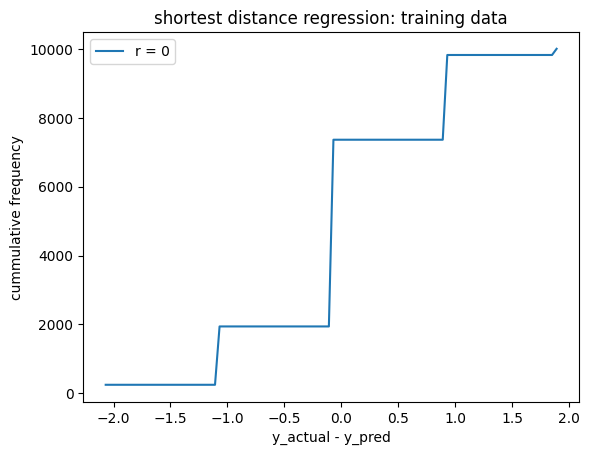

mean difference per seed set =  [-0.00600208]
mean difference per seed node =  [-1.0686021  -0.06860209 -0.06860209 ... -1.0686021   1.9313979
 -0.06860209]


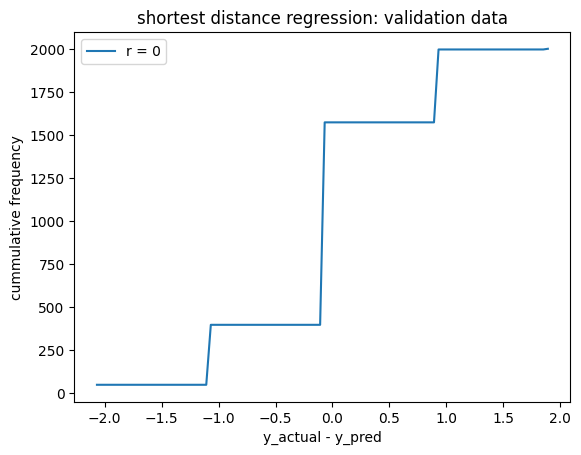

mean difference per seed set =  [-0.07710208]
mean difference per seed node =  [-0.06860209 -0.06860209  0.9313979  ... -0.06860209 -0.06860209
 -0.06860209]


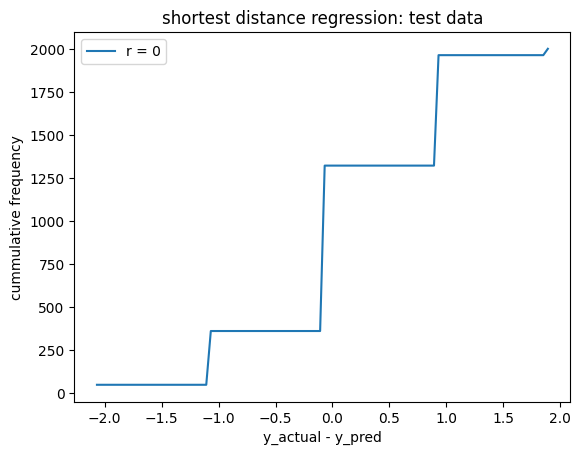

mean difference per seed set =  [0.08289792]
mean difference per seed node =  [-0.06860209  0.9313979   0.9313979  ... -1.0686021  -0.06860209
  0.9313979 ]


In [50]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,40,0.15)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3154, Validation Loss (MSE): 0.3203
Epoch: 020, Training Loss (MSE): 0.3151, Validation Loss (MSE): 0.3202
Epoch: 030, Training Loss (MSE): 0.3151, Validation Loss (MSE): 0.3202
Epoch: 040, Training Loss (MSE): 0.3151, Validation Loss (MSE): 0.3202
Epoch: 050, Training Loss (MSE): 0.3151, Validation Loss (MSE): 0.3202
Test Loss (MSE): 0.290711


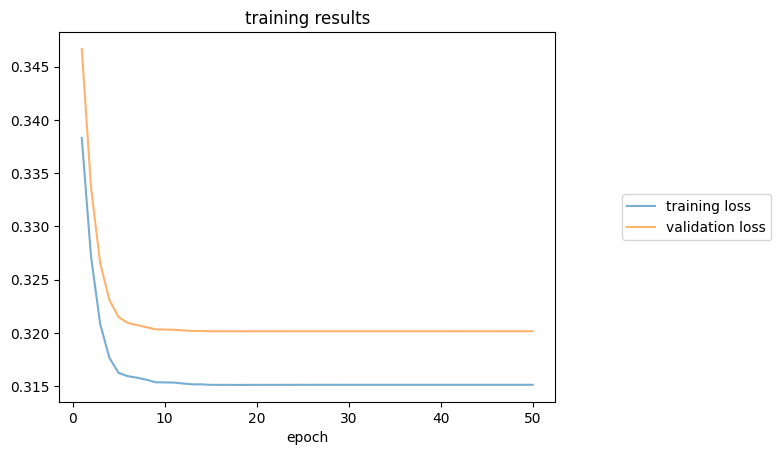

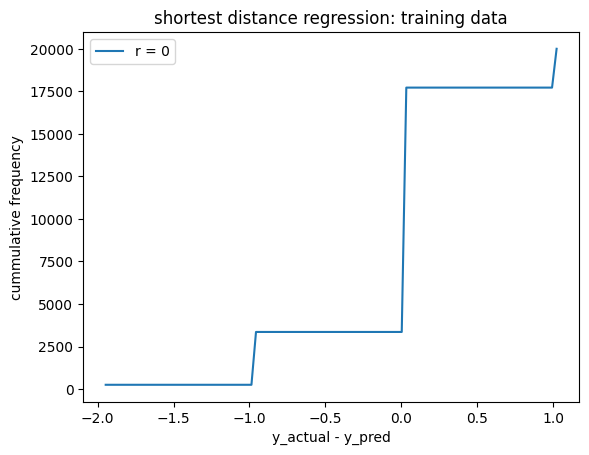

mean difference per seed set =  [-0.01295166]
mean difference per seed node =  [ 0.05319834 -0.94680166 -0.94680166 ...  0.05319834  0.05319834
  0.05319834]


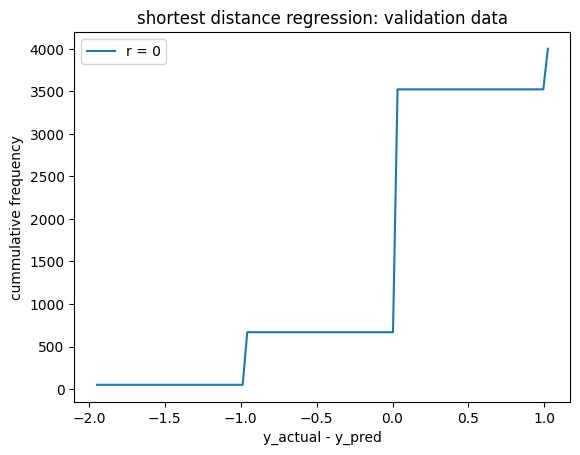

mean difference per seed set =  [-0.00705166]
mean difference per seed node =  [0.05319834 0.05319834 0.05319834 ... 1.0531983  0.05319834 0.05319834]


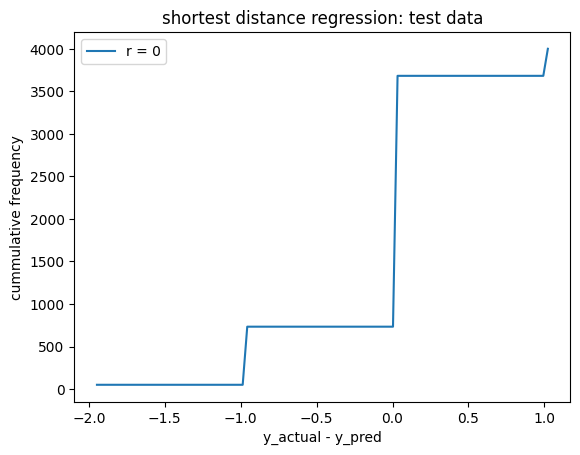

mean difference per seed set =  [-0.06305166]
mean difference per seed node =  [ 1.0531983   0.05319834  1.0531983  ...  0.05319834  0.05319834
 -0.94680166]


In [51]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,80,0.15)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1787, Validation Loss (MSE): 0.1707
Epoch: 020, Training Loss (MSE): 0.1787, Validation Loss (MSE): 0.1706
Epoch: 030, Training Loss (MSE): 0.1787, Validation Loss (MSE): 0.1706
Epoch: 040, Training Loss (MSE): 0.1787, Validation Loss (MSE): 0.1706
Epoch: 050, Training Loss (MSE): 0.1787, Validation Loss (MSE): 0.1706
Test Loss (MSE): 0.180163


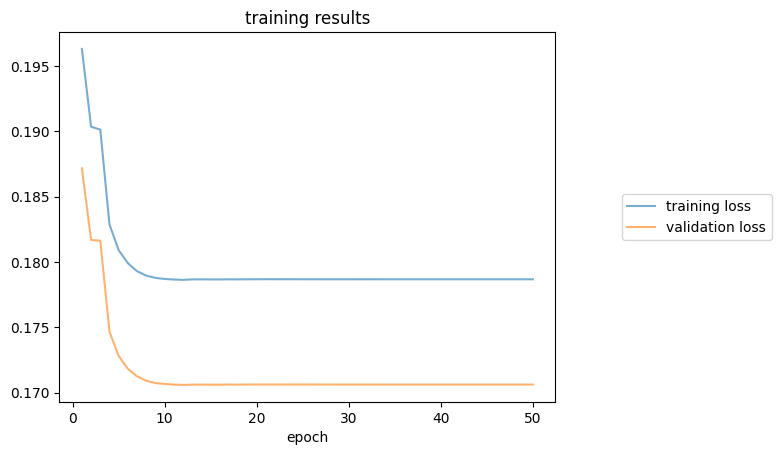

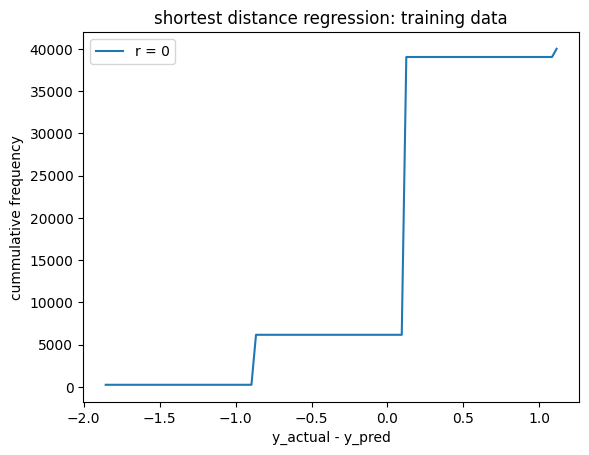

mean difference per seed set =  [0.00832787]
mean difference per seed node =  [ 0.14440286 -0.85559714  0.14440286 ...  0.14440286  0.14440286
  0.14440286]


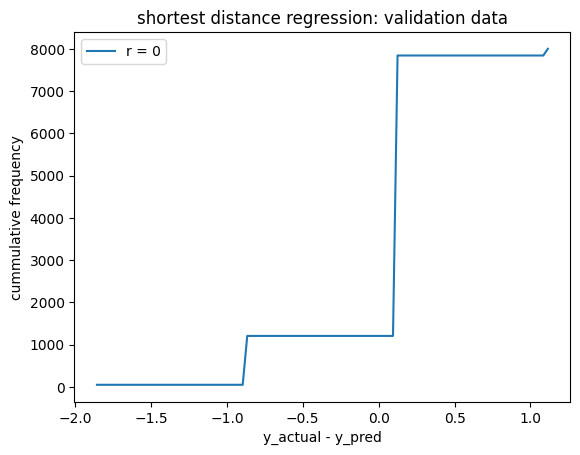

mean difference per seed set =  [0.00727787]
mean difference per seed node =  [0.14440286 0.14440286 0.14440286 ... 0.14440286 0.14440286 0.14440286]


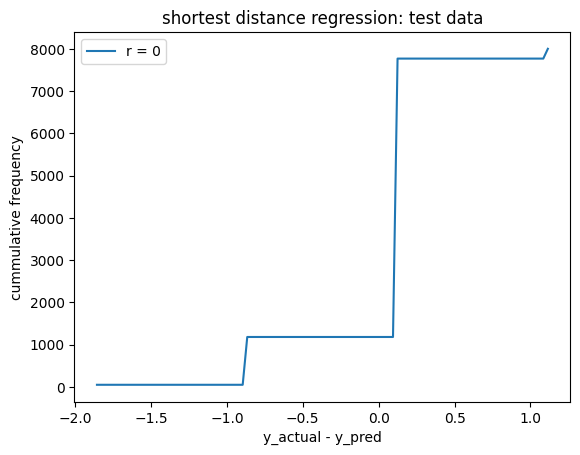

mean difference per seed set =  [0.01952787]
mean difference per seed node =  [-0.85559714  0.14440286  0.14440286 ...  0.14440286 -0.85559714
  0.14440286]


In [52]:
samples = generateSamples_closestPoints(250,50,50,2,k,ErdosRenyiGraph,160,0.15)
run(samples,'gcn','mse','adam',None,50)